# Figure 3:  RNA and ATAC, P9855

Here we study the chromatin accessibility (ATAC peak heights), gene expression (mRNA counts), and a bit of protein abundance for experiment P9855.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    font = findfont(FontProperties(family=['sans-serif']))

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [6]:
import matplotlib.font_manager as fm
from matplotlib.font_manager import findfont, FontProperties

font = fm.FontProperties(
        family = 'Helvetica', fname = '/System/Library/Fonts/Helvetica.ttc')

In [7]:
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

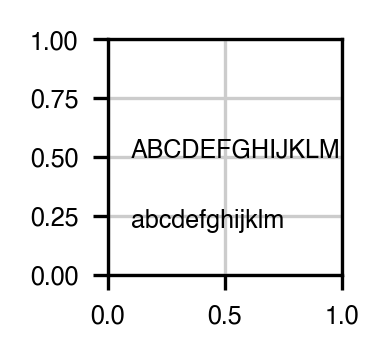

In [8]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

# Loading data

In [9]:
import anndata

adata = anndata.read_loom('../Data/Processed/P9855.loom')
adata.var_names = adata.var['gene_name']
adata.obs_names = adata.obs['obs_names']

prot_data = anndata.read_loom('../Data/Processed/P9855_protein.loom')
prot_data.var_names = prot_data.var['var_names']
prot_data.obs_names = prot_data.obs['obs_names']

ATAC_data = anndata.read_loom('../Data/Processed/P9855_ATAC.loom')
ATAC_data.var_names = ATAC_data.var['PeakID']
ATAC_data.obs_names = ATAC_data.obs['Sample_name']

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
adata

AnnData object with n_obs × n_vars = 70 × 11881
    obs: 'Clone_ID', 'Good clone', 'Number_Of_Cells', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'ENSG', 'F_pval', 'GC_content', 'TSS', 'chr', 'dir', 'end', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'start', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

In [11]:
prot_data

AnnData object with n_obs × n_vars = 24213 × 8
    obs: 'Clone_ID', 'Clone_Name_Well_ID', 'FSC-A', 'FSC-H', 'FSC-W', 'Numerical_ID', 'Plate', 'SSC-A', 'SSC-H', 'SSC-W', 'SampleID', 'obs_names'
    var: 'gene', 'var_names'

In [12]:
ATAC_data

AnnData object with n_obs × n_vars = 29 × 80599
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

## Insert small peak filter

Based on some undesirable noise among low peaks, we remove all peak intervals in which the highest peak is below 15.

In [13]:
good_peaks = ATAC_data.to_df().max() >= np.log1p(15)

In [14]:
ATAC_data = ATAC_data[:,good_peaks]
ATAC_data

View of AnnData object with n_obs × n_vars = 29 × 40608
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

In [15]:
ATACR_data = ATAC_data[ATAC_data.obs['Is_replicate'] == True, :]
ATACR_data

View of AnnData object with n_obs × n_vars = 12 × 40608
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'mid', 'start'

# Quick ATAC plotting tool

We create a quick exploratory tool for plotting ATAC peaks, focusing on clones with replicates, and the sister clones 5a/5b.  We assign a modified clone label, for coloring purposes.

In [16]:
clones_focus = ['1', '15', '22', '23', '8', '9', '5a', '5b']

def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip in clones_focus:
        return cl_strip #'Clone '+cl_strip[5:]
    else:
        return 'Other'

ATAC_data.obs['colorclone'] = ATAC_data.obs['ATAC_clone'].map(lambda cl : clone_rename(cl))


Trying to set attribute `.obs` of view, copying.


In [20]:
mm = 1 / 25.4
def ATAC_plot(peak):
    fig,ax = plt.subplots(1,1,figsize=(80*mm,20*mm), dpi=300)
    sns.set_style('whitegrid')
    setfontsize()
    peak_heights = np.exp(pd.DataFrame(ATAC_data.to_df()[peak])) - 1
    peak_heights.columns = ['height']
    peak_heights['parent'] = ATAC_data.obs.ATAC_clone.apply(lambda c : c.split('_')[0])
    peak_heights['hue'] = ATAC_data.obs.colorclone
    sns.scatterplot(x='parent', y='height', color='gray', data=peak_heights[peak_heights['hue'] == 'Other'], 
                    legend=False, ax=ax,s=20)
    
    sns.scatterplot(x='parent', y='height', hue='hue', edgecolor='k',
                    data=peak_heights[peak_heights['hue'] != 'Other'], 
                    legend=False, ax=ax, s=20, alpha=0.8)
    
    ax.set_ylabel('Peak height')
    ax.set_xlabel('Clone')
    ax.tick_params(axis='both', pad=-1)
    plt.suptitle('Heights (absolute) for {}'.format(peak), y=1.05, x=0.55)
    plt.show()

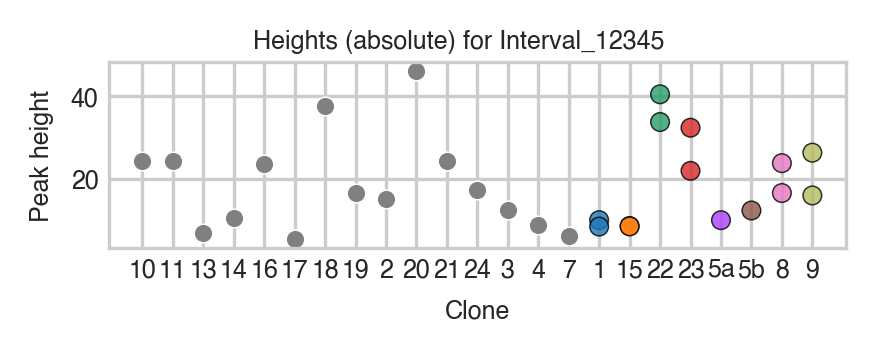

In [21]:
ATAC_plot('Interval_12345')

# Quick figure, IL2RG

By popular demand, here's a little figure related to IL2RG:  population and clonal expression.

In [22]:
IL2RG = adata.to_df()['IL2RG']
IL2RG

obs_names
P9855_2001    7.654436
P9855_2002    7.852678
P9855_2003    8.214191
P9855_2004    7.992360
P9855_2005    8.090677
                ...   
P9855_2078    7.712408
P9855_2079    7.539834
P9855_2080    7.655730
P9855_2081    7.998237
P9855_2082    8.375481
Name: IL2RG, Length: 70, dtype: float32

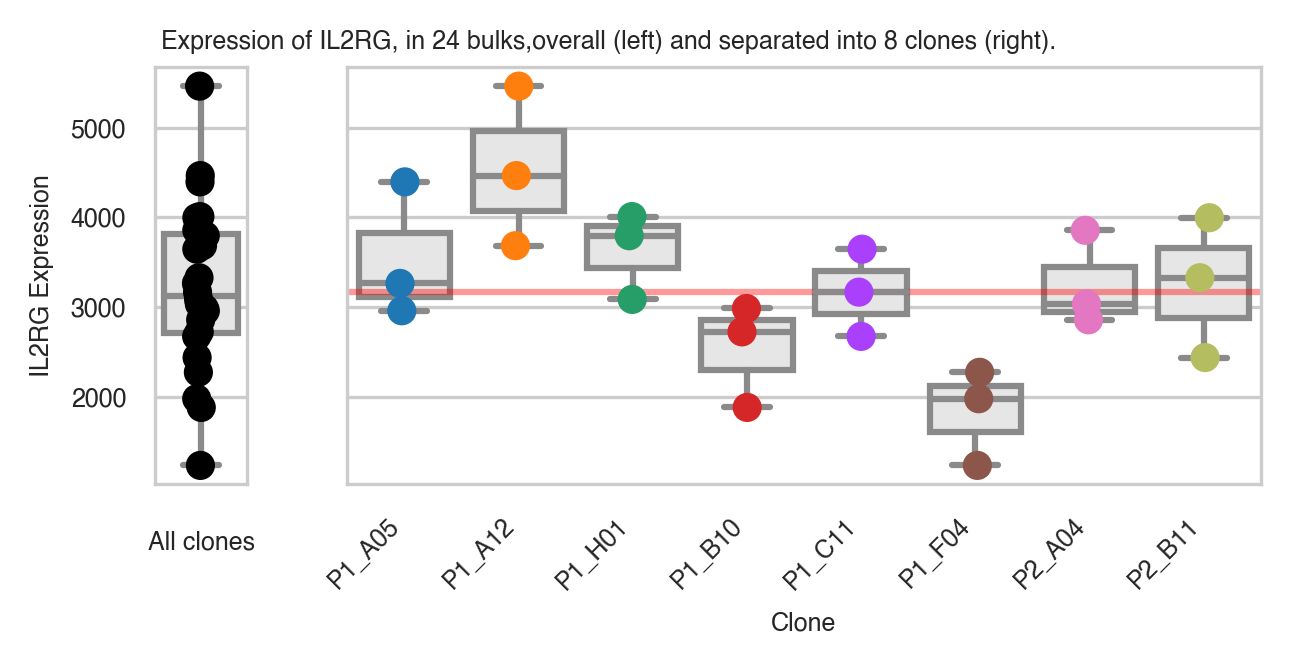

In [23]:
fig,ax = plt.subplots(1,2, sharey = True, figsize=(120*mm,45*mm), dpi=300, 
                      gridspec_kw = {'width_ratios':[1,10]})

allplot_df = pd.DataFrame(np.exp(IL2RG) - 1) # Remove log-normalization.
#allplot_df = pd.DataFrame(IL2RG) # Use log-normalized data?
allplot_df.columns=['IL2RG Expression']
allplot_df['Clone'] = adata.obs['Clone_ID']
allmean = allplot_df['IL2RG Expression'].median()

randclones = allplot_df['Clone'].value_counts()[:8].index
allplot_df = allplot_df[allplot_df['Clone'].isin(randclones)]

sns.boxplot(y='IL2RG Expression', color=(0.9,0.9,0.9,1), data = allplot_df, ax=ax[0], orient='v', whis=np.inf)
sns.stripplot(y='IL2RG Expression', color='black', data = allplot_df, 
              jitter=0.05, ax=ax[0], orient='v',s=7.0)

sns.boxplot(y='IL2RG Expression', x='Clone', color=(0.9,0.9,0.9,1), data = allplot_df, 
            ax=ax[1], orient='v', whis=np.inf)

sns.stripplot(y='IL2RG Expression', x='Clone', hue='Clone', data = allplot_df, 
              jitter=0.05, ax=ax[1], orient='v',s=7.0)

ax[0].set_xlabel('All clones')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha="right")
ax[1].axhline(allmean, color=(1,0,0,0.4))
ax[1].set_ylabel('')
ax[1].legend_.remove()

plt.suptitle('Expression of IL2RG, in {} bulks,'
             'overall (left) and separated into {} clones (right).'.format(len(allplot_df), len(allplot_df['Clone'].unique())))
plt.show()

# Panel:  UMAP Clustering based on ATAC peak heights

We cluster bulks by ATAC peaks using UMAP here.

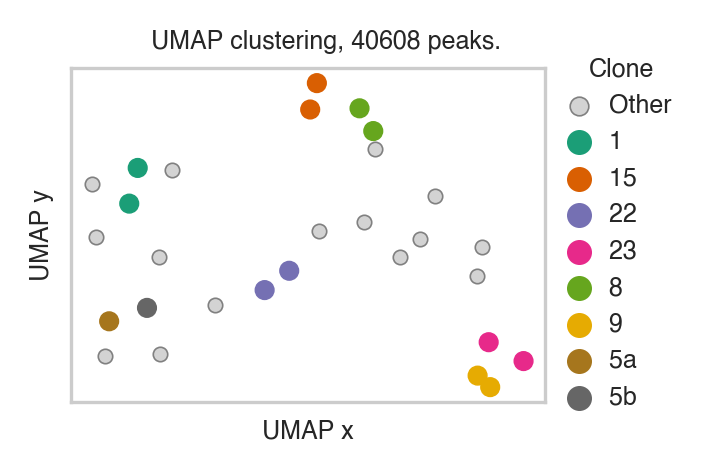

In [24]:
n_components = 10
n_neighbors = 5
min_dist = 0.25

mm = 1/25.4
figsize = (60*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

X = ATAC_data.to_df().copy()
y = ATAC_data.obs['colorclone']

hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
hue_order = ['  ' + hue for hue in hue_order]
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = '  ' + y
#display(cl_df)

sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == '  Other'], s=12, 
                color='lightgray', edgecolor='gray', linewidth=0.4, ax=ax, label='  Other')

sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != '  Other'], s=20, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])

lgnd = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.1), ncol=1, framealpha=0.0, title='Clone')

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [20]
for j in range(1,9):
    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("UMAP clustering, {} peaks.".format(len(X.T)), 
            x=0.6, y=1.0)

set_size(fig, figsize)
plt.savefig("Panels/UMAP.pdf", bbox_inches='tight')

plt.show()

## Varying the UMAP parameters

Now we vary the UMAP parameters through 27 different choices, and look at the resulting distance (in the UMAP plane) between clones, replicates, and the sister clones.

In [33]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform, pdist

n_comp_array = [5,10,20] # PCA components.  Can't be more than the number of samples!
n_neigh_array = [3,5,10]
min_dist_array = [0.1, 0.25, 0.5]


X = ATAC_data.to_df().copy()
y = ATAC_data.obs['colorclone']

clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]

dist_df = pd.DataFrame(index=range(len(n_comp_array)*len(n_neigh_array)*len(min_dist_array)), 
                       columns=['n_components','n_neighbors','min_dist','rep_dist','sis_dist','nonrep_dist'])

j = 0
dm = {}
for n_components in n_comp_array:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
    for n_neighbors in n_neigh_array:
        for min_dist in min_dist_array:
            X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                                   random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

            cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
            cl_df.index = 'clone' + ATAC_data.obs['ATAC_clone']
            #cl_df['Clone'] = y
            dm[j] = pd.DataFrame(distance_matrix(cl_df.values, cl_df.values), index=cl_df.index, columns=cl_df.index)
            
            #dm[j].index = 'clone' + ATAC_data.obs['ATAC_clone']
            #dm[j].columns = 'clone' + ATAC_data.obs['ATAC_clone']
            #display(dm[j])
            rep_dist = np.array([dm[j].loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
            nonreps = [cl for cl in cl_df.index if cl.split('_')[0] not in 
                      ['clone'+num for num in clr_list]]
            dm_nonrep = dm[j].loc[nonreps][nonreps]
            nonrep_dist = dm_nonrep.values.flatten().mean()
            sis_dist = dm[j].loc['clone5a_R1','clone5b_R1']
            dist_df.loc[j] = {'n_components':n_components,
                             'n_neighbors':n_neighbors,
                             'min_dist':min_dist,
                             'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                             'sis_dist':sis_dist / nonrep_dist.mean(),
                             'nonrep_dist':nonrep_dist}
            j += 1
display(dist_df)
        

n_components n_neighbors min_dist  rep_dist  sis_dist nonrep_dist
0           5.0         3.0      0.1  0.046732  0.825849    7.518984
1           5.0         3.0     0.25  0.048647  0.157148    8.815798
2           5.0         3.0      0.5  0.036233  0.079457   17.958604
3           5.0         5.0      0.1   0.07603  0.109055    4.366601
4           5.0         5.0     0.25  0.154738   0.22718    2.792678
5           5.0         5.0      0.5  0.168347  0.235606    3.628004
6           5.0        10.0      0.1  0.209627  0.238309    1.916366
7           5.0        10.0     0.25  0.200294  0.260874    2.546401
8           5.0        10.0      0.5  0.322043  0.398251    2.172406
9          10.0         3.0      0.1  0.100419  0.124719    3.195755
10         10.0         3.0     0.25  0.084311  0.116869    4.333343
11         10.0         3.0      0.5  0.198196  0.224404    3.288818
12         10.0         5.0      0.1  0.159752   0.14453    2.393721
13         10.0         5.0     0.25  0.217267  0.227398    2.257442
14         10.0         5.0      0.5  0.240847  0.260925    2.598545
15         10.0        10.0      0.1  0.223965  0.325009    1.611912
16         10.0        10.0     0.25  0.304865  0.284332    1.833883
17         10.0        10.0      0.5   0.36132  0.470656    1.808922
18         20.0         3.0      0.1  0.085125  0.213586     3.18985
19         20.0         3.0     0.25  0.137251  0.239159    3.079778
20         20.0         3.0      0.5  0.220217   0.46371    2.717732
21         20.0         5.0      0.1  0.176763  0.431915    1.793802
22         20.0         5.0     0.25   0.24169  0.321096    2.183575
23         20.0         5.0      0.5  0.262081  0.447769    2.437334
24         20.0        10.0      0.1  0.272288  0.810944    1.453499
25         20.0        10.0     0.25  0.318109  0.760644    1.645932
26         20.0        10.0      0.5  0.332673  1.112998    1.942247

In [34]:
print('The mean UMAP distance between replicate clones is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.rep_dist.mean(), dist_df.rep_dist.std()))

print('The mean UMAP distance between sister clones 5a/5b is '
      '{:0.1%} +/- {:0.1%} of the mean non-replicate distance.'.format(dist_df.sis_dist.mean(), dist_df.sis_dist.std()))

The mean UMAP distance between replicate clones is 19.3% +/- 9.4% of the mean non-replicate distance.
The mean UMAP distance between sister clones 5a/5b is 35.2% +/- 25.4% of the mean non-replicate distance.


In [35]:
ATAC_df = ATAC_data.to_df()
ATAC_df.index = 'clone'+ATAC_data.obs['ATAC_clone']
ATAC_df = ATAC_df.T

In [36]:
X = ATAC_df.T
pca = PCA(n_components=10)
X_PCA = pca.fit_transform(X)
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

dm_raw = pd.DataFrame(distance_matrix(X_PCA, X_PCA), index=X.index, columns=X.index)
rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
nonreps = [cl for cl in X.index if cl.split('_')[0] not in ['clone'+num for num in clr_list]]
dm_nonrep = dm_raw.loc[nonreps][nonreps]
nonrep_dist = dm_nonrep.values.flatten().mean()
sis_dist = dm_raw.loc['clone5a_R1','clone5b_R1']
dist_raw_df = pd.Series({'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                  'sis_dist':sis_dist / nonrep_dist.mean(),
                  'nonrep_dist':nonrep_dist})
display(dist_raw_df)

rep_dist        0.049431
sis_dist        0.566176
nonrep_dist    97.523354
dtype: float64

In [37]:
#X = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']
def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'
    
y = [clone_rename(cl) for cl in ATAC_df.columns]
hue_order = ['Clone '+a for a in clr_list]

dm_raw = pd.DataFrame(distance_matrix(X.values, X.values), index=X.index, columns=X.index)
rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
nonreps = [cl for cl in X.index if cl.split('_')[0] not in ['clone'+num for num in clr_list]]
dm_nonrep = dm_raw.loc[nonreps][nonreps]
nonrep_dist = dm_nonrep.values.flatten().mean()
sis_dist = dm_raw.loc['clone5a_R1','clone5b_R1']
dist_raw_df = pd.Series({'rep_dist':rep_dist.mean() / nonrep_dist.mean(),
                  'sis_dist':sis_dist / nonrep_dist.mean(),
                  'nonrep_dist':nonrep_dist})
display(dist_raw_df)

rep_dist         0.510791
sis_dist         0.847184
nonrep_dist    134.593323
dtype: float64

In [38]:
dist_df

n_components n_neighbors min_dist  rep_dist  sis_dist nonrep_dist
0           5.0         3.0      0.1  0.046732  0.825849    7.518984
1           5.0         3.0     0.25  0.048647  0.157148    8.815798
2           5.0         3.0      0.5  0.036233  0.079457   17.958604
3           5.0         5.0      0.1   0.07603  0.109055    4.366601
4           5.0         5.0     0.25  0.154738   0.22718    2.792678
5           5.0         5.0      0.5  0.168347  0.235606    3.628004
6           5.0        10.0      0.1  0.209627  0.238309    1.916366
7           5.0        10.0     0.25  0.200294  0.260874    2.546401
8           5.0        10.0      0.5  0.322043  0.398251    2.172406
9          10.0         3.0      0.1  0.100419  0.124719    3.195755
10         10.0         3.0     0.25  0.084311  0.116869    4.333343
11         10.0         3.0      0.5  0.198196  0.224404    3.288818
12         10.0         5.0      0.1  0.159752   0.14453    2.393721
13         10.0         5.0     0.25  0.217267  0.227398    2.257442
14         10.0         5.0      0.5  0.240847  0.260925    2.598545
15         10.0        10.0      0.1  0.223965  0.325009    1.611912
16         10.0        10.0     0.25  0.304865  0.284332    1.833883
17         10.0        10.0      0.5   0.36132  0.470656    1.808922
18         20.0         3.0      0.1  0.085125  0.213586     3.18985
19         20.0         3.0     0.25  0.137251  0.239159    3.079778
20         20.0         3.0      0.5  0.220217   0.46371    2.717732
21         20.0         5.0      0.1  0.176763  0.431915    1.793802
22         20.0         5.0     0.25   0.24169  0.321096    2.183575
23         20.0         5.0      0.5  0.262081  0.447769    2.437334
24         20.0        10.0      0.1  0.272288  0.810944    1.453499
25         20.0        10.0     0.25  0.318109  0.760644    1.645932
26         20.0        10.0      0.5  0.332673  1.112998    1.942247

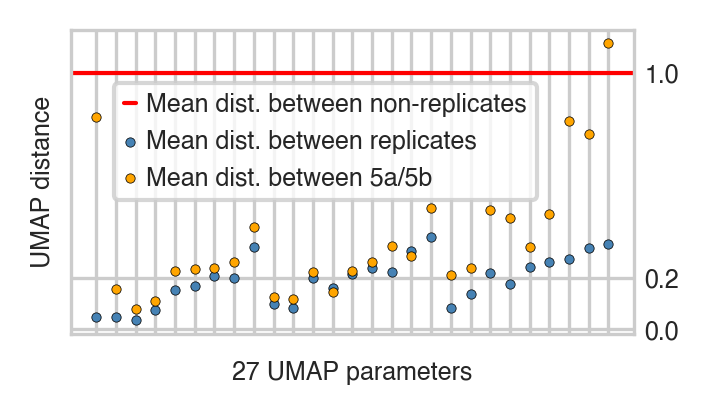

In [41]:
figsize=(60*mm,35*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)

sns.set_style('whitegrid')
setfontsize()

plot_df = dist_df.copy()
plot_df['Distance between replicates'] = plot_df['rep_dist']
plot_df['Distance between 5a/5b'] = plot_df['sis_dist']

plot_df['Parameter'] = dist_df['n_components'].astype(int).astype(str)+', '
plot_df['Parameter'] += dist_df['n_neighbors'].astype(int).astype(str)+', '
plot_df['Parameter'] +=  dist_df['min_dist'].astype(str).apply(lambda s : s[1:])
sns.scatterplot(y = 'Distance between replicates', x='Parameter', data=plot_df, 
                s=5, edgecolor='k', color='steelblue', ax=ax, label='Mean dist. between replicates')
sns.scatterplot(y = 'Distance between 5a/5b', x='Parameter', data=plot_df, 
                s=5, edgecolor='k', color='orange', ax=ax, label='Mean dist. between 5a/5b')

ax.axhline(1.0, label='Mean dist. between non-replicates', color='red', linewidth=1)
ax.legend(bbox_to_anchor=(0.85, 0.4))
ax.set_ylabel('UMAP distance')
ax.set_xticklabels([])
ax.set_xlabel('27 UMAP parameters')
ax.set_yticks([0,0.2,1])
ax.tick_params(axis='both', pad=-1)
ax.tick_params(axis='y', labelright=True, labelleft=False)

set_size(fig, figsize)
plt.savefig("Panels/UMAP_params.pdf", bbox_inches='tight')

plt.show()

#  Clonal peak variability

Here we look at clonal peak variability, among the replicate clones.  The replicate clones offer a method for simultaneous quality control and variability assessment.  We put the replicate peak heights into a dataframe first.

In [42]:
AR_df = ATACR_data.to_df()
AR_df.index = ATACR_data.obs.ATAC_clone
AR_df

PeakID      Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
ATAC_clone                                                                   
1_R1              2.220971        2.315422        2.116660        5.671244   
1_R2              2.574305        2.743844        2.183737        5.564601   
15_R1             2.335525        2.683983        2.465641        5.688357   
15_R2             2.405284        3.251001        2.472925        5.707511   
22_R1             2.244406        1.836056        1.836056        5.708737   
22_R2             3.193007        2.102691        2.843361        5.701477   
23_R1             1.966361        1.506567        1.684364        5.644652   
23_R2             2.089187        2.495113        2.207124        5.422726   
8_R1              2.349192        1.845438        2.404186        5.449306   
8_R2              2.764788        1.938780        2.645507        5.587162   
9_R1              2.610464        2.833161        2.774429        5.439472   
9_R2              1.911073        2.905863        2.621405        5.426267   

PeakID      Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
ATAC_clone                                                                  
1_R1              2.401717        3.377605        3.313264       4.745931   
1_R2              1.533994        3.179393        3.153849       5.019365   
15_R1             1.796163        3.665038        0.890413       5.179786   
15_R2             2.536280        3.984053        0.574085       5.185097   
22_R1             2.244406        3.383287        1.836056       5.176583   
22_R2             1.986456        3.479647        1.307133       4.987438   
23_R1             1.290173        3.610647        0.000000       4.964272   
23_R2             1.618351        3.594341        1.106046       5.158560   
8_R1              1.515987        3.879200        3.382059       5.243636   
8_R2              1.938780        3.833457        3.569858       5.121625   
9_R1              2.414239        3.765365        1.078167       5.125531   
9_R2              2.423591        3.834274        2.078779       5.169731   

PeakID      Interval_6501  Interval_68580  ...  Interval_69022  \
ATAC_clone                                 ...                   
1_R1             4.688817        5.477601  ...        4.004826   
1_R2             4.815708        5.461985  ...        4.348597   
15_R1            4.634396        5.577959  ...        4.017701   
15_R2            4.518895        5.676119  ...        4.421291   
22_R1            5.096018        5.234419  ...        4.300684   
22_R2            5.041146        5.476916  ...        3.938026   
23_R1            4.325634        5.529636  ...        4.162033   
23_R2            4.554307        5.487547  ...        4.341717   
8_R1             4.568126        5.484337  ...        4.294054   
8_R2             4.448444        5.469012  ...        4.169264   
9_R1             3.958736        5.456172  ...        4.144042   
9_R2             4.164550        5.402453  ...        4.112055   

PeakID      Interval_56910  Interval_27261  Interval_76540  Interval_57434  \
ATAC_clone                                                                   
1_R1              5.825352        2.315422        2.747701        4.865391   
1_R2              5.625410        2.311708        3.044600        5.019365   
15_R1             5.707617        2.402698        2.009906        5.031943   
15_R2             5.745415        2.405284        2.169631        5.136153   
22_R1             5.789331        1.836056        2.822287        5.108843   
22_R2             5.771048        2.206811        3.075744        5.206758   
23_R1             5.772682        1.966361        2.280140        5.057832   
23_R2             5.624217        2.408018        0.698727        5.021691   
8_R1              5.731441        2.456313        2.505857        5.077258   
8_R2              5.493785        2.020924   

This data contains 12 samples, with 2 bulks from each clone.  These 2 bulks are considered replicates (R1 and R2).

In [43]:
parents = ATACR_data.obs.ATAC_parent.unique()
parents

array(['1', '15', '22', '23', '8', '9'], dtype=object)

We examine the general distribution of replicate pairs, by "melting" the dataframe above.

In [44]:
AR_mins = pd.DataFrame(columns=AR_df.columns, index=parents)
AR_maxs = pd.DataFrame(columns=AR_df.columns, index=parents)
for cp in parents:
    AR_both = AR_df.loc[[cp+'_R1',cp+'_R2']]
    AR_mins.loc[cp] = AR_both.min()
    AR_maxs.loc[cp] = AR_both.max()

minmelt = AR_mins.melt()
mindiff_df = pd.DataFrame(minmelt.value, index=minmelt.index)
mindiff_df.columns = ['min_value']

mindiff_df['Diff'] = (AR_maxs - AR_mins).melt().value.astype(float)

val_max = mindiff_df.min_value.max() + 0.01
int_size = (val_max - 0.01) / 10
tuple_list = [(a+1e-10,a+int_size) for a in np.arange(0.01,val_max,int_size)]

bins = pd.IntervalIndex.from_tuples([(0,0.01)] + tuple_list, closed='left')
mindiff_df['Cut'] = pd.cut(mindiff_df.min_value, bins=bins)

bigdiffs = mindiff_df.groupby('Cut').Diff.quantile(0.99).astype(float)
mindiff_df['bigdiff'] = mindiff_df.Cut.map(bigdiffs).astype(float)

mindiff_df['badpeak'] = (mindiff_df.Diff > mindiff_df.bigdiff)

mindiff_df['PeakID'] = minmelt['PeakID']

mindiff_df

min_value      Diff                                       Cut  \
0       2.220971  0.353334   [1.976722536187036, 2.6322967147827145)   
1       2.335525  0.069759   [1.976722536187036, 2.6322967147827145)   
2       2.244406  0.948601   [1.976722536187036, 2.6322967147827145)   
3       1.966361  0.122825  [1.3211483574913574, 1.9767225360870362)   
4       2.349192  0.415596   [1.976722536187036, 2.6322967147827145)   
...          ...       ...                                       ...   
243643   1.41148  0.257812  [1.3211483574913574, 1.9767225360870362)   
243644  1.426249  0.780562  [1.3211483574913574, 1.9767225360870362)   
243645   1.83527  0.253916  [1.3211483574913574, 1.9767225360870362)   
243646   1.93878  0.783544  [1.3211483574913574, 1.9767225360870362)   
243647   1.84578  0.065293  [1.3211483574913574, 1.9767225360870362)   

         bigdiff  badpeak          PeakID  
0       0.878883    False  Interval_77062  
1       0.878883    False  Interval_77062  
2       0.878883     True  Interval_77062  
3       1.163165    False  Interval_77062  
4       0.878883    False  Interval_77062  
...          ...      ...             ...  
243643  1.163165    False  Interval_17712  
243644  1.163165    False  Interval_17712  
243645  1.163165    False  Interval_17712  
243646  1.163165    False  Interval_17712  
243647  1.163165    False  Interval_17712  

[243648 rows x 6 columns]

This produces about a half-million replicate-pair peak heights.  We organize each pair by the lowest peak height (among the two in the pair) and the difference in peak heights.

What we see is that replicate pairs (R1/R2) within a clone tend to have very close peak heights.  E.g., if the minimum peak height is 3, the maximum peak height is typically less than 3.5, and almost always less than 4.0.

We can use this for quality control, throwing out peaks in which a replicate pair exhibits distant peak heights.  We give each peak a "quality p-value" based on the most distant of the replicate pairs.  If the most distant of the replicate pairs is in the 99th percentile (in peak-height difference), then the quality p-value would be 0.01.  

In [45]:
mindiff_df

min_value      Diff                                       Cut  \
0       2.220971  0.353334   [1.976722536187036, 2.6322967147827145)   
1       2.335525  0.069759   [1.976722536187036, 2.6322967147827145)   
2       2.244406  0.948601   [1.976722536187036, 2.6322967147827145)   
3       1.966361  0.122825  [1.3211483574913574, 1.9767225360870362)   
4       2.349192  0.415596   [1.976722536187036, 2.6322967147827145)   
...          ...       ...                                       ...   
243643   1.41148  0.257812  [1.3211483574913574, 1.9767225360870362)   
243644  1.426249  0.780562  [1.3211483574913574, 1.9767225360870362)   
243645   1.83527  0.253916  [1.3211483574913574, 1.9767225360870362)   
243646   1.93878  0.783544  [1.3211483574913574, 1.9767225360870362)   
243647   1.84578  0.065293  [1.3211483574913574, 1.9767225360870362)   

         bigdiff  badpeak          PeakID  
0       0.878883    False  Interval_77062  
1       0.878883    False  Interval_77062  
2       0.878883     True  Interval_77062  
3       1.163165    False  Interval_77062  
4       0.878883    False  Interval_77062  
...          ...      ...             ...  
243643  1.163165    False  Interval_17712  
243644  1.163165    False  Interval_17712  
243645  1.163165    False  Interval_17712  
243646  1.163165    False  Interval_17712  
243647  1.163165    False  Interval_17712  

[243648 rows x 6 columns]

In [46]:
diff_df = {}
md_df = {}
ATAC_data.var['quality_p'] = 1.0
cuts = mindiff_df['Cut'].unique()

for cut in cuts:
    md_df[cut] = mindiff_df[mindiff_df['Cut'] == cut].copy()
    diff_df[cut] = md_df[cut].Diff.sort_values()
    md_df[cut]['ss'] = np.searchsorted(diff_df[cut], md_df[cut].Diff)
    num_samps = len(diff_df[cut])
    md_df[cut]['p_val'] = 1 - (md_df[cut]['ss'] / (1 + num_samps))
    qp_series = md_df[cut].groupby('PeakID').p_val.min()
    ATAC_data.var.loc[qp_series.index, 'quality_p'] = qp_series
    
ATAC_data.var

PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_77062  Interval_77062   9  115080094  ENSG00000119314      PTBP3   
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_33832  Interval_33832  19    1672563             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_48454  Interval_48454   3   27493603  ENSG00000033867     SLC4A7   
...                        ...  ..        ...              ...        ...   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_58433  Interval_58433   5   54298635  ENSG00000164283       ESM1   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   
Interval_17712  Interval_17712  12   96890243  ENSG00000188596   C12orf55   

                       itype          mid      start  quality_p  
PeakID                                                           
Interval_77062        intron  115079731.5  115079369   0.152552  
Interval_51938      Intergen  156852750.0  156852601   0.028703  
Interval_33832      Intergen    1672247.0    1671931   0.029762  
Interval_13433  promoter-TSS   82997180.5   82996620   0.010913  
Interval_48454        intron   27493042.5   27492482   0.673157  
...                      ...          ...        ...        ...  
Interval_28417  promoter-TSS   88729670.5   88728987   0.032045  
Interval_58433        intron   54298297.0   54297959   0.664901  
Interval_45676          exon   35310572.5   35310208   0.064673  
Interval_8387   promoter-TSS   33623619.5   33622581   0.067399  
Interval_17712        intron   96889859.5   96889476   0.062587  

[40608 rows x 9 columns]

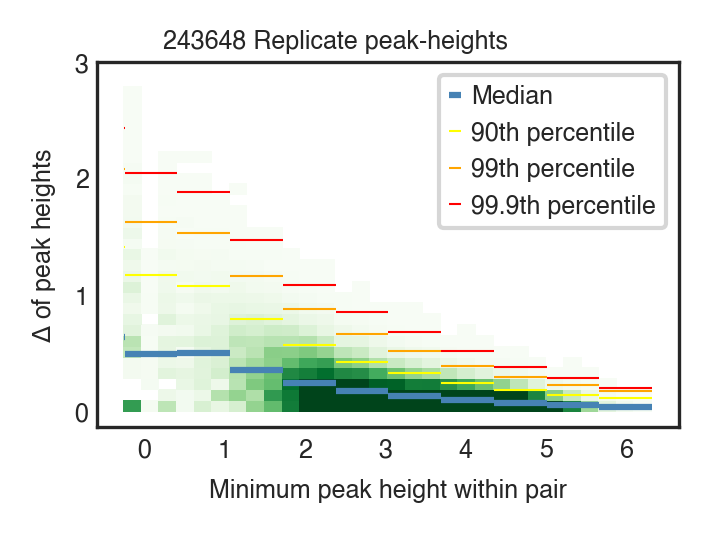

In [47]:
from matplotlib import collections  as mc

sns.set_style('white')
figsize=(60*mm, 45*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()
qcols = {0.5:'steelblue', 0.9:'yellow', 0.99:'orange', 0.999:'red'}
for quant in qcols.keys():
    diffs = mindiff_df.groupby('Cut').quantile(quant).Diff
    lines = [[(cut.left, diffs[cut]), (cut.right, diffs[cut])] for cut in cuts]
    if quant == 0.5:
        label = 'Median'
        lw = 1.5
    else:
        if quant < 0.999:
            label = '{:1.0f}th percentile'.format(quant*100)
        else:
            label = '{:1.1f}th percentile'.format(quant*100)
        lw = 0.5
    lc = mc.LineCollection(lines, linewidths=lw, color=qcols[quant], label=label)
    ax.add_collection(lc)
ax.legend()    

sns.histplot(x='min_value', y='Diff', data=mindiff_df, bins=30, pmax=0.5, 
             cmap='Greens', cbar=False)


plt.suptitle('{} Replicate peak-heights'.format(len(mindiff_df)))
ax.set_xlabel('Minimum peak height within pair')
ax.set_ylabel('$\Delta$ of peak heights')
ax.set_xticks([x + 0.25 for x in [0,1,2,3,4,5,6]])
ax.set_xticklabels(['0','1','2','3','4','5','6'], y=0.05)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['0','1','2','3'], x=0.035)

set_size(fig, figsize)
plt.savefig("Panels/Diff_dist.pdf", bbox_inches='tight')

plt.show()

The "quality_p" column is very low (close to zero) when the peak height difference is very high when looking at one of the replicate pairs.  We might exclude those with quality_p < 0.1, for quality control purposes.

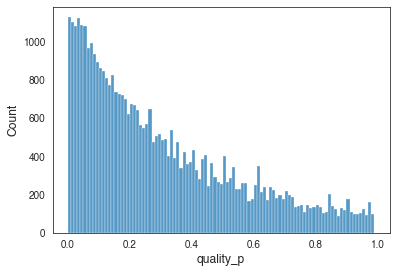

In [48]:
desetfontsize()
sns.histplot(ATAC_data.var.quality_p, bins=np.arange(0,1,0.01))
plt.show()

Note that the distribution of quality p-values is not flat (as one would expect for p-values), since we are taking the minimum p-value among 6 (one for each of the six replicate pairs).

We perform similar analysis to say whether a peak exhibits variability between replicate clones.  The following few cells just explain why the adjustment by 11 is appropriate, a multiple-comparison adjustment of sorts.

In [49]:
exp_array = np.random.exponential(1,10000) # A random array, to make a point.

In [50]:
diff = np.zeros(10000)
for j in range(10000):
    choices = np.random.choice(exp_array,2)
    diff[j] = choices.max() - choices.min()

In [51]:
diff_twelve = np.zeros(10000)
for j in range(10000):
    choices = np.random.choice(exp_array,12)
    diff_twelve[j] = choices.max() - choices.min()

In [52]:
pcut = 0.005

In [53]:
np.quantile(diff_twelve, 1 - (pcut*11)) # Adjust by 11!

5.112038009849323

In [54]:
np.quantile(diff, 1 - pcut) # Should match above, roughly.

5.308311778306327

In [55]:
ATACR_mins = ATACR_data.to_df().min()
ATACR_diffs = ATACR_data.to_df().max() - ATACR_mins

peak_mindiffs = pd.DataFrame(ATACR_mins, columns=['min_value'])
peak_mindiffs['Diff'] = ATACR_diffs
peak_mindiffs['Cut'] = pd.cut(peak_mindiffs.min_value, bins=bins)

p_df = {}

ATAC_data.var['clonal_p'] = 1.0

for cut in cuts:
    p_df[cut] = peak_mindiffs[peak_mindiffs['Cut'] == cut].copy()
    diff_df[cut] 
    p_df[cut]['ss'] = np.searchsorted(diff_df[cut], p_df[cut].Diff)
    num_samps = len(diff_df[cut])
    p_df[cut]['p_val'] = np.clip(11 * (1 - (p_df[cut]['ss'] / (1+num_samps))),0,1) 
    # 11 is the appropriate adjustment here.
    cp_series = p_df[cut].p_val
    ATAC_data.var.loc[cp_series.index, 'clonal_p'] = cp_series
    
ATAC_data.var


PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_77062  Interval_77062   9  115080094  ENSG00000119314      PTBP3   
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_33832  Interval_33832  19    1672563             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_48454  Interval_48454   3   27493603  ENSG00000033867     SLC4A7   
...                        ...  ..        ...              ...        ...   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_58433  Interval_58433   5   54298635  ENSG00000164283       ESM1   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   
Interval_17712  Interval_17712  12   96890243  ENSG00000188596   C12orf55   

                       itype          mid      start  quality_p  clonal_p  
PeakID                                                                     
Interval_77062        intron  115079731.5  115079369   0.152552  0.045662  
Interval_51938      Intergen  156852750.0  156852601   0.028703  0.000815  
Interval_33832      Intergen    1672247.0    1671931   0.029762  0.115377  
Interval_13433  promoter-TSS   82997180.5   82996620   0.010913  0.010109  
Interval_48454        intron   27493042.5   27492482   0.673157  0.540247  
...                      ...          ...        ...        ...       ...  
Interval_28417  promoter-TSS   88729670.5   88728987   0.032045  0.115768  
Interval_58433        intron   54298297.0   54297959   0.664901  0.145547  
Interval_45676          exon   35310572.5   35310208   0.064673  0.006693  
Interval_8387   promoter-TSS   33623619.5   33622581   0.067399  0.000257  
Interval_17712        intron   96889859.5   96889476   0.062587  0.136735  

[40608 rows x 10 columns]

In [56]:
ATACR_data.to_df()

PeakID       Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
Sample_name                                                                   
P9855_2085         2.220971        2.315422        2.116660        5.671244   
P9855_2093         2.574305        2.743844        2.183737        5.564601   
P9855_2101         2.335525        2.683983        2.465641        5.688357   
P9855_2102         2.405284        3.251001        2.472925        5.707511   
P9855_2110         2.244406        1.836056        1.836056        5.708737   
P9855_2111         3.193007        2.102691        2.843361        5.701477   
P9855_2104         1.966361        1.506567        1.684364        5.644652   
P9855_2112         2.089187        2.495113        2.207124        5.422726   
P9855_2089         2.349192        1.845438        2.404186        5.449306   
P9855_2090         2.764788        1.938780        2.645507        5.587162   
P9855_2091         2.610464        2.833161        2.774429        5.439472   
P9855_2096         1.911073        2.905863        2.621405        5.426267   

PeakID       Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
Sample_name                                                                  
P9855_2085         2.401717        3.377605        3.313264       4.745931   
P9855_2093         1.533994        3.179393        3.153849       5.019365   
P9855_2101         1.796163        3.665038        0.890413       5.179786   
P9855_2102         2.536280        3.984053        0.574085       5.185097   
P9855_2110         2.244406        3.383287        1.836056       5.176583   
P9855_2111         1.986456        3.479647        1.307133       4.987438   
P9855_2104         1.290173        3.610647        0.000000       4.964272   
P9855_2112         1.618351        3.594341        1.106046       5.158560   
P9855_2089         1.515987        3.879200        3.382059       5.243636   
P9855_2090         1.938780        3.833457        3.569858       5.121625   
P9855_2091         2.414239        3.765365        1.078167       5.125531   
P9855_2096         2.423591        3.834274        2.078779       5.169731   

PeakID       Interval_6501  Interval_68580  ...  Interval_69022  \
Sample_name                                 ...                   
P9855_2085        4.688817        5.477601  ...        4.004826   
P9855_2093        4.815708        5.461985  ...        4.348597   
P9855_2101        4.634396        5.577959  ...        4.017701   
P9855_2102        4.518895        5.676119  ...        4.421291   
P9855_2110        5.096018        5.234419  ...        4.300684   
P9855_2111        5.041146        5.476916  ...        3.938026   
P9855_2104        4.325634        5.529636  ...        4.162033   
P9855_2112        4.554307        5.487547  ...        4.341717   
P9855_2089        4.568126        5.484337  ...        4.294054   
P9855_2090        4.448444        5.469012  ...        4.169264   
P9855_2091        3.958736        5.456172  ...        4.144042   
P9855_2096        4.164550        5.402453  ...        4.112055   

PeakID       Interval_56910  Interval_27261  Interval_76540  Interval_57434  \
Sample_name                                                                   
P9855_2085         5.825352        2.315422        2.747701        4.865391   
P9855_2093         5.625410        2.311708        3.044600        5.019365   
P9855_2101         5.707617        2.402698        2.009906        5.031943   
P9855_2102         5.745415        2.405284        2.169631        5.136153   
P9855_2110         5.789331        1.836056        2.822287        5.108843   
P9855_2111         5.771048        2.206811        3.075744        5.206758   
P9855_2104         5.772682        1.966361        2.280140        5.057832   
P9855_2112         5.624217        2.408018        0.698727        5.021691   
P9855_2089         5.731441        2.456313        2.505857        5.07

In [57]:
ATAC_data.var['max_height'] = (np.exp(ATAC_data.to_df().max()) - 1)

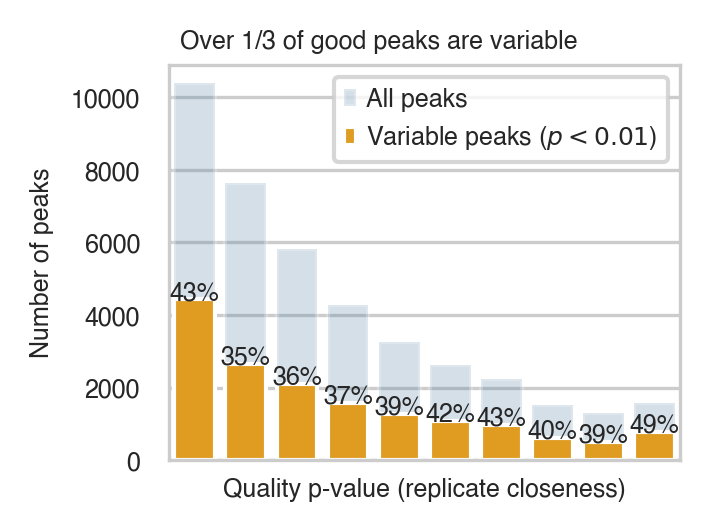

In [59]:
CQ_df = ATAC_data.var[['clonal_p','quality_p', 'max_height']]
qbins = np.arange(0,1.001,0.1)
qcuts = pd.cut(CQ_df.quality_p, qbins)
iindex = pd.IntervalIndex(qcuts.unique()) #.from_tuples([(x,x+1 - 1e-10) for x in np.arange(0,1,0.1)])
plot_df = pd.DataFrame(index = iindex)
plot_df['nsig'] = CQ_df.groupby(qcuts).apply(lambda x : (x < 0.01).sum()).clonal_p
plot_df['count'] = CQ_df.groupby(qcuts).count().clonal_p
plot_df['ratio'] = plot_df['nsig'] / plot_df['count']
plot_df['interval'] = plot_df.index#.apply(lambda x : x.left())
plot_df['mid'] = plot_df['interval'].apply(lambda x : x.mid)
plot_df = plot_df.sort_values(by='mid')

sns.set_style('whitegrid')
figsize=(60*mm, 45*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

sns.barplot(x='mid', y='count', data=plot_df, color='steelblue', alpha=0.25, ax=ax, label='All peaks')
sns.barplot(x='mid', y='nsig', data=plot_df, color='orange', label='Variable peaks ($p<0.01$)',ax=ax)
#for row in plot_df:
#    ax.text(row['interval'], row['nsig'], 'Hello')
for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['nsig']
    ratioj = plot_df.iloc[j]['ratio']
    ax.text(j,nsigj,'{:1.0%}'.format(ratioj), ha='center')

ax.set_xticks([])
ax.set_xticklabels([]) #plot_df['interval'])
ax.legend()
plt.xticks(rotation=45)

ax.set_xlabel('Quality p-value (replicate closeness)')
ax.set_ylabel('Number of peaks')
plt.suptitle('Over 1/3 of good peaks are variable')

set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

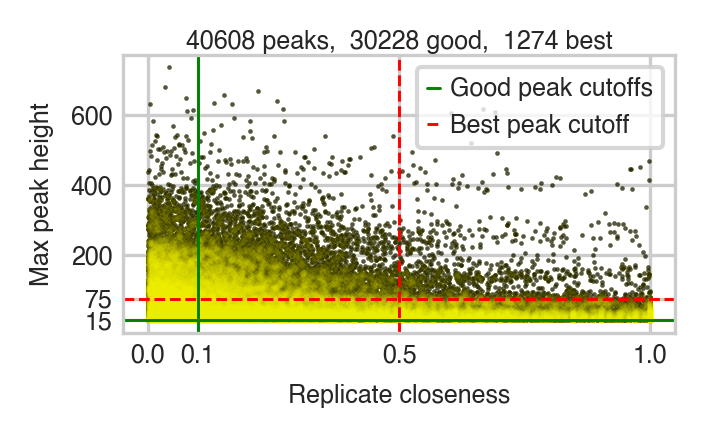

In [65]:
fig,ax = plt.subplots(1,1,figsize=(60*mm, 30*mm), dpi=300)
setfontsize()

sns.scatterplot(x='quality_p', y='max_height', data=CQ_df, s=1.0, color='k', edgecolor=None, alpha=0.7)
sns.scatterplot(x='quality_p', y='max_height', data=CQ_df, s=2.0, color='yellow', edgecolor=None, alpha=0.05)

q_cutoff = 0.5
h_cutoff = 75
best_peaks = CQ_df[(CQ_df['quality_p'] > q_cutoff) & (CQ_df['max_height'] > h_cutoff)].index

good_peaks = CQ_df[(CQ_df['quality_p'] > 0.1) & (CQ_df['max_height'] > 15)].index

ax.axhline(15, color='green', linewidth=0.7, linestyle='-', label='Good peak cutoffs')
ax.axvline(0.1, color='green', linewidth=0.7, linestyle='-')

ax.axhline(75, color='red', linewidth=0.7, linestyle='--', label='Best peak cutoff')
ax.axvline(q_cutoff, color='red', linewidth=0.7, linestyle='--')

ax.legend()
ax.set_yticks([15,75,200,400,600])
ax.set_xticks([0,0.1,0.5,1.0])

ax.tick_params(axis='both', pad=-1)

ax.set_xlabel('Replicate closeness')
ax.set_ylabel('Max peak height')

#ax.text(0.8, 500, '{} best peaks'.format(len(best_peaks)), ha='center')

plt.suptitle('{} peaks,  {} good,  {} best'.format(len(CQ_df), len(good_peaks), len(best_peaks)),x=0.57)
plt.show()

In [66]:
CQ_df.loc[best_peaks].sort_values(by='quality_p')

clonal_p  quality_p  max_height
PeakID                                         
Interval_14435  0.000399   0.500236  274.752838
Interval_38792  0.315768   0.500381  239.337738
Interval_52656  0.245908   0.500490  233.199524
Interval_77046  0.002226   0.500737  106.823257
Interval_61742  0.000309   0.501026  100.358063
...                  ...        ...         ...
Interval_48516  0.001747   1.000000   78.901146
Interval_24124  0.001747   1.000000   77.107956
Interval_79837  0.001747   1.000000   80.484787
Interval_67000  0.001747   1.000000   80.827042
Interval_10835  0.001747   1.000000   99.624023

[1274 rows x 3 columns]

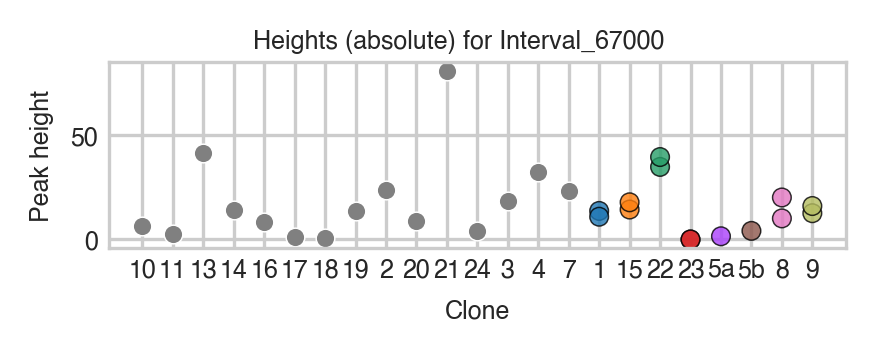

In [67]:
ATAC_plot('Interval_67000')

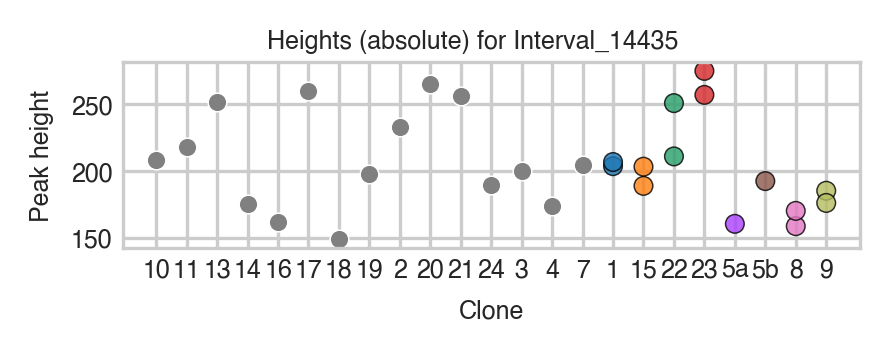

In [68]:
ATAC_plot('Interval_14435')

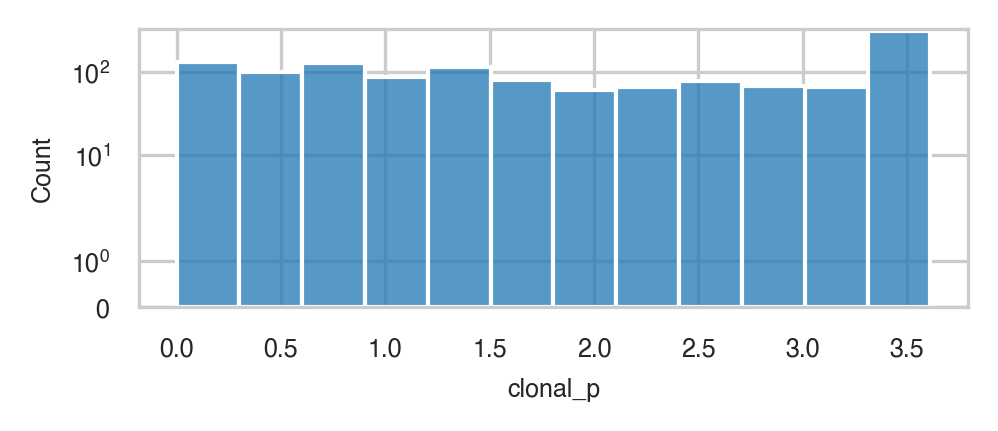

In [69]:
fig,ax = plt.subplots(1,1,figsize=(90*mm, 30*mm), dpi=300)
peaks_logp = -np.log10(CQ_df.loc[best_peaks].clonal_p)
sns.histplot(peaks_logp, ax=ax)
plt.yscale('symlog')
plt.show()

In [70]:
ATACR_data.var.itype.value_counts()

intron          15515
promoter-TSS    12372
Intergen         8433
exon             2276
TTS              2012
Name: itype, dtype: int64

In [71]:
itypes = ['Intergen','intron','promoter-TSS','exon','TTS']

In [72]:
CQ_df['itype'] = ATACR_data.var.itype
CQ_df

<ipython-input-72-77e42e960927>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CQ_df['itype'] = ATACR_data.var.itype


clonal_p  quality_p  max_height         itype
PeakID                                                       
Interval_77062  0.045662   0.152552   23.361561        intron
Interval_51938  0.000815   0.028703   30.484528      Intergen
Interval_33832  0.115377   0.029762   16.173389      Intergen
Interval_13433  0.010109   0.010913  301.374023  promoter-TSS
Interval_48454  0.540247   0.673157   21.518496        intron
...                  ...        ...         ...           ...
Interval_28417  0.115768   0.032045  136.937500  promoter-TSS
Interval_58433  0.145547   0.664901   24.210867        intron
Interval_45676  0.006693   0.064673   34.971249          exon
Interval_8387   0.000257   0.067399  118.396477  promoter-TSS
Interval_17712  0.136735   0.062587   16.138868        intron

[40608 rows x 4 columns]

Taking 30228 peaks out of 40608, based on quality cutoff of 0.1


itype  total  clonal  perc clonal
Intergen          Intergen   6676    2887     0.432445
intron              Intron  12041    5057     0.419982
promoter-TSS  Promoter-TSS   8260    2414     0.292252
exon                  Exon   1659     609     0.367089
TTS                    TTS   1592     612     0.384422

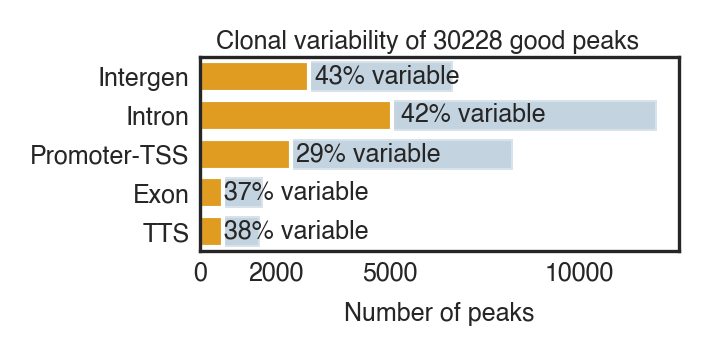

In [73]:
CQ_df_good = CQ_df[CQ_df.quality_p > 0.1]
print('Taking {} peaks out of {}, based on quality cutoff of 0.1'.format(len(CQ_df_good), len(CQ_df)))
plot_df_totals = CQ_df_good.itype.value_counts()
plot_df_clonal = CQ_df_good[CQ_df_good.clonal_p < 0.01].itype.value_counts()

plot_df = pd.DataFrame(index = plot_df_totals.index)
plot_df['itype'] = [s[0].upper() + s[1:] for s in plot_df.index]
plot_df['total'] = plot_df_totals
plot_df['clonal'] = plot_df_clonal
plot_df['perc clonal'] = plot_df['clonal'] / plot_df['total']
plot_df = plot_df.loc[itypes]
display(plot_df)

sns.set_style('white')
figsize=(60*mm, 30*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)

setfontsize()

sns.barplot(y='itype', x='total', data=plot_df, 
            color='steelblue', edgecolor=None, alpha=0.35, ax=ax, label='Num. peaks',
            orient='h')
sns.barplot(y='itype', x='clonal', data=plot_df, 
                color='orange', label='Variable peaks ($p<0.01$)',
                orient='h', ax=ax)

for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['clonal']
    ratioj = plot_df.iloc[j]['perc clonal']
    ax.text(nsigj*1.05,j,'{:1.0%} variable'.format(ratioj), ha='left', va='center')
        
ax.set_xlabel('Number of peaks')
ax.set_ylabel('')
ax.set_xticks([0,2000,5000,10000])
ax.tick_params(axis='both', pad=-1)
plt.suptitle('Clonal variability of {} good peaks'.format(plot_df.total.sum()), y=1.02, x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

Taking 1274 best peaks out of 40608


itype  total  clonal  perc clonal
Intergen          Intergen    197     138     0.700508
intron              Intron    369     225     0.609756
promoter-TSS  Promoter-TSS    594     198     0.333333
exon                  Exon     76      30     0.394737
TTS                    TTS     38      15     0.394737

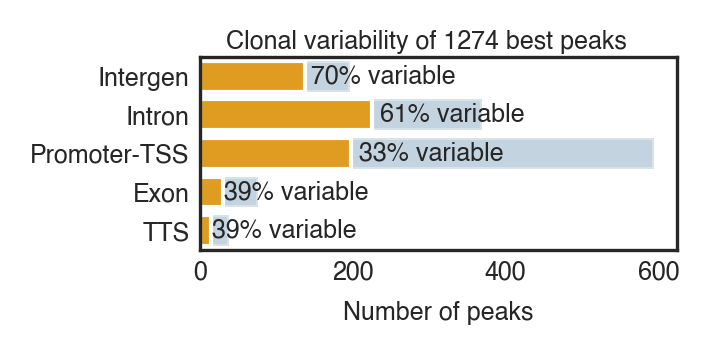

In [74]:
CQ_df_good = CQ_df.loc[best_peaks].sort_values(by='itype')
print('Taking {} best peaks out of {}'.format(len(CQ_df_good), len(CQ_df)))
plot_df_totals = CQ_df_good.itype.value_counts()
plot_df_clonal = CQ_df_good[CQ_df_good.clonal_p < 0.01].itype.value_counts()

plot_df = pd.DataFrame(index = plot_df_totals.index)
plot_df['itype'] = [s[0].upper() + s[1:] for s in plot_df.index]
plot_df['total'] = plot_df_totals
plot_df['clonal'] = plot_df_clonal
plot_df['perc clonal'] = plot_df['clonal'] / plot_df['total']
plot_df = plot_df.loc[itypes]
display(plot_df)

sns.set_style('white')
figsize=(60*mm, 30*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)

setfontsize()

sns.barplot(y='itype', x='total', data=plot_df, 
            color='steelblue', edgecolor=None, alpha=0.35, ax=ax, label='Num. peaks',
            orient='h')
sns.barplot(y='itype', x='clonal', data=plot_df, 
                color='orange', label='Variable peaks ($p<0.01$)',
                orient='h', ax=ax)

for j in range(len(plot_df)):
    nsigj = plot_df.iloc[j]['clonal']
    ratioj = plot_df.iloc[j]['perc clonal']
    ax.text(nsigj*1.05,j,'{:1.0%} variable'.format(ratioj), ha='left', va='center')
        
ax.set_xlabel('Number of peaks')
ax.set_ylabel('')
#ax.set_xticks([0,2000,5000,10000])
ax.tick_params(axis='both', pad=-1)
plt.suptitle('Clonal variability of {} best peaks'.format(plot_df.total.sum()), y=1.02, x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

# Clonal peaks near clonal genes

In [75]:

ATAC_genes = ATAC_data.var.loc[good_peaks].in_gene.unique() # Look only at genes with peaks annotated
ATAC_genes = [gene for gene in ATAC_genes if gene in adata.var_names] # Look only at genes in gene expression matrix

adata.var['Expressed'] = ((adata.to_df() > np.log1p(10)).sum() > 3) # Look only at expressed genes.
ATAC_genes = [gene for gene in ATAC_genes if adata.var.Expressed[gene]] # Look only at expressed genes.

len(ATAC_genes)

6246

In [76]:
len(good_peaks)

30228

In [77]:
pg_clonal_df = pd.DataFrame(index=ATAC_genes)
pg_clonal_df['Nearby peak variability'] = CQ_df.loc[good_peaks].groupby(ATAC_data.var.in_gene)['clonal_p'].min()
pg_clonal_df['Gene clonality'] = adata.var.loc[ATAC_genes].F_pval
display(pg_clonal_df)

Nearby peak variability  Gene clonality
PTBP3                  0.045662        0.997122
SLC4A7                 0.075831        0.532006
ZFP90                  0.018765        0.041351
LSM1                   0.042715        0.026119
CAMTA1                 0.000257        0.737613
...                         ...             ...
PON2                   0.000257        0.501891
TUBE1                  0.005407        0.970713
HOXB2                  0.001747        0.000011
MTF1                   0.008733        0.339596
AASDH                  0.287523        0.636534

[6246 rows x 2 columns]

In [87]:
for g_cut in [1, 0.05, 0.01, 0.001, 0.0001]:
    g_df = pg_clonal_df[pg_clonal_df['Gene clonality'] < g_cut]['Nearby peak variability']
    num_withclonalpeaks = (g_df < 0.01).sum()
    num_total = len(g_df)
    print('Among {} genes with clonality p < {}, '
          '{:1.2%} have a clonally variable peak nearby.'.format(num_total, g_cut, num_withclonalpeaks / num_total))


Among 6246 genes with clonality p < 1, 42.75% have a clonally variable peak nearby.
Among 1273 genes with clonality p < 0.05, 45.09% have a clonally variable peak nearby.
Among 614 genes with clonality p < 0.01, 50.33% have a clonally variable peak nearby.
Among 273 genes with clonality p < 0.001, 57.88% have a clonally variable peak nearby.
Among 127 genes with clonality p < 0.0001, 64.57% have a clonally variable peak nearby.


In [88]:
gene_peaks = [peak for peak in good_peaks if ATAC_data.var.in_gene[peak] in adata.var_names]
gene_peaks = [peak for peak in gene_peaks if adata.var.Expressed[ATAC_data.var.in_gene[peak]]]

len(gene_peaks) # peaks which are annotated to an expressed gene.

13518

In [89]:
CQG_df = CQ_df.loc[gene_peaks].copy()
CQG_df['gene'] = ATAC_data.var.in_gene
CQG_df['gene_clonality'] = 1.0
for peak in CQG_df.index:
    gene = CQG_df.loc[peak, 'gene']
    CQG_df.loc[peak, 'gene_clonality'] = adata.var.loc[gene, 'F_pval']
CQG_df

clonal_p  quality_p  max_height         itype    gene  \
PeakID                                                                  
Interval_77062  0.045662   0.152552   23.361561        intron   PTBP3   
Interval_48454  0.540247   0.673157   21.518496        intron  SLC4A7   
Interval_27763  0.024386   0.107762   55.443855  promoter-TSS   ZFP90   
Interval_72287  0.042715   0.385883  226.685486  promoter-TSS    LSM1   
Interval_267    0.001747   0.506510   15.800482        intron  CAMTA1   
...                  ...        ...         ...           ...     ...   
Interval_12696  0.020107   0.333671  107.603867  promoter-TSS   VPS51   
Interval_33653  0.192194   0.462013   24.210867        intron  NFATC1   
Interval_54425  0.287523   0.339598  123.744461  promoter-TSS   AASDH   
Interval_26382  0.041568   0.886417   41.243774           TTS   SOCS1   
Interval_33873  0.405540   0.149024   88.259521        intron   MOB3A   

                gene_clonality  
PeakID                          
Interval_77062        0.997122  
Interval_48454        0.532006  
Interval_27763        0.041351  
Interval_72287        0.026119  
Interval_267          0.737613  
...                        ...  
Interval_12696        0.410919  
Interval_33653        0.788024  
Interval_54425        0.636534  
Interval_26382        0.200177  
Interval_33873        0.024751  

[13518 rows x 6 columns]

In [90]:
CQG_df.to_csv('Peaks_Genes_Clonalityscores.csv')

## Check for batch effects in best peaks

In [104]:
ATAC_good = ATAC_data[:, good_peaks]
ATAC_good_z = (ATAC_good.to_df() - ATAC_good.to_df().mean()) / ATAC_good.to_df().std()
ATAC_good_z = ATAC_good_z[ATAC_good_z.columns.sort_values()]
ATAC_good_zsum = pd.DataFrame(ATAC_good_z.sum(axis=1))
ATAC_good_zsum.columns = ['zsum']
ATAC_good_zsum['z_adj'] = ATAC_good_zsum['zsum'] / ATAC_good_z.shape[1]
ATAC_good_zsum['clone'] = ATAC_data.obs.ATAC_clone
ATAC_good_zsum['cell_number'] = ATAC_good.obs['Cell Number']
ATAC_good_zsum

zsum     z_adj  clone  cell_number
Sample_name                                           
P9855_2085    912.113647  0.030174   1_R1       1000.0
P9855_2093   1684.685303  0.055733   1_R2       1000.0
P9855_2092   -904.439453 -0.029921  10_R1        350.0
P9855_2097  -3338.751953 -0.110452  11_R1        269.0
P9855_2099  -1384.834839 -0.045813  13_R1        500.0
P9855_2100  -1149.896851 -0.038041  14_R1        500.0
P9855_2101   -546.817566 -0.018090  15_R1       1000.0
P9855_2102   -952.646973 -0.031515  15_R2       1000.0
P9855_2103  -2243.503662 -0.074219  16_R1        700.0
P9855_2106  -1921.804932 -0.063577  17_R1       1000.0
P9855_2105    901.384277  0.029820  18_R1       1000.0
P9855_2107   1495.091919  0.049460  19_R1       1000.0
P9855_2086    542.988647  0.017963   2_R1        705.0
P9855_2108    582.218506  0.019261  20_R1        918.0
P9855_2109   1373.105225  0.045425  21_R1       1000.0
P9855_2110    248.944443  0.008236  22_R1       1000.0
P9855_2111    814.212891  0.026936  22_R2       1000.0
P9855_2104    -67.270988 -0.002225  23_R1       1000.0
P9855_2112    108.677742  0.003595  23_R2       1000.0
P9855_2113  -1094.993652 -0.036224  24_R1       1000.0
P9855_2094  -1098.732910 -0.036348   3_R1        506.0
P9855_2087    926.436951  0.030648   4_R1        410.0
P9855_2098    712.642517  0.023576  5a_R1        500.0
P9855_2095   1173.273682  0.038814  5b_R1       1000.0
P9855_2088   -755.110962 -0.024981   7_R1       1000.0
P9855_2089    252.832214  0.008364   8_R1       1000.0
P9855_2090    300.654633  0.009946   8_R2       1000.0
P9855_2091   1665.355469  0.055093   9_R1       1000.0
P9855_2096   1764.240601  0.058364   9_R2       1000.0

# Panel:  Peak heatmap

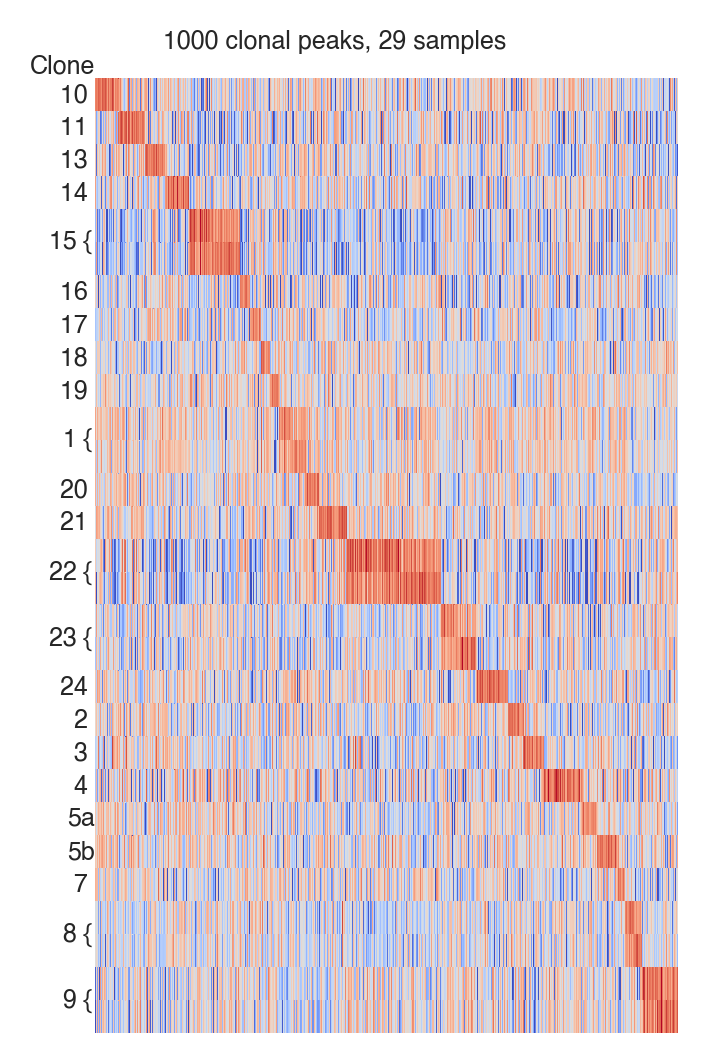

In [92]:
var_peaks = ATAC_good.var.clonal_p.sort_values()[:1000].index

plot_df = ATAC_good.to_df()[var_peaks].copy()

plot_df.index = ATAC_good.obs.ATAC_clone
plot_df.sort_index(inplace=True)

plot_df = (plot_df - plot_df.mean()) / plot_df.std()

#display(plot_df.idxmax().sort_values())

var_peaks = plot_df.idxmax().sort_values().index
plot_df = plot_df[var_peaks]

figsize=(60*mm, 90*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.heatmap(plot_df, vmin=-2.5, vmax=2.5, cmap='coolwarm', 
            xticklabels=False, yticklabels=False,
            cbar=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
for y,clone in [(11,1), (5,15), (15,22), (17,23), (26,8), (28,9)]:
    ax.text(-5,y,str(clone) + ' {', va='center', ha='right', fontsize=6)
    
for j,clone in enumerate(plot_df.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9','5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=6)
    
ax.text(-0.1,22.5,'5a', va='center', ha='right', fontsize=6)
ax.text(-0.1,23.5,'5b', va='center', ha='right', fontsize = 6)


ax.text(0.5,0,'Clone', va='bottom', ha='right', fontsize=6)
plt.suptitle('{} clonal peaks, {} samples'.format(len(var_peaks), len(plot_df)), y=0.95)
set_size(fig, figsize)
plt.savefig("Panels/PeakHeatmap.pdf", bbox_inches='tight')

plt.show()

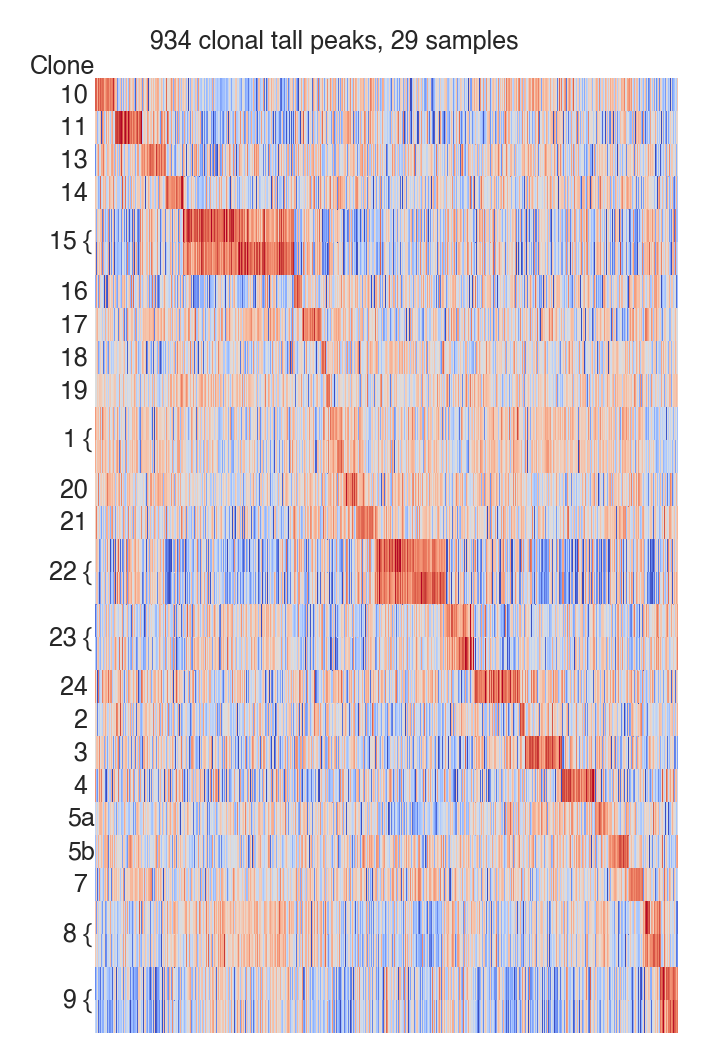

In [93]:
var_peaks = ATAC_good.var[(ATAC_good.var.clonal_p < 0.001) & (ATAC_good.var.max_height > 100) ].index

plot_df = ATAC_good.to_df()[var_peaks].copy()

plot_df.index = ATAC_good.obs.ATAC_clone
plot_df.sort_index(inplace=True)

plot_df = (plot_df - plot_df.mean()) / plot_df.std()

#display(plot_df.idxmax().sort_values())

var_peaks = plot_df.idxmax().sort_values().index
plot_df = plot_df[var_peaks]

figsize=(60*mm, 90*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.heatmap(plot_df, vmin=-2.5, vmax=2.5, cmap='coolwarm', 
            xticklabels=False, yticklabels=False,
            cbar=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
for y,clone in [(11,1), (5,15), (15,22), (17,23), (26,8), (28,9)]:
    ax.text(-5,y,str(clone) + ' {', va='center', ha='right', fontsize=6)
    
for j,clone in enumerate(plot_df.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9','5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=6)
    
ax.text(-0.1,22.5,'5a', va='center', ha='right', fontsize=6)
ax.text(-0.1,23.5,'5b', va='center', ha='right', fontsize = 6)


ax.text(0.5,0,'Clone', va='bottom', ha='right', fontsize=6)
plt.suptitle('{} clonal tall peaks, {} samples'.format(len(var_peaks), len(plot_df)), y=0.95)
set_size(fig, figsize)
plt.savefig("Panels/PeakHighHeatmap.pdf", bbox_inches='tight')

plt.show()

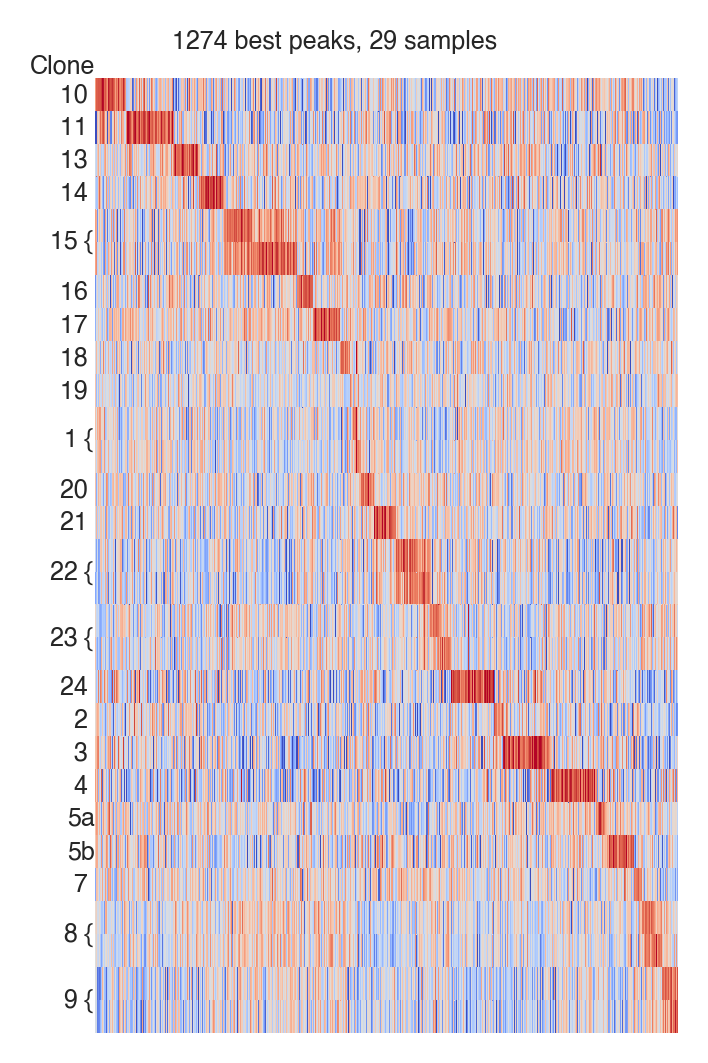

In [94]:
var_peaks = best_peaks

plot_df = ATAC_good.to_df()[var_peaks].copy()

plot_df.index = ATAC_good.obs.ATAC_clone
plot_df.sort_index(inplace=True)

plot_df = (plot_df - plot_df.mean()) / plot_df.std()

#display(plot_df.idxmax().sort_values())

var_peaks = plot_df.idxmax().sort_values().index
plot_df = plot_df[var_peaks]

figsize=(60*mm, 90*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.heatmap(plot_df, vmin=-2.5, vmax=2.5, cmap='coolwarm', 
            xticklabels=False, yticklabels=False,
            cbar=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
for y,clone in [(11,1), (5,15), (15,22), (17,23), (26,8), (28,9)]:
    ax.text(-5,y,str(clone) + ' {', va='center', ha='right', fontsize=6)
    
for j,clone in enumerate(plot_df.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9','5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=6)
    
ax.text(-0.1,22.5,'5a', va='center', ha='right', fontsize=6)
ax.text(-0.1,23.5,'5b', va='center', ha='right', fontsize = 6)


ax.text(0.5,0,'Clone', va='bottom', ha='right', fontsize=6)
plt.suptitle('{} best peaks, {} samples'.format(len(var_peaks), len(plot_df)), y=0.95)
set_size(fig, figsize)
plt.savefig("Panels/PeakBestHeatmap.pdf", bbox_inches='tight')

plt.show()

Here are the genes near the most clonal peaks, in order.

In [95]:
var_peaks = ATAC_good.var.clonal_p.sort_values()[:1000].index

near_genes = ATACR_data.var.loc[plot_df.columns].in_gene
near_genes = near_genes[near_genes != 'nan']
near_genes = near_genes[near_genes.isin(adata.var_names)]
near_genes = near_genes.values
near_genes

array(['CSNK1G3', 'SYNE1', 'AFAP1L2', 'TNFAIP3', 'ERI1', 'GOLPH3L',
       'GALK2', 'AXIN1', 'DMTN', 'NR3C1', 'GOLGA5', 'LAYN', 'LOH12CR1',
       'MAPRE2', 'ZNF438', 'WHSC1L1', 'PSKH1', 'YLPM1', 'POLR2J', 'KLRD1',
       'FPGS', 'CDC42SE2', 'VAV3', 'LY75', 'SIK3', 'KLRD1', 'NCOA2',
       'PPIP5K2', 'E4F1', 'CHST11', 'TNPO1', 'MAL', 'CD200R1', 'ZNRF2',
       'NOD2', 'CSTF2', 'ATF2', 'RNF216', 'ZCWPW1', 'RASA2', 'CAMTA1',
       'PDGFA', 'FAM50B', 'YARS2', 'SNORD3A', 'ZFP30', 'HELB', 'FDFT1',
       'EDARADD', 'MOV10', 'MT2A', 'ARID5B', 'AL121914.1', 'RPF2',
       'MAST3', 'ZNF706', 'NAA40', 'CARS', 'RP11-114H23.1', 'ODF2L',
       'POLR3E', 'CUL3', 'SPATA2', 'SCAF4', 'RAB22A', 'TGOLN2', 'DIXDC1',
       'ISOC1', 'RPS6KA4', 'RNF145', 'TRNAU1AP', 'UBC', 'CNIH4', 'ZDHHC5',
       'RBM15B', 'KIAA0319L', 'PIGG', 'ATG16L1', 'PCSK7', 'RP11-146I2.1',
       'RAB11FIP1', 'ITGAL', 'CENPE', 'LAPTM5', 'ARHGAP26', 'RGS14',
       'PHF20L1', 'RP11-431M7.3', 'SMARCA2', 'STAT4', 'RP11-582J16.4',
  

# Peak-gene correlations

Now we create a giant correlation matrix -- one for each chromosome -- between gene expression (clonal average) and peak height (clonal average), for all genes and peaks on that chromosome.  We only use the "good clones" (16 out of 24 clones) found in preprocessing, when computing these correlations.  We also restrict to "good" peaks, where replicates have close peak heights.

In [96]:
genes = adata.var_names
genes

Index(['WASH7P', 'AL627309.1', 'RP11-34P13.13', 'MTND2P28', 'hsa-mir-6723',
       'RP5-857K21.7', 'MTATP8P1', 'MTATP6P1', 'RP5-857K21.11',
       'RP11-206L10.9',
       ...
       'VBP1-1', 'RAB39B-1', 'TMLHE-1', 'VAMP7', 'IL9R', 'EIF4A1P2', 'SRIP3',
       'AC010970.2', 'RNA5-8SP6', 'PSMA6P1'],
      dtype='object', name='gene_name', length=11881)

In [97]:
peaks = ATAC_good.var_names
peaks

Index(['Interval_77062', 'Interval_48454', 'Interval_27763', 'Interval_53540',
       'Interval_6501', 'Interval_59219', 'Interval_72287', 'Interval_7590',
       'Interval_267', 'Interval_49328',
       ...
       'Interval_42547', 'Interval_33873', 'Interval_27906', 'Interval_78898',
       'Interval_2270', 'Interval_27499', 'Interval_16060', 'Interval_27261',
       'Interval_57434', 'Interval_58433'],
      dtype='object', name='PeakID', length=30228)

In [98]:
chromes = [str(j) for j in range(1,23)] + ['X','Y']
print(chromes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']


For each of the good clones, we create dataframes of the clonal averages for gene expression and peak height.

In [99]:
test_clones = adata.obs[adata.obs['Good clone'] == True].Clone_ID.unique()
test_clones = [clone for clone in test_clones if clone in ATAC_data.obs.Clone_ID.unique()]

pd_peak = ATAC_data[ATAC_data.obs['Clone_ID'].isin(test_clones)]
pd_gene = adata[adata.obs['Clone_ID'].isin(test_clones)]

gene_clonal = pd_gene.to_df().groupby(pd_gene.obs.Clone_ID).mean()
peak_clonal = pd_peak.to_df().groupby(pd_peak.obs.Clone_ID).mean()

In [100]:
gene_clonal

gene_name    WASH7P  AL627309.1  RP11-34P13.13  MTND2P28  hsa-mir-6723  \
Clone_ID                                                                 
P1_A03     0.618283    0.945561       1.025549  3.235500      2.083895   
P1_A05     0.000000    0.000000       0.000000  2.712187      1.456248   
P1_A08     0.000000    0.000000       0.000000  3.053064      1.616868   
P1_A12     0.190624    0.000000       0.000000  3.038536      1.861662   
P1_B10     0.000000    0.000000       0.000000  3.115203      2.256257   
P1_C11     0.195251    0.000000       0.000000  2.748705      1.980835   
P1_D09     0.000000    0.000000       0.000000  2.579358      1.508479   
P1_F10     0.000000    0.000000       0.000000  2.925440      1.696129   
P1_H01     0.000000    0.000000       0.000000  3.109386      1.951495   
P1_H10     0.000000    0.000000       0.000000  2.253430      1.487985   
P2_A04     0.577054    0.203521       0.000000  3.239484      1.336314   
P2_B11     0.000000    0.000000       0.000000  3.310599      2.166867   
P2_G01     0.000000    0.000000       0.000000  3.007948      0.545674   
P2_G09     0.000000    0.000000       0.000000  2.711262      1.457363   
P2_H04     0.000000    0.000000       0.000000  2.317622      1.713998   
P2_H05     0.000000    0.000000       0.000000  2.048599      0.480044   

gene_name  RP5-857K21.7  MTATP8P1  MTATP6P1  RP5-857K21.11  RP11-206L10.9  \
Clone_ID                                                                    
P1_A03         0.750680  0.459195  5.755206       0.250811       0.000000   
P1_A05         0.407113  0.000000  5.386560       0.229657       0.000000   
P1_A08         0.697563  0.414321  5.804655       0.227296       0.000000   
P1_A12         0.000000  0.472903  5.478726       0.000000       0.888312   
P1_B10         0.699134  0.425098  5.694868       0.000000       0.000000   
P1_C11         0.540095  0.000000  5.840600       0.252954       0.000000   
P1_D09         0.527772  0.454545  5.743250       0.213638       0.949451   
P1_F10         0.626677  0.000000  5.868581       0.273484       0.000000   
P1_H01         0.371031  0.505814  5.827295       0.000000       0.000000   
P1_H10         0.211150  0.885398  5.617558       0.000000       0.000000   
P2_A04         0.000000  0.000000  5.568577       0.234326       0.957820   
P2_B11         0.973400  0.000000  5.709068       0.615366       1.189926   
P2_G01         0.000000  0.469179  4.773428       0.257901       0.000000   
P2_G09         0.747793  0.461915  5.398914       0.000000       0.000000   
P2_H04         0.343014  0.477543  5.297565       0.299365       0.352106   
P2_H05         0.387329  0.000000  4.366103       0.000000       0.000000   

gene_name  ...    VBP1-1  RAB39B-1   TMLHE-1     VAMP7      IL9R  EIF4A1P2  \
Clone_ID   ...                                                               
P1_A03     ...  3.447827  0.000000  0.000000  0.000000  0.000000  0.000000   
P1_A05     ...  4.643641  0.000000  1.078488  2.631706  0.000000  0.135689   
P1_A08     ...  4.286690  0.000000  2.964008  0.000000  0.000000  0.000000   
P1_A12     ...  4.638396  0.864891  3.823669  2.864282  0.000000  0.230631   
P1_B10     ...  2.665425  0.772898  3.731382  2.401685  0.000000  0.325636   
P1_C11     ...  3.885841  0.892146  1.207822  2.805009  2.455279  0.105118   
P1_D09     ...  4.358072  0.686928  1.850092  2.886688  0.000000  0.248796   
P1_F10     ...  4.180732  0.902162  0.000000  1.396651  1.221312  0.000000   
P1_H01     ...  4.212268  0.000000  1.494714  1.758571  0.000000  0.138110   
P1_H10     ...  4.177901  0.000000  0.762414  1.625854  0.302063  0.000000   
P2_A04     ...  2.828667  0.000000  2.955809  0.000000  0.000000  0.000000   
P2_B11     ...  4.456919  0.000000  4.221027  2.097311  0.000000  0.121822   
P2_G01     ...  0.000000  0.000000  1.927383  0.352053  0.000000  0.155642   
P2_G09     ...  4.849241  2.137543  0.000000  2.615978  0.000000  0.000000   
P2_H04     ...  2.516015  1.1694

In [101]:
peak_clonal

PeakID    Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
Clone_ID                                                                   
P1_A03          2.397638        2.529633        2.150198        5.617923   
P1_A05          2.717578        1.972389        2.088377        5.437860   
P1_A08          2.928915        2.287843        1.691356        5.560565   
P1_A12          2.225148        2.426444        2.426444        5.683740   
P1_B10          2.987230        1.853198        2.670728        5.436592   
P1_C11          2.751107        2.591159        1.970270        5.644123   
P1_D09          2.464640        3.449496        2.299183        5.493403   
P1_F10          2.149178        2.824024        2.065458        5.619921   
P1_H01          2.556990        1.892109        2.524847        5.518234   
P1_H10          2.260768        2.869512        2.697917        5.432869   
P2_A04          2.370404        2.967492        2.469283        5.697934   
P2_B11          2.246812        0.000000        2.714423        5.558466   
P2_G01          1.948509        2.775430        2.623850        5.629741   
P2_G09          2.707259        2.128885        1.243721        5.444118   
P2_H04          2.718706        1.969373        2.339709        5.705107   
P2_H05          2.027774        2.000840        1.945744        5.533689   

PeakID    Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
Clone_ID                                                                  
P1_A03          1.967855        3.278499        3.233557       4.882648   
P1_A05          0.633384        3.517708        2.451669       5.108484   
P1_A08          2.287843        3.709698        3.762476       5.194549   
P1_A12          1.119627        3.585825        3.326052       5.100070   
P1_B10          2.205004        3.504991        3.114438       5.243369   
P1_C11          1.856460        3.638525        3.083403       5.247215   
P1_D09          3.114337        3.700081        3.607240       5.154146   
P1_F10          1.974084        3.443976        3.507894       5.158548   
P1_H01          1.727383        3.856328        3.475958       5.182631   
P1_H10          2.418915        3.799819        1.578473       5.147631   
P2_A04          2.166221        3.824545        0.732249       5.182442   
P2_B11          2.246812        4.033247        3.964330       5.195662   
P2_G01          1.707229        3.436920        2.986031       5.123996   
P2_G09          1.243721        3.869145        2.991982       5.031900   
P2_H04          2.115431        3.431467        1.571595       5.082010   
P2_H05          1.454262        3.602494        0.553023       5.061416   

PeakID    Interval_6501  Interval_68580  ...  Interval_69022  Interval_56910  \
Clone_ID                                 ...                                   
P1_A03         4.752263        5.469793  ...        4.176711        5.725381   
P1_A05         4.493093        5.533124  ...        4.421364        5.751973   
P1_A08         4.519068        5.543390  ...        3.949484        5.814805   
P1_A12         4.740612        5.524294  ...        4.205272        5.802704   
P1_B10         4.985421        5.780162  ...        4.261869        5.647071   
P1_C11         4.287120        5.610814  ...        4.035187        5.825854   
P1_D09         4.445949        5.408775  ...        4.487143        5.763301   
P1_F10         4.699069        5.427788  ...        4.216893        5.746419   
P1_H01         4.508285        5.476674  ...        4.231659        5.612613   
P1_H10         4.061644        5.429313  ...        4.128048        5.493102   
P2_A04         4.576645        5.627039  ...        4.219496        5.726516   
P2_B11         4.471122        5.540189  ...        4.345335        5.734086   
P2_G01         4.585413        5.571364  ...        4.251483        5.548196   
P2_G09         4.856232        5.418911  ...        4.402289        5.577108   


The following function creates the giant correlation matrix.

In [105]:
def pg_corr(chrome, method='pearson'):
    pd_peak = peak_clonal.loc[:,ATAC_data.var.chr == chrome]
    pd_gene = gene_clonal.loc[:,adata.var.chr == chrome]
    
    print('Making corr. matrix for chromosome {} with {} peaks and {} genes.'.format(
        chrome, pd_peak.shape[1], pd_gene.shape[1]))

    A = pd_peak
    E = pd_gene
    
    if method == 'spearman':
        A = A.rank()
        E = E.rank()
    Az = (A - A.mean())
    Ez = (E - E.mean())
    C = Az.T.dot(Ez).div(len(A)).div(Ez.std(ddof=0)).div(Az.std(ddof=0), axis=0)
    return C.sort_index()

It will take just a few seconds to make the correlation matrices for every chromosome.

In [106]:
pg_corrs = {}
for chrome in chromes:
    pg_corrs[chrome] = pg_corr(chrome).fillna(0)

Making corr. matrix for chromosome 1 with 3887 peaks and 1248 genes.
Making corr. matrix for chromosome 2 with 3265 peaks and 802 genes.
Making corr. matrix for chromosome 3 with 2558 peaks and 681 genes.
Making corr. matrix for chromosome 4 with 1574 peaks and 429 genes.
Making corr. matrix for chromosome 5 with 2005 peaks and 550 genes.
Making corr. matrix for chromosome 6 with 2556 peaks and 648 genes.
Making corr. matrix for chromosome 7 with 1977 peaks and 569 genes.
Making corr. matrix for chromosome 8 with 1623 peaks and 380 genes.
Making corr. matrix for chromosome 9 with 1624 peaks and 465 genes.
Making corr. matrix for chromosome 10 with 1849 peaks and 460 genes.
Making corr. matrix for chromosome 11 with 1995 peaks and 627 genes.
Making corr. matrix for chromosome 12 with 2103 peaks and 666 genes.
Making corr. matrix for chromosome 13 with 893 peaks and 210 genes.
Making corr. matrix for chromosome 14 with 1392 peaks and 388 genes.
Making corr. matrix for chromosome 15 with 

# Looking at correlations within windows.

We look at peaks within a window around each gene.  For a close-up look, we consider peaks within 50kb upstream of the TSS, together with the region between the gene start and end sites.  (We add a little 5kb wiggle-room too.)  For a broader look, we look at peaks within 500kb of the TSS.  The following function finds the peaks within such windows around a given gene.

In [107]:
def peaks_near(gene, window=50000, tol = 5000.0, method='TSSUp'):
    gene_chrome = adata.var.chr[gene]
    gene_TSS = adata.var.TSS[gene]
    gene_start = adata.var.start[gene]
    gene_end = adata.var.end[gene]
    gene_dir = adata.var.dir[gene]

    p_df = ATAC_good.var[ATAC_good.var.chr == gene_chrome]
    dist_peak_TSS = gene_dir * (gene_TSS - p_df.mid)
    if method == 'TSSCenter':
        p_range = abs(dist_peak_TSS) < window
    elif method == 'TSSUp':
        up_range = (dist_peak_TSS < window) & (dist_peak_TSS >= -tol)
        in_range = (p_df.mid > gene_start - tol) & (p_df.mid < gene_end + tol)
        p_range = up_range | in_range
    else:
        print('Method unknown.')
        return None
    p_df = p_df[p_range]
    return p_df.index

The following function adds up the coefficients of determination for all peaks within a window around a gene. 

In [108]:
def total_corr_near(gene, window=500000):
    pn = peaks_near(gene, window, method='TSSCenter')
    gene_chrome = adata.var.chr[gene]
    R_list = pg_corrs[gene_chrome][gene][pn]
    R_sq_list_pos = R_list.clip(0,1)**2
    R_sq_list_neg = R_list.clip(-1,0)**2
    R_sq_list = R_list**2
    loc_list = ATAC_good.var.loc[pn].mid - adata.var.TSS[gene]
    tcn_df = pd.DataFrame(index=pn)
    tcn_df['R_sq'] = R_sq_list
    tcn_df['R_sq_pos'] = R_sq_list_pos
    tcn_df['R_sq_neg'] = R_sq_list_neg
    tcn_df['relative_loc'] = loc_list
    tcn_df['loc_bin'] = pd.cut(loc_list, bins=np.arange(-500000,500001,5000))
    return tcn_df.drop('relative_loc', axis=1).groupby('loc_bin').sum()

In [109]:
tcn = total_corr_near('GNLY')
tcn

R_sq  R_sq_pos  R_sq_neg
loc_bin                                     
(-500000, -495000]   0.0       0.0       0.0
(-495000, -490000]   0.0       0.0       0.0
(-490000, -485000]   0.0       0.0       0.0
(-485000, -480000]   0.0       0.0       0.0
(-480000, -475000]   0.0       0.0       0.0
...                  ...       ...       ...
(475000, 480000]     0.0       0.0       0.0
(480000, 485000]     0.0       0.0       0.0
(485000, 490000]     0.0       0.0       0.0
(490000, 495000]     0.0       0.0       0.0
(495000, 500000]     0.0       0.0       0.0

[200 rows x 3 columns]

We add up the peak-correlations within a 500000bp window around every gene.  This will take a minute or two.

In [110]:
TSS_intervals = tcn.index
genes_chrome = [gene for gene in genes if adata.var.chr[gene] in chromes]

TSS_plot = pd.DataFrame(index = TSS_intervals, columns=genes_chrome)
TSS_pos_plot = pd.DataFrame(index = TSS_intervals, columns=genes_chrome)
TSS_neg_plot = pd.DataFrame(index = TSS_intervals, columns=genes_chrome)

for j,gene in enumerate(genes_chrome):
    if j%1000 == 0:
        print('{} genes complete'.format(j))
    tcn = total_corr_near(gene)
    TSS_plot[gene] = tcn.R_sq
    TSS_pos_plot[gene] = tcn.R_sq_pos
    TSS_neg_plot[gene] = tcn.R_sq_neg

0 genes complete
1000 genes complete
2000 genes complete
3000 genes complete
4000 genes complete
5000 genes complete
6000 genes complete
7000 genes complete
8000 genes complete
9000 genes complete
10000 genes complete
11000 genes complete


## Panel:  Total R^2 for peak~gene within 500kb of TSS.

In [111]:
plot_df = pd.DataFrame(TSS_plot.sum(axis=1), columns=['Total R^2'])
plot_df['x'] = np.arange(-500000,500000, 5000) + 2500
plot_df['Pos R^2'] = TSS_pos_plot.sum(axis=1)
plot_df['Neg R^2'] = TSS_neg_plot.sum(axis=1)

plot_df.head()

Total R^2       x    Pos R^2    Neg R^2
loc_bin                                                    
(-500000, -495000]  76.882715 -497500  32.755637  44.127078
(-495000, -490000]  73.042754 -492500  35.634676  37.408078
(-490000, -485000]  77.532475 -487500  37.885838  39.646637
(-485000, -480000]  77.235731 -482500  37.478053  39.757678
(-480000, -475000]  74.575490 -477500  30.394607  44.180883

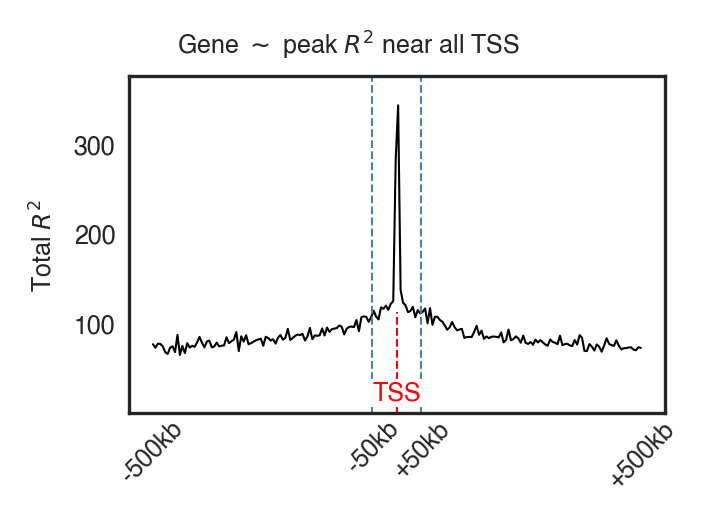

In [112]:

sns.set_style('white')
figsize=(60*mm, 40*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

sns.lineplot(x='x', y='Total R^2', data=plot_df,  color='k', linewidth=0.5, ax=ax)
#sns.lineplot(x='x', y='Pos R^2', data=plot_df,  color='darkgreen', linewidth=0.5, ax=ax)
#sns.lineplot(x='x', y='Neg R^2', data=plot_df,  color='darkred', linewidth=0.5, ax=ax)

ax.set_ylim(0,375)
ax.axvline(0,color='red', linestyle='--', ymax=0.3, linewidth=0.5)
ax.set_xticks([-500000,-50000,50000,500000])
ax.set_xticklabels(['-500kb','-50kb','+50kb','+500kb'], rotation=45, y=0.08)
ax.set_yticks([100,200,300])
ax.set_yticklabels([100,200,300], x=0.03)
ax.text(0,15,'TSS',color='red', ha='center', bbox={'facecolor':'white',  'pad':0})
ax.axvline(50000,color='steelblue',linestyle='--',linewidth=0.5)
ax.axvline(-50000,color='steelblue',linestyle='--',linewidth=0.5)
ax.set_xlabel('')
ax.set_ylabel('Total $R^2$')
set_size(fig, figsize)
plt.savefig("Panels/R2_near_TSS.pdf", bbox_inches='tight')
plt.suptitle('Gene $\sim$ peak $R^2$ near all TSS', y=1.02)
plt.show()

## Computation of background R^2 values

For each gene, we look at the R^2 values for correlations with all peaks on the same chromosome.  This gives a sense of "background noise" to filter out.  It's probably best to leave off the Y-chromosome, since we have so few genes there!

In [113]:
pg_corrs['Y']

Empty DataFrame
Columns: [EIF4A1P2, SRIP3, AC010970.2, RNA5-8SP6, PSMA6P1]
Index: []

We use the 95th percentile of all R^2 values with peaks on the same gene, as a cutoff for "significant correlation".  For example, here are those 95th percentiles for genes on chromosome 2.  

In [114]:
(pg_corrs['2']**2).quantile(0.95).sort_values()

gene_name
AC027612.6       0.153833
RPS14P4          0.162029
SCARNA5          0.163038
SRSF7            0.165132
ADI1             0.165296
                   ...   
RP11-141B14.1    0.375566
RRM2             0.376031
MARS2            0.381865
AC073046.25      0.386560
FARP2            0.408402
Name: 0.95, Length: 802, dtype: float64

In [115]:
R2_sigs = pd.Series(index=adata.var_names, dtype=np.float64)
for chrome in chromes:
    if chrome != 'Y':
        chrome_genes = pg_corrs[chrome].columns
        R2_sigs.loc[chrome_genes] = (pg_corrs[chrome]**2).quantile(0.95)
display(R2_sigs.sort_values())

gene_name
RP11-147I3.1     0.127160
RP11-697N18.4    0.129782
EXT1             0.133449
SSU72            0.133710
AC074138.3       0.134068
                   ...   
EIF4A1P2              NaN
SRIP3                 NaN
AC010970.2            NaN
RNA5-8SP6             NaN
PSMA6P1               NaN
Length: 11881, dtype: float64

In [116]:
R2_sigs.describe()

count    11843.000000
mean         0.249270
std          0.047259
min          0.127160
25%          0.215927
50%          0.242824
75%          0.275756
max          0.475238
dtype: float64

So on average, we view a R^2 value above 0.25 as statistically significant.  But this value fluctuated from one gene to another.  The number could be as low as 0.12 or as high as 0.47 in extreme cases.

# Areas of concentrated clonal peaks

In [117]:
clonal_roll = {}

for chrome in chromes:
    pc_df = ATAC_data.var[ATAC_data.var['chr'] == chrome][['mid','quality_p','clonal_p']].copy()
    pc_df = pc_df[pc_df.quality_p > 0.1] # Only high-quality peaks.
    pc_df = pc_df.sort_values(by='mid')
    pc_df['log_clonal'] = -np.log10(pc_df['clonal_p'])
    clonal_roll[chrome] = pd.DataFrame(pc_df.rolling(window=30, on='mid')['log_clonal'].sum().dropna())
    clonal_roll[chrome].columns = ['c_score']
    clonal_roll[chrome]['mid'] = pc_df['mid']
    print('On chromosome {}, look around the following intervals for clonal peaks.'.format(chrome))
    display(clonal_roll[chrome].sort_values(by='c_score')[-2:])
    hrule()

On chromosome 1, look around the following intervals for clonal peaks.


c_score          mid
PeakID                               
Interval_5092  73.080916  173520218.0
Interval_5088  74.019438  173403299.0

On chromosome 2, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_36727  74.107568    7058024.0
Interval_40524  74.206293  149326354.0

On chromosome 3, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_50965  73.564514  122399143.0
Interval_50962  74.689165  122328979.5

On chromosome 4, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_53597  71.979235  10589491.5
Interval_53615  72.279258  11430344.5

On chromosome 5, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_60289  63.759998  131563546.5
Interval_60334  63.816599  132024325.5

On chromosome 6, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_66792  72.039921  158957808.5
Interval_66794  72.562980  158986073.0

On chromosome 7, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_68435  73.734109  38402630.5
Interval_68434  74.086112  38398381.0

On chromosome 8, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_73913  69.749217  116601355.5
Interval_73911  70.050247  116588887.5

On chromosome 9, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_75990  72.434025  73107122.5
Interval_75988  73.587352  73034667.5

On chromosome 10, look around the following intervals for clonal peaks.


c_score         mid
PeakID                              
Interval_8660  74.249830  50462746.5
Interval_8661  74.572217  50480812.5

On chromosome 11, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_14046  76.105415  111445483.0
Interval_14044  76.415231  111411495.5

On chromosome 12, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_17628  70.056531  95043961.5
Interval_17632  70.782986  95156530.0

On chromosome 13, look around the following intervals for clonal peaks.


c_score          mid
PeakID                                
Interval_20944  62.970322  114897316.0
Interval_20859  63.286673  111956753.5

On chromosome 14, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_21105  80.420337  22686746.0
Interval_21106  80.721367  22689899.0

On chromosome 15, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_24905  65.304999  70964726.5
Interval_24900  65.783283  70820808.5

On chromosome 16, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_26384  71.197281  11357959.0
Interval_26373  72.451635  11318840.0

On chromosome 17, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_30804  70.143898  55532788.5
Interval_30780  70.313468  55011714.5

On chromosome 18, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_33525  71.063825  72045750.0
Interval_33484  72.043211  67862158.5

On chromosome 19, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_36476  80.544205  55553641.5
Interval_36480  81.768655  55592843.0

On chromosome 20, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_43681  72.320481  13228343.0
Interval_43684  73.238104  13619596.0

On chromosome 21, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_45463  68.777265  26835099.5
Interval_45462  70.272514  26829522.0

On chromosome 22, look around the following intervals for clonal peaks.


c_score         mid
PeakID                               
Interval_46517  70.154332  24093363.0
Interval_46515  70.840311  24047310.5

On chromosome X, look around the following intervals for clonal peaks.


c_score        mid
PeakID                              
Interval_78256  81.287657  9534401.0
Interval_78250  81.922419  9431196.5

On chromosome Y, look around the following intervals for clonal peaks.


Empty DataFrame
Columns: [c_score, mid]
Index: []

# Peak gene correlations, close to each gene

We perform principal component regression to study the effect of peak heights (all peaks within a window) on gene expression.  Our window includes the whole start-end length of the gene, plus 50kb upstream of the TSS.


In [118]:
promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].unique()
num_promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].nunique()

In [119]:
def peak_corrmatrix(peaklist):
    pc_df = peak_clonal[peaklist]
    return pc_df.corr()

In [120]:
def PCR_analysis(gene, peaklist=None, window=50000, theta = 0.05, verbose=False):
    if not peaklist:
        peaklist = peaks_near(gene, window=window)
    else:
        peaklist = peaklist
        
    out_df = pd.DataFrame(np.eye(len(peaklist)), index = peaklist, columns = peaklist)
    
    chrome = adata.var.chr[gene]
    corr_with_gene = pg_corrs[chrome][gene][peaklist]
    max_peaks = max(0,len(peak_clonal) - 1) # Cannot use too many peaks!
    cwg_sq = corr_with_gene**2
    cwg_sq = cwg_sq.sort_values(ascending=False)[:max_peaks]
    sel_peaks = cwg_sq[cwg_sq > theta].index
    
    cwg = corr_with_gene[sel_peaks]
    
    #print(sel_peaks)
    out_df = out_df.loc[sel_peaks]
    
    # display(out_df)
    
    peak_corrs = peak_corrmatrix(sel_peaks)
    
    #display(peak_corrs)
    #display(corr_with_gene**2)
    C = peak_corrs
    #C = C.multiply(corr_with_gene)
    #C = C.multiply(corr_with_gene, axis=0)
    eigens = np.linalg.eigh(C) #[0]
    #display(C)
    evals = eigens[0]
    evecs = eigens[1]
    #print(evecs)
    realpeaks = peak_clonal[sel_peaks]
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    #display(normpeaks)
    eigenpeaks = pd.DataFrame(np.dot(normpeaks, evecs), index=normpeaks.index)
    eig_cols = ['Eigenpeak {}'.format(str(j)) for j in range(len(sel_peaks))]
    out_df[eig_cols] = evecs
    eigenpeaks.columns = eig_cols
    if verbose: 
        display(eigenpeaks)
        display(eigenpeaks.corr())
    out_df.loc['{}_R'.format(gene), peaklist] = corr_with_gene
    out_df.loc['{}_Rsq'.format(gene), peaklist] = corr_with_gene**2
    
    gene_ensg = adata.var.loc[gene].ENSG
    if gene_ensg in promoters.index:
        prom_list = promoters[gene_ensg]
    else:
        prom_list = []
        
    out_df.loc[gene+'_promoter', peaklist] = peaklist.isin(prom_list)
    
    out_df.loc['{}_R'.format(gene), eig_cols] = (eigenpeaks).corrwith(gene_clonal[gene])
    out_df.loc['{}_Rsq'.format(gene), eig_cols] = out_df.loc['{}_R'.format(gene), eig_cols]**2
    
    return out_df

We carry out a brief analysis of all (non-mito) genes here.  It will take a minute or two.

In [121]:
PCR_analysis('MARK4')

PeakID         Interval_35820 Interval_35823 Interval_35822 Interval_35818  \
PeakID                                                                       
Interval_35823            0.0            1.0            0.0            0.0   
Interval_35824            0.0            0.0            0.0            0.0   
Interval_35829            0.0            0.0            0.0            0.0   
Interval_35831            0.0            0.0            0.0            0.0   
Interval_35830            0.0            0.0            0.0            0.0   
Interval_35818            0.0            0.0            0.0            1.0   
MARK4_R              0.009838      -0.848172      -0.055361      -0.243045   
MARK4_Rsq            0.000097       0.719396       0.003065       0.059071   
MARK4_promoter          False          False          False          False   

PeakID         Interval_35817 Interval_35829 Interval_35821 Interval_35836  \
PeakID                                                                       
Interval_35823            0.0            0.0            0.0            0.0   
Interval_35824            0.0            0.0            0.0            0.0   
Interval_35829            0.0            1.0            0.0            0.0   
Interval_35831            0.0            0.0            0.0            0.0   
Interval_35830            0.0            0.0            0.0            0.0   
Interval_35818            0.0            0.0            0.0            0.0   
MARK4_R              0.001945      -0.326618      -0.174052      -0.034096   
MARK4_Rsq            0.000004       0.106679       0.030294       0.001163   
MARK4_promoter          False          False          False           True   

PeakID         Interval_35830 Interval_35831 Interval_35824 Interval_35828  \
PeakID                                                                       
Interval_35823            0.0            0.0            0.0            0.0   
Interval_35824            0.0            0.0            1.0            0.0   
Interval_35829            0.0            0.0            0.0            0.0   
Interval_35831            0.0            1.0            0.0            0.0   
Interval_35830            1.0            0.0            0.0            0.0   
Interval_35818            0.0            0.0            0.0            0.0   
MARK4_R             -0.263781      -0.270783      -0.512891      -0.202013   
MARK4_Rsq            0.069581       0.073323       0.263057       0.040809   
MARK4_promoter          False          False          False          False   

PeakID         Interval_35837  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  \
PeakID                                                                 
Interval_35823            0.0    -0.383193    -0.578658     0.297160   
Interval_35824            0.0     0.212214     0.533123     0.332446   
Interval_35829            0.0     0.560809    -0.173984     0.450384   
Interval_35831            0.0    -0.523124     0.088415    -0.170051   
Interval_35830            0.0    -0.226977     0.565212    -0.047845   
Interval_35818            0.0     0.410419    -0.152915    -0.753075   
MARK4_R             -0.044096     0.298793     0.229280    -0.425887   
MARK4_Rsq            0.001944     0.089277     0.052569     0.181379   
MARK4_promoter          False          NaN          NaN          NaN   

PeakID          Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  
PeakID                                                 
Interval_35823     0.417166     0.213914    -0.458506  
Interval_35824     0.011070     0.682978    -0.306013  
Interval_35829    -0.283138    -0.441664    -0.420884  
Interval_35831    -0.708946    -0.005945    -0.432397  
Interval_35830     0.475573    -0.518013    -0.363622  
Interval_35818     0.130037     0.156023    -0.446987  
MARK4_R           -0.266191    -0.264384     0.590161  
MARK4_Rsq          0.070858     0.069899     0.348290  
MARK4_promoter          NaN          NaN          NaN

In [122]:
PCR_ans = {}
for j,gene in enumerate(adata.var_names.unique()):
    if j == 100:
        print('100 genes complete')
    if j%500 == 0:
        print('{} genes completed'.format(j))
    if adata.var.chr[gene] != 'MT': # No Mito genes in ATAC data.
        PCR_ans[gene] = PCR_analysis(gene)

0 genes completed
100 genes complete
500 genes completed
1000 genes completed
1500 genes completed
2000 genes completed
2500 genes completed
3000 genes completed
3500 genes completed
4000 genes completed
4500 genes completed
5000 genes completed
5500 genes completed
6000 genes completed
6500 genes completed
7000 genes completed
7500 genes completed
8000 genes completed
8500 genes completed
9000 genes completed
9500 genes completed
10000 genes completed
10500 genes completed
11000 genes completed
11500 genes completed


In [123]:
PCR_ans['GNLY']

PeakID         Interval_38953 Interval_38958 Interval_38960 Interval_38952  \
PeakID                                                                       
Interval_38960            0.0            0.0            1.0            0.0   
Interval_38958            0.0            1.0            0.0            0.0   
Interval_38952            0.0            0.0            0.0            1.0   
Interval_38957            0.0            0.0            0.0            0.0   
GNLY_R               0.099327       0.517197       0.793927        0.50086   
GNLY_Rsq             0.009866       0.267493        0.63032       0.250861   
GNLY_promoter           False          False           True          False   

PeakID         Interval_38957 Interval_38955  Eigenpeak 0  Eigenpeak 1  \
PeakID                                                                   
Interval_38960            0.0            0.0    -0.820592    -0.014805   
Interval_38958            0.0            0.0     0.382365    -0.649715   
Interval_38952            0.0            0.0     0.227936    -0.138525   
Interval_38957            1.0            0.0     0.358429     0.747303   
GNLY_R               0.459019       0.088697    -0.249706    -0.094271   
GNLY_Rsq             0.210699       0.007867     0.062353     0.008887   
GNLY_promoter           False          False          NaN          NaN   

PeakID          Eigenpeak 2  Eigenpeak 3  
PeakID                                    
Interval_38960     0.043873    -0.569636  
Interval_38958     0.424795    -0.501215  
Interval_38952    -0.880206    -0.392547  
Interval_38957     0.207031    -0.519813  
GNLY_R            -0.100005    -0.799577  
GNLY_Rsq           0.010001     0.639324  
GNLY_promoter           NaN          NaN

We can hunt for *repressor* peaks by looking for very negative R values as below.

In [124]:
for gene in PCR_ans.keys():
    PCR_df = PCR_ans[gene]
    int_cols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    R_vals = PCR_df.loc[gene+'_R', int_cols]
    if R_vals.min() < -0.8:
        display(PCR_df)

PeakID         Interval_7914 Interval_7915 Interval_7916  Eigenpeak 0  \
PeakID                                                                  
Interval_7915            0.0           1.0           0.0    -0.707107   
Interval_7914            1.0           0.0           0.0    -0.707107   
PTPLA_R             0.414435     -0.824415     -0.107373     0.415283   
PTPLA_Rsq           0.171756       0.67966      0.011529     0.172460   
PTPLA_promoter         False         False         False          NaN   

PeakID          Eigenpeak 1  
PeakID                       
Interval_7915     -0.707107  
Interval_7914      0.707107  
PTPLA_R            0.712245  
PTPLA_Rsq          0.507292  
PTPLA_promoter          NaN

PeakID         Interval_12707 Interval_12708 Interval_12706  Eigenpeak 0  \
PeakID                                                                     
Interval_12707            1.0            0.0            0.0    -0.707107   
Interval_12706            0.0            0.0            1.0     0.707107   
POLA2_R             -0.832008      -0.010158       -0.30152     0.417184   
POLA2_Rsq            0.692237       0.000103       0.090914     0.174043   
POLA2_promoter          False           True          False          NaN   

PeakID          Eigenpeak 1  
PeakID                       
Interval_12707     0.707107  
Interval_12706     0.707107  
POLA2_R           -0.734286  
POLA2_Rsq          0.539176  
POLA2_promoter          NaN

PeakID          Interval_31680 Interval_31675 Interval_31677 Interval_31678  \
PeakID                                                                        
Interval_31677             0.0            0.0            1.0            0.0   
TNRC6C_R              0.164693      -0.197118       -0.82714      -0.136104   
TNRC6C_Rsq            0.027124       0.038855        0.68416       0.018524   
TNRC6C_promoter          False          False          False           True   

PeakID           Eigenpeak 0  
PeakID                        
Interval_31677       1.00000  
TNRC6C_R            -0.82714  
TNRC6C_Rsq           0.68416  
TNRC6C_promoter          NaN

PeakID            Interval_34572 Interval_34574 Interval_34569 Interval_34567  \
PeakID                                                                          
Interval_34566               0.0            0.0            0.0            0.0   
Interval_34574               0.0            1.0            0.0            0.0   
Interval_34565               0.0            0.0            0.0            0.0   
Interval_34572               1.0            0.0            0.0            0.0   
Interval_34569               0.0            0.0            1.0            0.0   
Interval_34567               0.0            0.0            0.0            1.0   
RNASEH2A_R             -0.550169      -0.623425      -0.292098      -0.284012   
RNASEH2A_Rsq            0.302686       0.388658       0.085321       0.080663   
RNASEH2A_promoter          False          False          False          False   

PeakID            Interval_34566 Interval_34568 Interval_34577 Interval_34565  \
PeakID                                                                          
Interval_34566               1.0            0.0            0.0            0.0   
Interval_34574               0.0            0.0            0.0            0.0   
Interval_34565               0.0            0.0            0.0            1.0   
Interval_34572               0.0            0.0            0.0            0.0   
Interval_34569               0.0            0.0            0.0            0.0   
Interval_34567               0.0            0.0            0.0            0.0   
RNASEH2A_R             -0.804227      -0.057409       0.155131       -0.56181   
RNASEH2A_Rsq            0.646781       0.003296       0.024066       0.315631   
RNASEH2A_promoter          False          False           True          False   

PeakID            Interval_34570  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  \
PeakID                                                                    
Interval_34566               0.0    -0.058694    -0.684746     0.308957   
Interval_34574               0.0    -0.576956     0.062438    -0.561124   
Interval_34565               0.0     0.654904     0.228392     0.041701   
Interval_34572               0.0    -0.193282     0.641365     0.423904   
Interval_34569               0.0     0.442847    -0.086588    -0.538722   
Interval_34567               0.0    -0.036138    -0.237097     0.343555   
RNASEH2A_R              0.190978     0.069978     0.209717    -0.144635   
RNASEH2A_Rsq            0.036473     0.004897     0.043981     0.020919   
RNASEH2A_promoter          False          NaN          NaN          NaN   

PeakID             Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  
PeakID                                                    
Interval_34566        0.453694    -0.139481    -0.454895  
Interval_34574       -0.172969    -0.289491    -0.484396  
Interval_34565       -0.170380    -0.577882    -0.392711  
Interval_34572        0.288386     0.288039    -0.453283  
Interval_34569        0.147835     0.611262    -0.332673  
Interval_34567       -0.793847     0.325860    -0.296769  
RNASEH2A_R           -0.149954     0.161315     0.777317  
RNASEH2A_Rsq          0.022486     0.026022     0.604222  
RNASEH2A_promoter          NaN          NaN          NaN

PeakID          Interval_34644 Interval_34641 Interval_34648 Interval_34643  \
PeakID                                                                        
Interval_34642             0.0            0.0            0.0            0.0   
Interval_34641             0.0            1.0            0.0            0.0   
ZSWIM4_R             -0.159354      -0.555371       0.007067      -0.175304   
ZSWIM4_Rsq            0.025394       0.308436        0.00005       0.030732   
ZSWIM4_promoter          False          False          False          False   

PeakID          Interval_34640 Interval_34642 Interval_34646  Eigenpeak 0  \
PeakID                                                                      
Interval_34642             0.0            1.0            0.0    -0.707107   
Interval_34641             0.0            0.0            0.0     0.707107   
ZSWIM4_R              0.217909      -0.807004       0.063407     0.248750   
ZSWIM4_Rsq            0.047484       0.651255        0.00402     0.061877   
ZSWIM4_promoter          False          False          False          NaN   

PeakID           Eigenpeak 1  
PeakID                        
Interval_34642      0.707107  
Interval_34641      0.707107  
ZSWIM4_R           -0.789642  
ZSWIM4_Rsq          0.623534  
ZSWIM4_promoter          NaN

PeakID         Interval_35820 Interval_35823 Interval_35822 Interval_35818  \
PeakID                                                                       
Interval_35823            0.0            1.0            0.0            0.0   
Interval_35824            0.0            0.0            0.0            0.0   
Interval_35829            0.0            0.0            0.0            0.0   
Interval_35831            0.0            0.0            0.0            0.0   
Interval_35830            0.0            0.0            0.0            0.0   
Interval_35818            0.0            0.0            0.0            1.0   
MARK4_R              0.009838      -0.848172      -0.055361      -0.243045   
MARK4_Rsq            0.000097       0.719396       0.003065       0.059071   
MARK4_promoter          False          False          False          False   

PeakID         Interval_35817 Interval_35829 Interval_35821 Interval_35836  \
PeakID                                                                       
Interval_35823            0.0            0.0            0.0            0.0   
Interval_35824            0.0            0.0            0.0            0.0   
Interval_35829            0.0            1.0            0.0            0.0   
Interval_35831            0.0            0.0            0.0            0.0   
Interval_35830            0.0            0.0            0.0            0.0   
Interval_35818            0.0            0.0            0.0            0.0   
MARK4_R              0.001945      -0.326618      -0.174052      -0.034096   
MARK4_Rsq            0.000004       0.106679       0.030294       0.001163   
MARK4_promoter          False          False          False           True   

PeakID         Interval_35830 Interval_35831 Interval_35824 Interval_35828  \
PeakID                                                                       
Interval_35823            0.0            0.0            0.0            0.0   
Interval_35824            0.0            0.0            1.0            0.0   
Interval_35829            0.0            0.0            0.0            0.0   
Interval_35831            0.0            1.0            0.0            0.0   
Interval_35830            1.0            0.0            0.0            0.0   
Interval_35818            0.0            0.0            0.0            0.0   
MARK4_R             -0.263781      -0.270783      -0.512891      -0.202013   
MARK4_Rsq            0.069581       0.073323       0.263057       0.040809   
MARK4_promoter          False          False          False          False   

PeakID         Interval_35837  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  \
PeakID                                                                 
Interval_35823            0.0    -0.383193    -0.578658     0.297160   
Interval_35824            0.0     0.212214     0.533123     0.332446   
Interval_35829            0.0     0.560809    -0.173984     0.450384   
Interval_35831            0.0    -0.523124     0.088415    -0.170051   
Interval_35830            0.0    -0.226977     0.565212    -0.047845   
Interval_35818            0.0     0.410419    -0.152915    -0.753075   
MARK4_R             -0.044096     0.298793     0.229280    -0.425887   
MARK4_Rsq            0.001944     0.089277     0.052569     0.181379   
MARK4_promoter          False          NaN          NaN          NaN   

PeakID          Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  
PeakID                                                 
Interval_35823     0.417166     0.213914    -0.458506  
Interval_35824     0.011070     0.682978    -0.306013  
Interval_35829    -0.283138    -0.441664    -0.420884  
Interval_35831    -0.708946    -0.005945    -0.432397  
Interval_35830     0.475573    -0.518013    -0.363622  
Interval_35818     0.130037     0.156023    -0.446987  
MARK4_R           -0.266191    -0.264384     0.590161  
MARK4_Rsq          0.070858     0.069899     0.348290  
MARK4_promoter          NaN          NaN          NaN

PeakID         Interval_35870 Interval_35878 Interval_35880 Interval_35871  \
PeakID                                                                       
Interval_35869            0.0            0.0            0.0            0.0   
Interval_35874            0.0            0.0            0.0            0.0   
Interval_35871            0.0            0.0            0.0            1.0   
Interval_35878            0.0            1.0            0.0            0.0   
EML2_R               0.195169      -0.225418      -0.117802       0.234278   
EML2_Rsq             0.038091       0.050813       0.013877       0.054886   
EML2_promoter           False          False          False           True   

PeakID         Interval_35879 Interval_35873 Interval_35869 Interval_35874  \
PeakID                                                                       
Interval_35869            0.0            0.0            1.0            0.0   
Interval_35874            0.0            0.0            0.0            1.0   
Interval_35871            0.0            0.0            0.0            0.0   
Interval_35878            0.0            0.0            0.0            0.0   
EML2_R               0.090075      -0.017614      -0.825912      -0.379751   
EML2_Rsq             0.008114        0.00031       0.682131       0.144211   
EML2_promoter           False           True          False          False   

PeakID         Interval_35875  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  \
PeakID                                                                 
Interval_35869            0.0    -0.598442    -0.072303     0.605774   
Interval_35874            0.0     0.633099    -0.443333     0.029130   
Interval_35871            0.0    -0.464631    -0.214833    -0.784575   
Interval_35878            0.0     0.158652     0.867222    -0.128962   
EML2_R              -0.100648     0.233989    -0.020087    -0.631028   
EML2_Rsq              0.01013     0.054751     0.000403     0.398197   
EML2_promoter            True          NaN          NaN          NaN   

PeakID          Eigenpeak 3  
PeakID                       
Interval_35869    -0.519305  
Interval_35874    -0.633871  
Interval_35871    -0.349865  
Interval_35878    -0.454009  
EML2_R             0.502245  
EML2_Rsq           0.252250  
EML2_promoter           NaN

PeakID             Interval_46380 Interval_46377 Interval_46379  \
PeakID                                                            
Interval_46379                0.0            0.0            1.0   
Interval_46380                1.0            0.0            0.0   
Interval_46381                0.0            0.0            0.0   
THAP7-AS1_R              -0.70981        0.04764      -0.833162   
THAP7-AS1_Rsq             0.50383        0.00227       0.694158   
THAP7-AS1_promoter           True          False          False   

PeakID             Interval_46381  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  
PeakID                                                                    
Interval_46379                0.0    -0.703636    -0.272600    -0.656190  
Interval_46380                0.0     0.710271    -0.243497    -0.660473  
Interval_46381                1.0    -0.020265     0.930805    -0.364953  
THAP7-AS1_R             -0.290844     0.134563     0.136507     0.866363  
THAP7-AS1_Rsq             0.08459     0.018107     0.018634     0.750585  
THAP7-AS1_promoter          False          NaN          NaN          NaN

PeakID          Interval_50642 Interval_50648 Interval_50641 Interval_50639  \
PeakID                                                                        
Interval_50643             0.0            0.0            0.0            0.0   
Interval_50639             0.0            0.0            0.0            1.0   
PHLDB2_R             -0.035791       0.071069       0.200649      -0.484676   
PHLDB2_Rsq            0.001281       0.005051        0.04026       0.234911   
PHLDB2_promoter          False          False          False          False   

PeakID          Interval_50638 Interval_50649 Interval_50643  Eigenpeak 0  \
PeakID                                                                      
Interval_50643             0.0            0.0            1.0    -0.707107   
Interval_50639             0.0            0.0            0.0     0.707107   
PHLDB2_R             -0.047488       0.085494      -0.822058     0.301413   
PHLDB2_Rsq            0.002255       0.007309        0.67578     0.090850   
PHLDB2_promoter          False          False          False          NaN   

PeakID           Eigenpeak 1  
PeakID                        
Interval_50643      0.707107  
Interval_50639      0.707107  
PHLDB2_R           -0.788408  
PHLDB2_Rsq          0.621588  
PHLDB2_promoter          NaN

PeakID          Interval_62672 Interval_62661 Interval_62671 Interval_62657  \
PeakID                                                                        
Interval_62680             0.0            0.0            0.0            0.0   
Interval_62671             0.0            0.0            1.0            0.0   
Interval_62668             0.0            0.0            0.0            0.0   
Interval_62679             0.0            0.0            0.0            0.0   
Interval_62676             0.0            0.0            0.0            0.0   
Interval_62678             0.0            0.0            0.0            0.0   
Interval_62669             0.0            0.0            0.0            0.0   
FAM65B_R              0.142392       0.075671       0.452342      -0.047006   
FAM65B_Rsq            0.020276       0.005726       0.204613        0.00221   
FAM65B_promoter          False           True          False          False   

PeakID          Interval_62668 Interval_62667 Interval_62664 Interval_62654  \
PeakID                                                                        
Interval_62680             0.0            0.0            0.0            0.0   
Interval_62671             0.0            0.0            0.0            0.0   
Interval_62668             1.0            0.0            0.0            0.0   
Interval_62679             0.0            0.0            0.0            0.0   
Interval_62676             0.0            0.0            0.0            0.0   
Interval_62678             0.0            0.0            0.0            0.0   
Interval_62669             0.0            0.0            0.0            0.0   
FAM65B_R              0.447211       0.207976       -0.07757       0.182563   
FAM65B_Rsq            0.199998       0.043254       0.006017       0.033329   
FAM65B_promoter          False           True          False          False   

PeakID          Interval_62669 Interval_62680 Interval_62676 Interval_62678  \
PeakID                                                                        
Interval_62680             0.0            1.0            0.0            0.0   
Interval_62671             0.0            0.0            0.0            0.0   
Interval_62668             0.0            0.0            0.0            0.0   
Interval_62679             0.0            0.0            0.0            0.0   
Interval_62676             0.0            0.0            1.0            0.0   
Interval_62678             0.0            0.0            0.0            1.0   
Interval_62669             1.0            0.0            0.0            0.0   
FAM65B_R               0.23043       -0.84397      -0.372134      -0.277167   
FAM65B_Rsq            0.053098       0.712285       0.138483       0.076822   
FAM65B_promoter          False          False          False          False   

PeakID          Interval_62679  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  \
PeakID                                                                  
Interval_62680             0.0    -0.207274    -0.389835    -0.722768   
Interval_62671             0.0     0.041920    -0.606784    -0.044396   
Interval_62668             0.0    -0.665047     0.201714     0.012158   
Interval_62679             1.0     0.013982     0.477339    -0.057054   
Interval_62676             0.0    -0.112949    -0.455997     0.641627   
Interval_62678             0.0     0.223065     0.056808     0.186013   
Interval_62669             0.0     0.671030     0.011821    -0.161078   
FAM65B_R             -0.445709     0.077961     0.154405     0.370605   
FAM65B_Rsq            0.198657     0.006078     0.023841     0.137348   
FAM65B_promoter          False          NaN          NaN          NaN   

PeakID           Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  Eigenpeak 6  
PeakID                                                               
Interval_62680     -0.080545    -0.139742     0.284137    -0.419432  
Interval_62671      0.441955    -0.323264    -0.474458     0.32117

PeakID         Interval_63905 Interval_63900 Interval_63904 Interval_63906  \
PeakID                                                                       
Interval_63906            0.0            0.0            0.0            1.0   
Interval_63905            1.0            0.0            0.0            0.0   
Interval_63904            0.0            0.0            1.0            0.0   
PAQR8_R             -0.386708      -0.171704       0.306026      -0.904939   
PAQR8_Rsq            0.149543       0.029482       0.093652       0.818914   
PAQR8_promoter          False          False          False          False   

PeakID          Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  
PeakID                                                 
Interval_63906    -0.644631     0.317484    -0.695453  
Interval_63905     0.656999    -0.235077    -0.716303  
Interval_63904    -0.390900    -0.918663    -0.057049  
PAQR8_R            0.333772    -0.453725     0.726321  
PAQR8_Rsq          0.111404     0.205866     0.527543  
PAQR8_promoter          NaN          NaN          NaN

PeakID          Interval_69611 Interval_69615 Interval_69613 Interval_69614  \
PeakID                                                                        
Interval_69611             1.0            0.0            0.0            0.0   
Interval_69614             0.0            0.0            0.0            1.0   
Interval_69613             0.0            0.0            1.0            0.0   
PMS2P1_R              -0.80737       0.161394      -0.266771        0.36348   
PMS2P1_Rsq            0.651846       0.026048       0.071167       0.132118   
PMS2P1_promoter          False          False          False          False   

PeakID           Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  
PeakID                                                  
Interval_69611      0.718879    -0.014654    -0.694981  
Interval_69614      0.547623     0.627741     0.553218  
Interval_69613     -0.428161     0.778284    -0.459295  
PMS2P1_R           -0.420483     0.033076     0.691239  
PMS2P1_Rsq          0.176806     0.001094     0.477812  
PMS2P1_promoter          NaN          NaN          NaN

## Panel:  Principal Component Regression -- summary.

We create a dataframe summarizing our PCR analysis, and make a plot of the peaks found.

In [125]:
PCR_summary = pd.DataFrame(index = PCR_ans.keys(), 
                           columns=['promoter_R_sq', 'num_eig'])

i = 0
for gene in PCR_ans.keys():
    i += 1
    if i%1000 == 0:
        print('{} genes processed.'.format(i))
    PCR_df = PCR_ans[gene]
    
    intcols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    PCR_summary.loc[gene,'num_peaks'] = len(intcols)
    
    eigencols = [col for col in PCR_df.columns if col[:3] == 'Eig']
    promcols = (PCR_df.loc[gene+'_promoter'] == True)
    promcols = promcols[promcols].index
    #print(promcols)
    if len(promcols) > 0:
        #print(PCR_df.loc[gene+'_Rsq',promcols].max())
        PCR_summary.loc[gene, 'promoter_R_sq'] = PCR_df.loc[gene+'_Rsq',promcols].max()
    else:
        PCR_summary.loc[gene, 'promoter_R_sq'] = 0
    R2_int = PCR_df.loc[gene+'_Rsq',intcols]
    R2_cutoff = R2_sigs[gene]
    PCR_summary.loc[gene, 'num_sigpeaks'] = (R2_int > R2_cutoff).sum()
    if len(eigencols) > 0:
        R2_eig = PCR_df.loc[gene+'_Rsq',eigencols]
        num_eig = (R2_eig > R2_cutoff).sum()
        PCR_summary.loc[gene,'num_eig'] = num_eig
        eig_R_sq = R2_eig.sort_values(ascending=False)
        for j in range(len(eigencols)):
            PCR_summary.loc[gene, 'eigen{}_R_sq'.format(j)] = eig_R_sq[j]
    else:
        PCR_summary.loc[gene,'num_eig'] = 0
    #print(PCR_summary.loc[gene])

1000 genes processed.
2000 genes processed.
3000 genes processed.
4000 genes processed.
5000 genes processed.
6000 genes processed.
7000 genes processed.
8000 genes processed.
9000 genes processed.
10000 genes processed.
11000 genes processed.


In [126]:
PCR_summary

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
WASH7P                    0       0        1.0           0.0          NaN   
AL627309.1                0       0        0.0           0.0          NaN   
RP11-34P13.13             0       0        0.0           0.0          NaN   
MTND2P28                  0       0        0.0           0.0          NaN   
hsa-mir-6723              0       0        0.0           0.0          NaN   
...                     ...     ...        ...           ...          ...   
EIF4A1P2                  0       0        0.0           0.0          NaN   
SRIP3                     0       0        0.0           0.0          NaN   
AC010970.2                0       0        0.0           0.0          NaN   
RNA5-8SP6                 0       0        0.0           0.0          NaN   
PSMA6P1                   0       0        0.0           0.0          NaN   

               eigen1_R_sq  eigen2_R_sq  eigen3_R_sq  eigen4_R_sq  \
WASH7P                 NaN          NaN          NaN          NaN   
AL627309.1             NaN          NaN          NaN          NaN   
RP11-34P13.13          NaN          NaN          NaN          NaN   
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
...                    ...          ...          ...          ...   
EIF4A1P2               NaN          NaN          NaN          NaN   
SRIP3                  NaN          NaN          NaN          NaN   
AC010970.2             NaN          NaN          NaN          NaN   
RNA5-8SP6              NaN          NaN          NaN          NaN   
PSMA6P1                NaN          NaN          NaN          NaN   

               eigen5_R_sq  eigen6_R_sq  eigen7_R_sq  eigen8_R_sq  \
WASH7P                 NaN          NaN          NaN          NaN   
AL627309.1             NaN          NaN          NaN          NaN   
RP11-34P13.13          NaN          NaN          NaN          NaN   
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
...                    ...          ...          ...          ...   
EIF4A1P2               NaN          NaN          NaN          NaN   
SRIP3                  NaN          NaN          NaN          NaN   
AC010970.2             NaN          NaN          NaN          NaN   
RNA5-8SP6              NaN          NaN          NaN          NaN   
PSMA6P1                NaN          NaN          NaN          NaN   

               eigen9_R_sq  eigen10_R_sq  eigen11_R_sq  eigen12_R_sq  \
WASH7P                 NaN           NaN           NaN           NaN   
AL627309.1             NaN           NaN           NaN           NaN   
RP11-34P13.13          NaN           NaN           NaN           NaN   
MTND2P28               NaN           NaN           NaN           NaN   
hsa-mir-6723           NaN           NaN           NaN           NaN   
...                    ...           ...           ...           ...   
EIF4A1P2               NaN           NaN           NaN           NaN   
SRIP3                  NaN           NaN           NaN           NaN   
AC010970.2             NaN           NaN           NaN           NaN   
RNA5-8SP6              NaN           NaN           NaN           NaN   
PSMA6P1                NaN           NaN           NaN           NaN   

               eigen13_R_sq  eigen14_R_sq  
WASH7P                  NaN           NaN  
AL627309.1              NaN           NaN  
RP11-34P13.13           NaN           NaN  
MTND2P28                NaN           NaN  
hsa-mir-6723            NaN           NaN  
...                     ...           ...  
EIF4A1P2                NaN           NaN  
SRIP3                   NaN           NaN  
AC010970.2              NaN           NaN  
RNA5-8SP6               NaN           NaN  
PSMA6P1                 NaN           NaN  

[11848 rows x 19 columns]

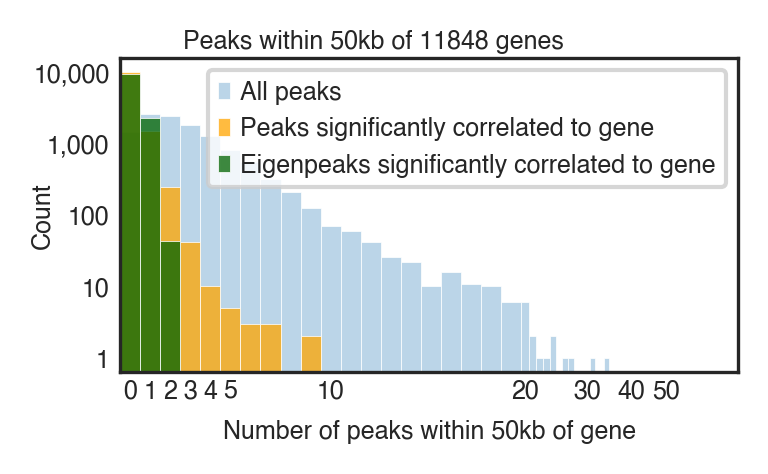

In [127]:
plot_genes = adata.var.index
plot_genes = [gene for gene in plot_genes if gene in PCR_summary.index]

sns.set_style('white')
figsize=(65*mm, 40*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()

bins=np.arange(0,75,1)
sns.histplot(PCR_summary.loc[plot_genes,'num_peaks'], bins=bins, ax=ax, alpha=0.3, label='All peaks')
sns.histplot(PCR_summary.loc[plot_genes,'num_sigpeaks'], bins=bins, ax=ax, color='orange', label='Peaks significantly correlated to gene')
sns.histplot(PCR_summary.loc[plot_genes,'num_eig'], bins=bins, ax=ax, color='darkgreen', label='Eigenpeaks significantly correlated to gene')
ax.legend()
plt.yscale('log')
plt.xscale('symlog',linthresh=20.0)
xt = [0,1,2,3,4,5,10,20,30,40,50]
ax.set_xticks([x + 0.5 for x in xt])
ax.set_xticklabels([0,1,2,3,4,5,10,20,30,40,50], y=0.07)
ax.set_yticks([1,10,100,1000,10000])
ax.set_yticklabels(['1','10','100','1,000','10,000'], x=0.03)
ax.set_xlim(0,80)
ax.set_xlabel('Number of peaks within 50kb of gene')
ax.set_ylabel('Count', labelpad=-5)
plt.suptitle('Peaks within 50kb of {} genes'.format(len(PCR_summary.loc[plot_genes])))

set_size(fig, figsize)
plt.savefig("Panels/PCR_Peaks.pdf", bbox_inches='tight')
plt.show()

In [128]:
PCR_summary.to_csv('PCR_summary.csv')

# Multiomics plots

In [129]:
pg_clones = list(peak_clonal.index)

In [130]:
prot_clonal = prot_data.to_df().groupby(prot_data.obs.Clone_ID).mean()
prot_clonal = prot_clonal.loc[pg_clones]
prot_clonal

var_names    CD57 FITC  A2 YF DEXTRA APC        CD8 A7  CD62L BV670  \
Clone_ID                                                              
P1_A03      902.903320      27506.250000   8444.175781  -208.290939   
P1_A05      803.705139      19328.957031   7142.438965   -32.177135   
P1_A08      576.234619      19552.335938   7188.782227   -37.302555   
P1_A12      413.486084      15468.637695   4991.385742   -77.271622   
P1_B10       42.948910      14563.261719   8508.237305   -55.116821   
P1_C11     1643.779175      23151.318359  10985.375000   -18.524429   
P1_D09     1441.065430      17640.460938   6325.950684   567.863037   
P1_F10      203.625443      16097.100586   7561.971680   -58.249008   
P1_H01     1690.622925      14977.458984   6277.771973     4.625610   
P1_H10     1068.334717      26251.025391   8835.803711    71.106735   
P2_A04     1749.253052      22271.263672   7926.547363  -162.400391   
P2_B11      905.793823      22156.519531   8163.387695  -191.425201   
P2_G01     2321.262451      29470.908203   9826.098633  -157.706314   
P2_G09      638.899292      22724.232422   8776.172852   -93.520004   
P2_H04      247.371338      35838.644531   9158.025391  -105.397858   
P2_H05     3864.262207      17620.658203   9249.083984    34.258526   

var_names    PD1 BV711  CD27 BV786      CD94 PE      CD3 PC5  
Clone_ID                                                      
P1_A03     1376.424927  -97.778107  2359.556641  2292.757568  
P1_A05      903.623413  -68.900253   393.199371  2615.705322  
P1_A08     1303.275879  -41.017300  7642.252441  2269.702393  
P1_A12      994.417175  -49.785648   279.779022  1625.113037  
P1_B10     2128.482666   22.142307  1226.074707  2014.063965  
P1_C11     1235.683594  -62.457111  2831.641602  2888.821533  
P1_D09     2455.682129  -83.398872    60.759659  2319.213623  
P1_F10     1241.386597  -57.741810  1476.108765  1676.395996  
P1_H01     1099.460083  -65.979813  1879.674072  1961.431641  
P1_H10      555.246704  -97.844833   154.407333  2497.243896  
P2_A04      741.104126  -83.873314    62.666954  2209.680908  
P2_B11      828.401001 -106.923340  2057.955078  2286.909668  
P2_G01     1150.331055  -97.822929   288.096466  2334.123291  
P2_G09     1495.582153 -101.572876  7028.983398  2695.924805  
P2_H04      810.228943   25.330467   145.109039  2907.352783  
P2_H05      702.913269  -84.052254    63.130737  1906.631836

In [131]:
gene_clonal

gene_name    WASH7P  AL627309.1  RP11-34P13.13  MTND2P28  hsa-mir-6723  \
Clone_ID                                                                 
P1_A03     0.618283    0.945561       1.025549  3.235500      2.083895   
P1_A05     0.000000    0.000000       0.000000  2.712187      1.456248   
P1_A08     0.000000    0.000000       0.000000  3.053064      1.616868   
P1_A12     0.190624    0.000000       0.000000  3.038536      1.861662   
P1_B10     0.000000    0.000000       0.000000  3.115203      2.256257   
P1_C11     0.195251    0.000000       0.000000  2.748705      1.980835   
P1_D09     0.000000    0.000000       0.000000  2.579358      1.508479   
P1_F10     0.000000    0.000000       0.000000  2.925440      1.696129   
P1_H01     0.000000    0.000000       0.000000  3.109386      1.951495   
P1_H10     0.000000    0.000000       0.000000  2.253430      1.487985   
P2_A04     0.577054    0.203521       0.000000  3.239484      1.336314   
P2_B11     0.000000    0.000000       0.000000  3.310599      2.166867   
P2_G01     0.000000    0.000000       0.000000  3.007948      0.545674   
P2_G09     0.000000    0.000000       0.000000  2.711262      1.457363   
P2_H04     0.000000    0.000000       0.000000  2.317622      1.713998   
P2_H05     0.000000    0.000000       0.000000  2.048599      0.480044   

gene_name  RP5-857K21.7  MTATP8P1  MTATP6P1  RP5-857K21.11  RP11-206L10.9  \
Clone_ID                                                                    
P1_A03         0.750680  0.459195  5.755206       0.250811       0.000000   
P1_A05         0.407113  0.000000  5.386560       0.229657       0.000000   
P1_A08         0.697563  0.414321  5.804655       0.227296       0.000000   
P1_A12         0.000000  0.472903  5.478726       0.000000       0.888312   
P1_B10         0.699134  0.425098  5.694868       0.000000       0.000000   
P1_C11         0.540095  0.000000  5.840600       0.252954       0.000000   
P1_D09         0.527772  0.454545  5.743250       0.213638       0.949451   
P1_F10         0.626677  0.000000  5.868581       0.273484       0.000000   
P1_H01         0.371031  0.505814  5.827295       0.000000       0.000000   
P1_H10         0.211150  0.885398  5.617558       0.000000       0.000000   
P2_A04         0.000000  0.000000  5.568577       0.234326       0.957820   
P2_B11         0.973400  0.000000  5.709068       0.615366       1.189926   
P2_G01         0.000000  0.469179  4.773428       0.257901       0.000000   
P2_G09         0.747793  0.461915  5.398914       0.000000       0.000000   
P2_H04         0.343014  0.477543  5.297565       0.299365       0.352106   
P2_H05         0.387329  0.000000  4.366103       0.000000       0.000000   

gene_name  ...    VBP1-1  RAB39B-1   TMLHE-1     VAMP7      IL9R  EIF4A1P2  \
Clone_ID   ...                                                               
P1_A03     ...  3.447827  0.000000  0.000000  0.000000  0.000000  0.000000   
P1_A05     ...  4.643641  0.000000  1.078488  2.631706  0.000000  0.135689   
P1_A08     ...  4.286690  0.000000  2.964008  0.000000  0.000000  0.000000   
P1_A12     ...  4.638396  0.864891  3.823669  2.864282  0.000000  0.230631   
P1_B10     ...  2.665425  0.772898  3.731382  2.401685  0.000000  0.325636   
P1_C11     ...  3.885841  0.892146  1.207822  2.805009  2.455279  0.105118   
P1_D09     ...  4.358072  0.686928  1.850092  2.886688  0.000000  0.248796   
P1_F10     ...  4.180732  0.902162  0.000000  1.396651  1.221312  0.000000   
P1_H01     ...  4.212268  0.000000  1.494714  1.758571  0.000000  0.138110   
P1_H10     ...  4.177901  0.000000  0.762414  1.625854  0.302063  0.000000   
P2_A04     ...  2.828667  0.000000  2.955809  0.000000  0.000000  0.000000   
P2_B11     ...  4.456919  0.000000  4.221027  2.097311  0.000000  0.121822   
P2_G01     ...  0.000000  0.000000  1.927383  0.352053  0.000000  0.155642   
P2_G09     ...  4.849241  2.137543  0.000000  2.615978  0.000000  0.000000   
P2_H04     ...  2.516015  1.1694

In [132]:
peak_clonal

PeakID    Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
Clone_ID                                                                   
P1_A03          2.397638        2.529633        2.150198        5.617923   
P1_A05          2.717578        1.972389        2.088377        5.437860   
P1_A08          2.928915        2.287843        1.691356        5.560565   
P1_A12          2.225148        2.426444        2.426444        5.683740   
P1_B10          2.987230        1.853198        2.670728        5.436592   
P1_C11          2.751107        2.591159        1.970270        5.644123   
P1_D09          2.464640        3.449496        2.299183        5.493403   
P1_F10          2.149178        2.824024        2.065458        5.619921   
P1_H01          2.556990        1.892109        2.524847        5.518234   
P1_H10          2.260768        2.869512        2.697917        5.432869   
P2_A04          2.370404        2.967492        2.469283        5.697934   
P2_B11          2.246812        0.000000        2.714423        5.558466   
P2_G01          1.948509        2.775430        2.623850        5.629741   
P2_G09          2.707259        2.128885        1.243721        5.444118   
P2_H04          2.718706        1.969373        2.339709        5.705107   
P2_H05          2.027774        2.000840        1.945744        5.533689   

PeakID    Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
Clone_ID                                                                  
P1_A03          1.967855        3.278499        3.233557       4.882648   
P1_A05          0.633384        3.517708        2.451669       5.108484   
P1_A08          2.287843        3.709698        3.762476       5.194549   
P1_A12          1.119627        3.585825        3.326052       5.100070   
P1_B10          2.205004        3.504991        3.114438       5.243369   
P1_C11          1.856460        3.638525        3.083403       5.247215   
P1_D09          3.114337        3.700081        3.607240       5.154146   
P1_F10          1.974084        3.443976        3.507894       5.158548   
P1_H01          1.727383        3.856328        3.475958       5.182631   
P1_H10          2.418915        3.799819        1.578473       5.147631   
P2_A04          2.166221        3.824545        0.732249       5.182442   
P2_B11          2.246812        4.033247        3.964330       5.195662   
P2_G01          1.707229        3.436920        2.986031       5.123996   
P2_G09          1.243721        3.869145        2.991982       5.031900   
P2_H04          2.115431        3.431467        1.571595       5.082010   
P2_H05          1.454262        3.602494        0.553023       5.061416   

PeakID    Interval_6501  Interval_68580  ...  Interval_69022  Interval_56910  \
Clone_ID                                 ...                                   
P1_A03         4.752263        5.469793  ...        4.176711        5.725381   
P1_A05         4.493093        5.533124  ...        4.421364        5.751973   
P1_A08         4.519068        5.543390  ...        3.949484        5.814805   
P1_A12         4.740612        5.524294  ...        4.205272        5.802704   
P1_B10         4.985421        5.780162  ...        4.261869        5.647071   
P1_C11         4.287120        5.610814  ...        4.035187        5.825854   
P1_D09         4.445949        5.408775  ...        4.487143        5.763301   
P1_F10         4.699069        5.427788  ...        4.216893        5.746419   
P1_H01         4.508285        5.476674  ...        4.231659        5.612613   
P1_H10         4.061644        5.429313  ...        4.128048        5.493102   
P2_A04         4.576645        5.627039  ...        4.219496        5.726516   
P2_B11         4.471122        5.540189  ...        4.345335        5.734086   
P2_G01         4.585413        5.571364  ...        4.251483        5.548196   
P2_G09         4.856232        5.418911  ...        4.402289        5.577108   


In [133]:
from matplotlib.ticker import FormatStrFormatter

def pgplot(gene, protein = None, eigen = False, order='eig', cutoff=0.2, window=50000, file_annot = ''):
    sns.set_style('white')
    setfontsize()
    if protein or eigen:
        num_rows = 3
        hr = [2,1,1]
    else:
        num_rows = 2
        hr=[2,1]

    
    # Peaks and eigenpeaks
    PCR_df = PCR_analysis(gene, window=window)
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    
    figsize=(35*mm,12*mm*num_rows + 10*mm + (2.5 * (len(peaklist)//3) * mm))
    fig, ax = plt.subplots(num_rows,1,figsize=figsize, dpi=300, sharex=True,
                           gridspec_kw = {'hspace':0.05, 'height_ratios':hr}) 
    
               
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    
    pplot_df = peak_clonal[peaklist].copy()
    
    eig_cols = [col for col in PCR_df.columns if col[:3] == 'Eig']
    eig_weights = PCR_df.loc[peaklist, eig_cols]
    realpeaks = pplot_df
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    eig_df = normpeaks.dot(eig_weights)
    eigR2 = PCR_df.loc[gene+'_Rsq',eig_cols].astype(float)
    eig_df = eig_df * (2 * (eig_df.loc[clone_order[-1]] > 0) - 1) #Flip eigenpeaks to match gene.
    ty = np.min(eig_df.values)
    
    top_eig = eigR2.idxmax()
    
    
    # Normalize peak heights between 0 and 1.
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()    
    
    if order=='eig':
        clone_order = list(eig_df[top_eig].sort_values().index)
        
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)    
    eig_df['Clone'] = pd.Categorical(eig_df.index, categories = clone_order, ordered = True)
    
     
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
        
    for clone in clone_order:
        for row in range(num_rows):
            ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    
    sns.scatterplot(x='Clone', y=gene, color='darkgray', edgecolor='k', s=10, data=gplot_df, ax=ax[0], legend=False)
    gene_ticks = [int(gplot_df[gene].min()), int(gplot_df[gene].max())]
    if gene_ticks[1] == gene_ticks[0]:
        gene_ticks[1] = gene_ticks[0]+1
    ax[0].set_yticks(gene_ticks)
    ax[0].set_yticklabels(gene_ticks, x=0.03)
    #ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[0].set_ylabel(gene)
    ax[0].yaxis.set_label_position("right")
    ax[0].tick_params(axis='y', pad=-0.6)
    
    # ATAC PLOT
    
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        sns.lineplot(x='Clone', y=peak, data=pplot_df, ax=ax[-1], linewidth=0.7,
                    label=peak_label, alpha=min(1,peak_Rsq*1.5), zorder=np.round(peak_Rsq*100).astype(int)) #, label=peak, legend=False)
    
    ax[-1].set_ylabel('Peak')
    ax[-1].yaxis.set_label_position("right")
    ax[-1].set_yticks([])
    ax[-1].set_xlabel('')
    
    # PROTEIN PLOT
    if protein:
        proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
        proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
        proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
        proplot_df['Clone'] = proplot_df.index
        sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
        ax[1].text(1,0.5,protein, ha='left')
        ax[1].set_ylabel('Prot')
        ax[1].yaxis.set_label_position("right")
        ax[1].set_yticks([])
        ax[1].set_xlabel('')
        ax[1].spines['top'].set_color('lightgray')
        ax[1].spines['bottom'].set_color('lightgray')
    
    # Eigenpeak plot
    if eigen:
        no_peaks = 0
        for peak in eig_cols:
            peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
            if peak_Rsq > 0.05:
                peak_label = '${:1.2f}$'.format(peak_Rsq)
                no_peaks += 1
            else:
                peak_label = None
            sns.lineplot(x='Clone', y=peak, data=eig_df, ax=ax[1], linewidth=0.7,
                        alpha=min(1,peak_Rsq*1.5), 
                         color='k') #, zorder=np.round(peak_Rsq*100).astype(int))
        
        ax[1].text(9,ty,'Eigenpeaks', ha='center', va='bottom')
        ax[1].set_ylabel('')
        #ax[1].yaxis.set_label_position("right")
        ax[1].set_yticks([])
        ax[1].set_xlabel('')
        ax[1].spines['top'].set_color('lightgray')
        ax[1].spines['bottom'].set_color('lightgray')
        ax[1].axhline(0, c='red', alpha=0.25, linewidth=0.5)
    
    # General formatting.
    ax[0].spines['bottom'].set_color('lightgray')
    ax[-1].spines['top'].set_color('lightgray')
    
    plt.xticks(rotation=45)
    plt.xticks([])
    
    if len(peaklist) == 1:
        peakword = 'peak'
    else:
        peakword = 'peaks'
    if protein:
        title = '{}, {}, and {} {}'.format(gene, protein, len(peaklist), peakword)
    else:
        title = '{} and {} {}'.format(gene, len(peaklist), peakword)
    plt.suptitle(title, y=1.02, x=0.6)
    
    # Plot legend
    if no_peaks <= 3:
        ncol = no_peaks
    else:
        ncol = 3
    lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
                      loc=9, ncol=ncol, framealpha=0.5)
    lgnd.get_frame().set_linewidth(0.5)
    
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[-1].set_ylabel('')
    
    # Save and show figure.
    set_size(fig, figsize)
    file_prefix = 'Panels/Multiplots/'
    file_name = '{}_peaks_gene'.format(gene)
    if eigen:
        file_name += '_eigens'
    if protein:
        file_name += '_prots'
    file_name += file_annot
    file_suffix = '.pdf'
    plt.savefig(file_prefix + file_name + file_suffix, bbox_inches='tight')
    plt.show()

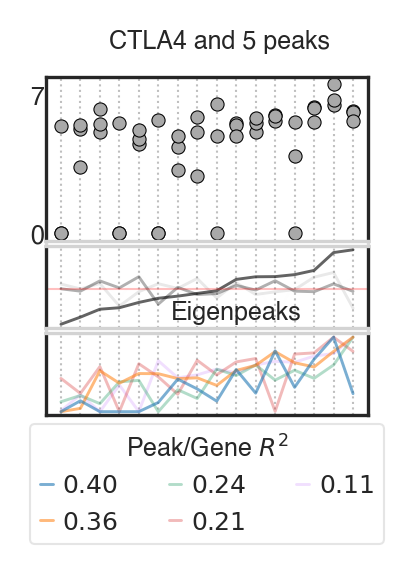

In [134]:
pgplot('CTLA4', eigen=True, cutoff=0.05)

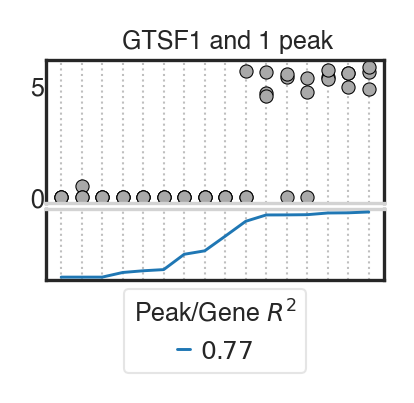

In [135]:
pgplot('GTSF1')

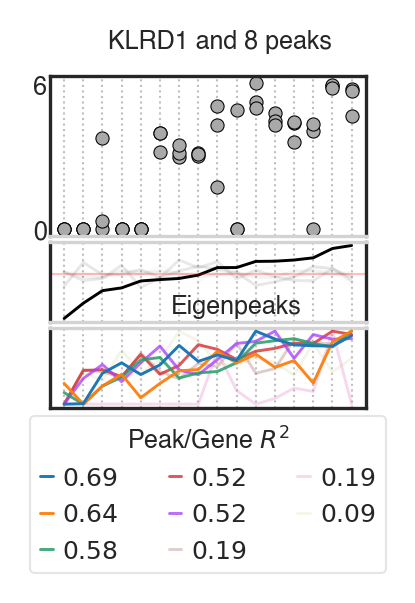

In [136]:
pgplot('KLRD1', eigen=True, cutoff=0.05)

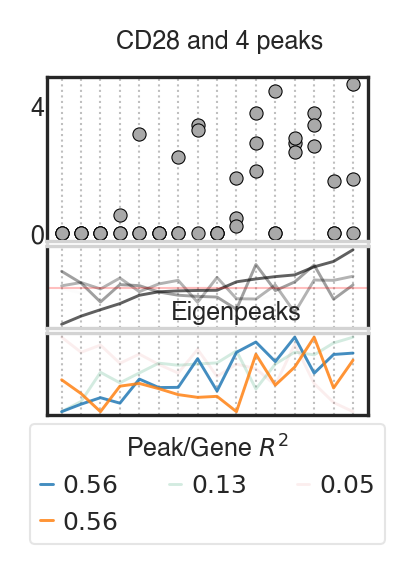

In [137]:
pgplot('CD28', eigen=True, cutoff=0.05)

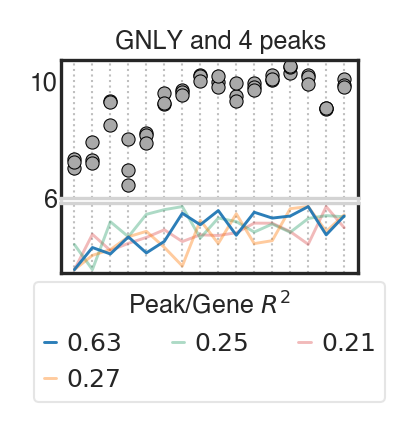

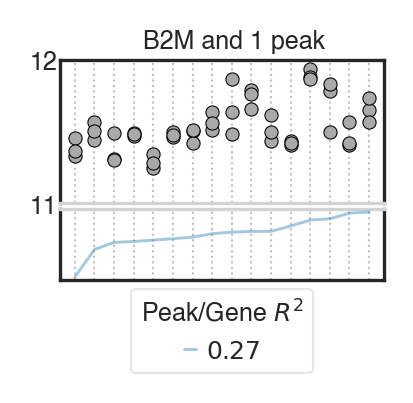

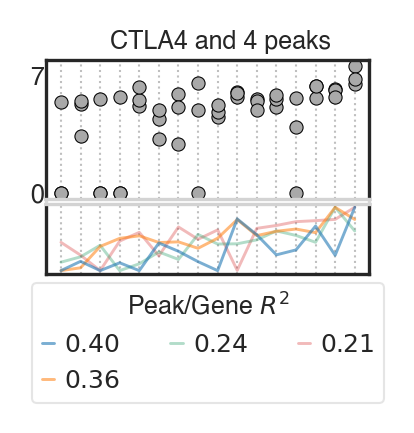

In [138]:
for gene in ['GNLY','B2M','CTLA4']:
    pgplot(gene)

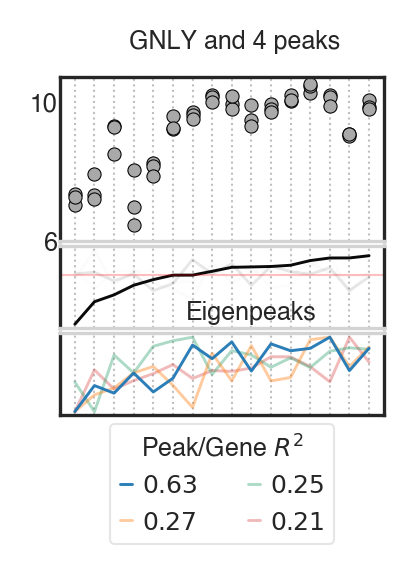

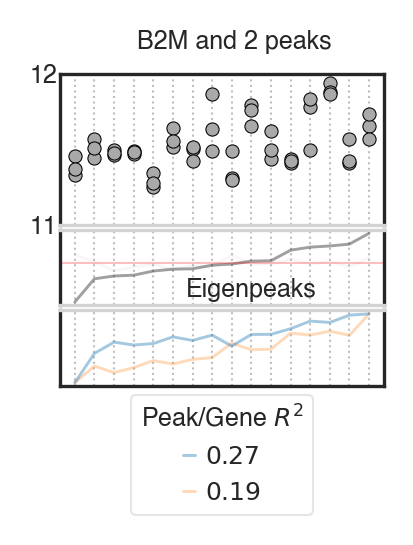

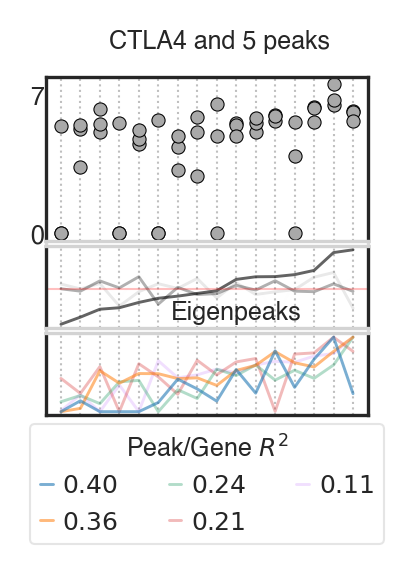

In [139]:
for gene in ['GNLY','B2M','CTLA4']:
    pgplot(gene, eigen=True, cutoff=0.05)

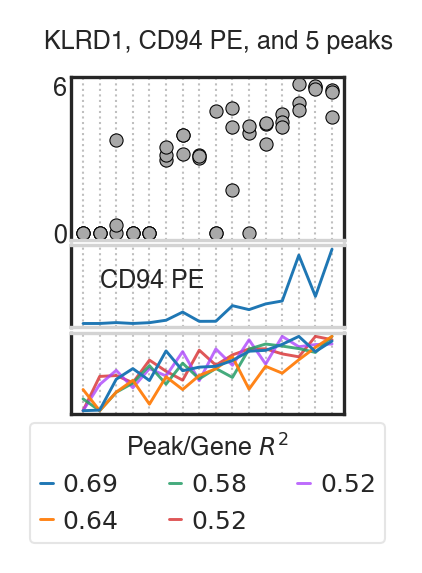

In [140]:
pgplot('KLRD1', protein='CD94 PE')

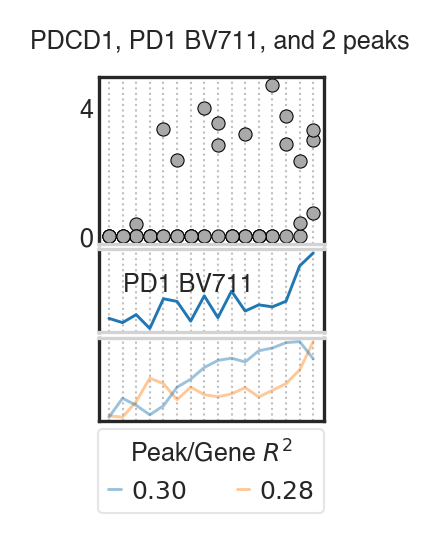

In [143]:
pgplot('PDCD1', protein='PD1 BV711')

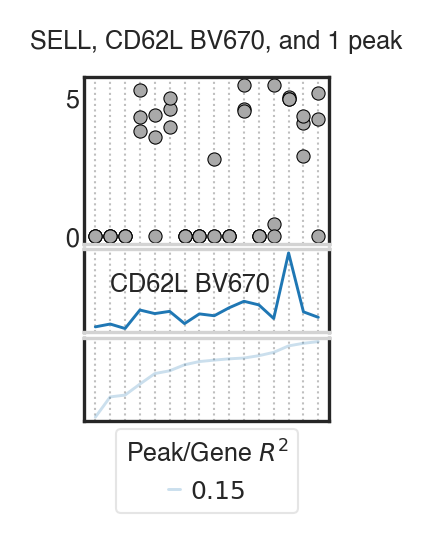

In [144]:
pgplot('SELL', protein='CD62L BV670', cutoff=0.1, window=100000)

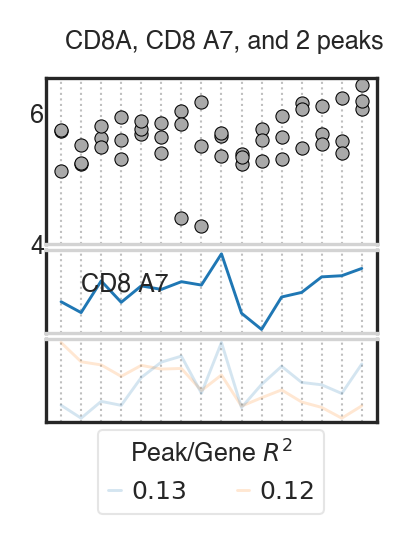

In [145]:
pgplot('CD8A', protein='CD8 A7', cutoff=0.1, window=100000)

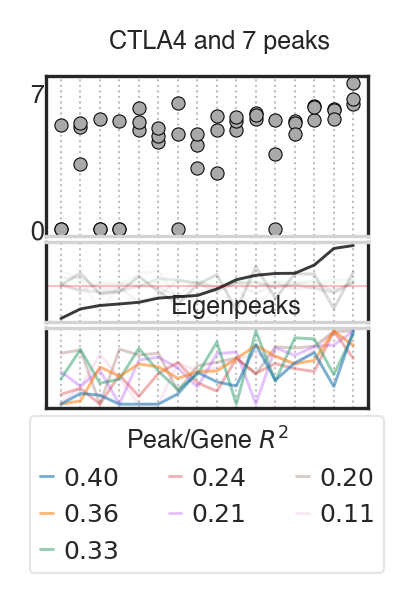

In [146]:
pgplot('CTLA4', cutoff=0.05, eigen=True, window=100000)

## Finding strong repressors

In [147]:
PCR_inter_ans = {}
for gene in PCR_ans.keys():
    PCR_a = PCR_ans[gene]
    ints = [col for col in PCR_a.columns if col[:3] == 'Int']
    PCR_inter_ans[gene] = PCR_a[ints]

We find strong repressors by looking for good peaks with negative R and R^2 > 0.5

In [148]:
repressed_genes = [gene for gene in PCR_ans.keys() if PCR_inter_ans[gene].loc[gene+'_R'].min() < -np.sqrt(0.5)]

In [149]:
len(repressed_genes)

63

Many of these genes with repressors may have high dropout, so we exclude these.

In [150]:
adata.var.loc[repressed_genes].pct_dropout_by_counts.sort_values()[:10]

gene_name
FAM103A1    12.857143
TAOK1       25.714286
PMS2P1      31.428571
CCNK        32.857143
SAE1        40.000000
RABEP1      42.857143
UBE3B       45.714286
RBM18       47.142857
MARK3       48.571429
FAM65B      52.857143
Name: pct_dropout_by_counts, dtype: float64

This should restrict our attention to genes with <50% dropout.

In [151]:
plot_genes = adata.var.loc[repressed_genes].pct_dropout_by_counts.sort_values()[:10].index
plot_genes

Index(['FAM103A1', 'TAOK1', 'PMS2P1', 'CCNK', 'SAE1', 'RABEP1', 'UBE3B',
       'RBM18', 'MARK3', 'FAM65B'],
      dtype='object', name='gene_name')

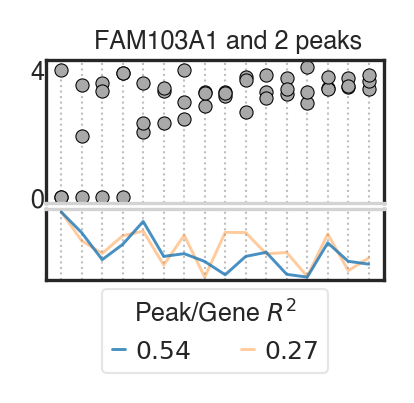

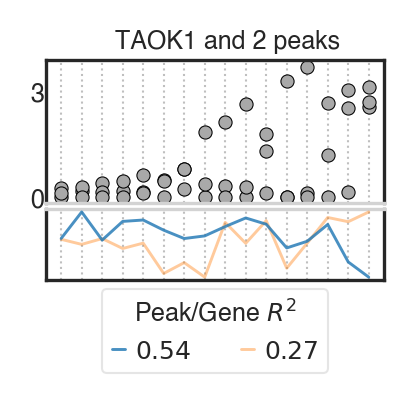

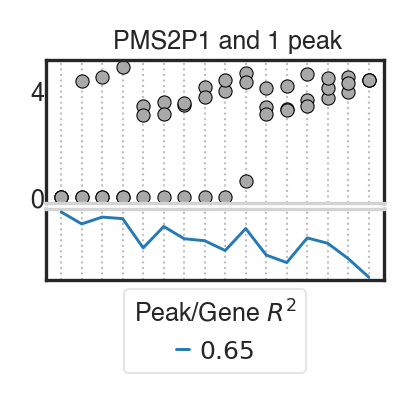

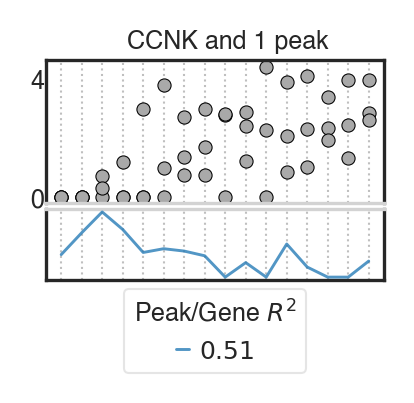

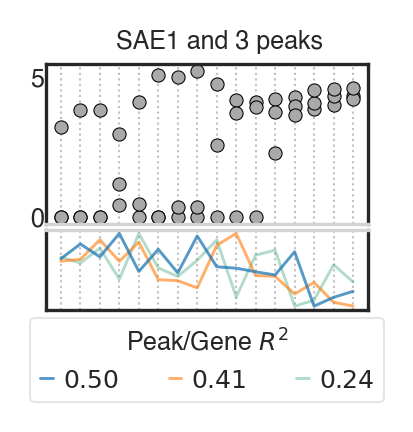

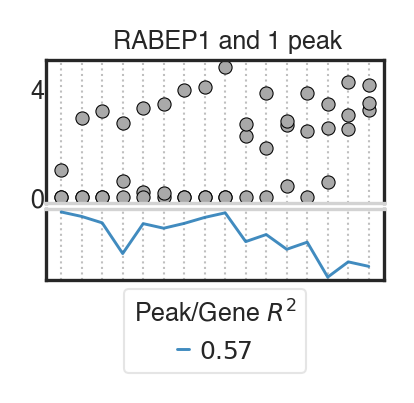

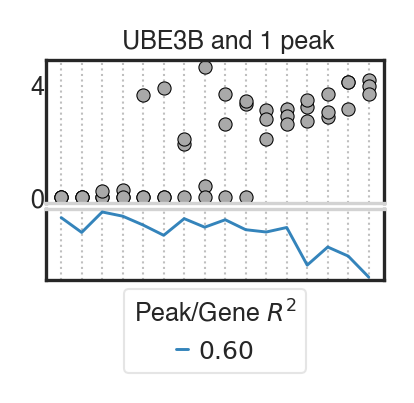

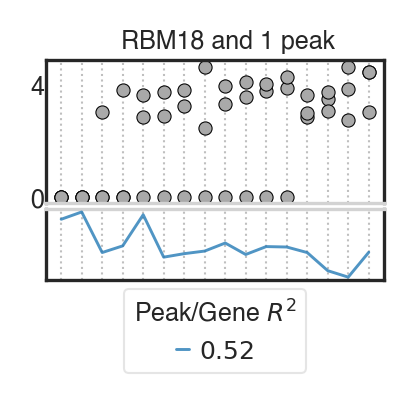

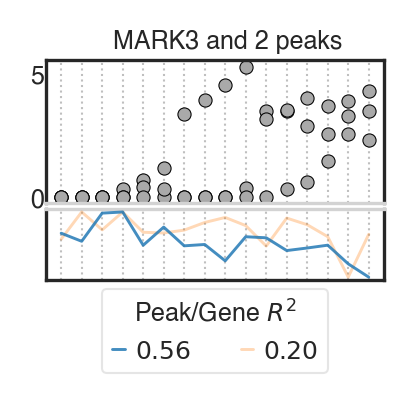

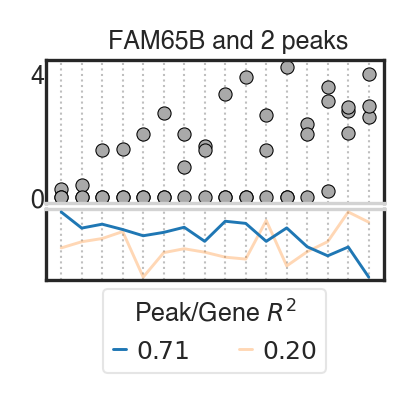

In [152]:
for gene in plot_genes:
    pgplot(gene, order='gene', file_annot='_repressor')

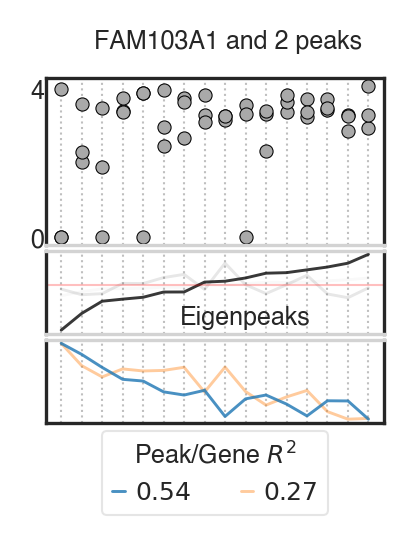

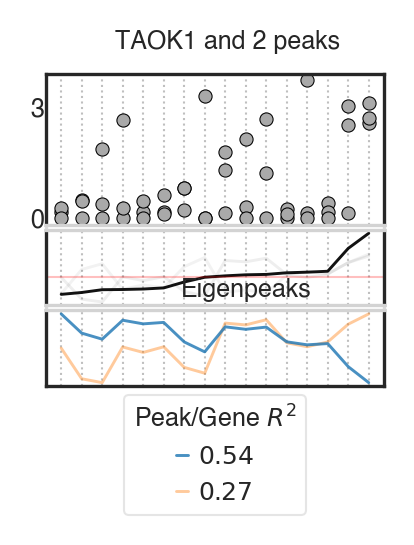

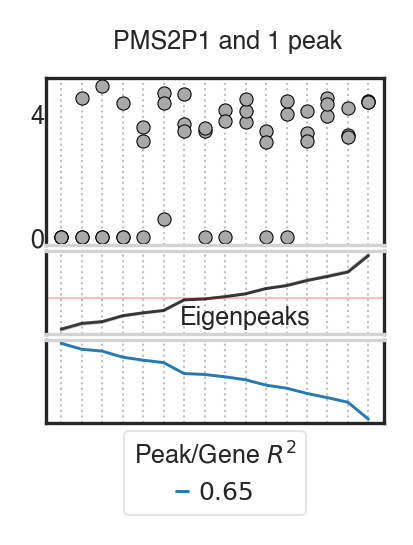

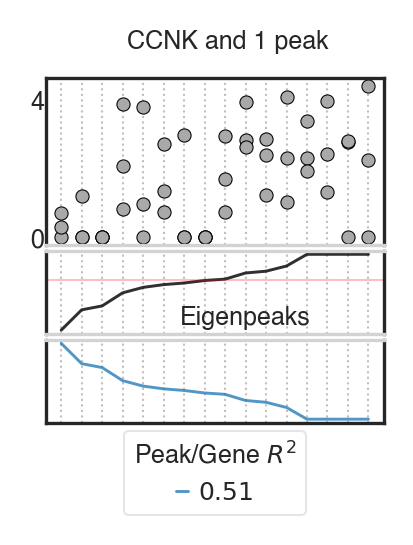

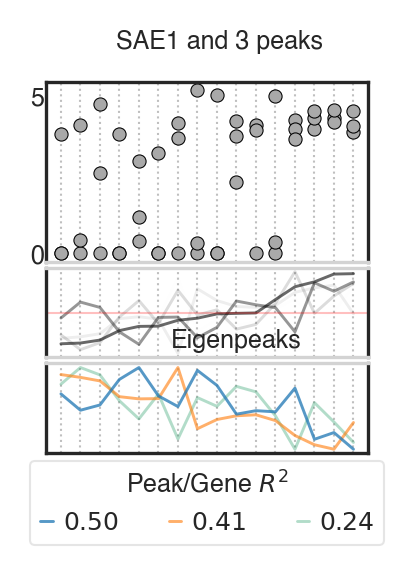

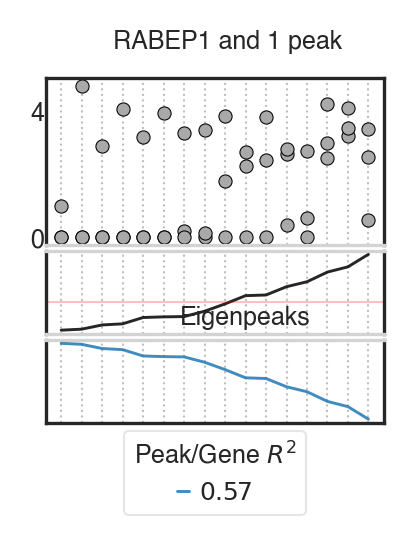

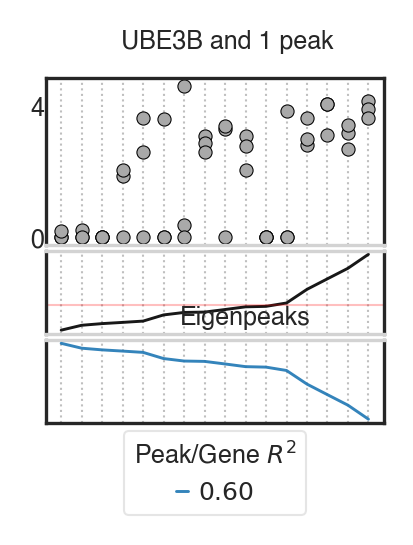

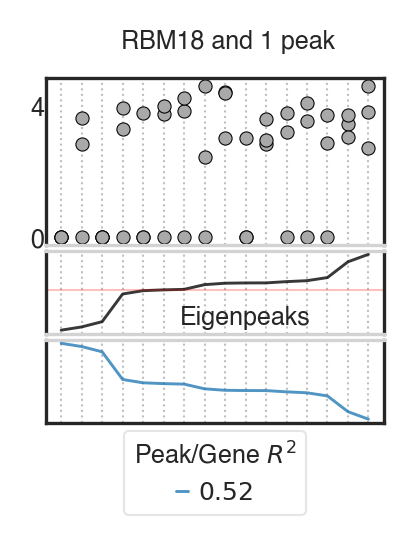

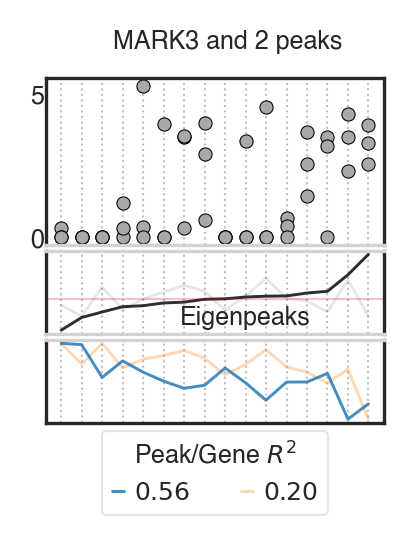

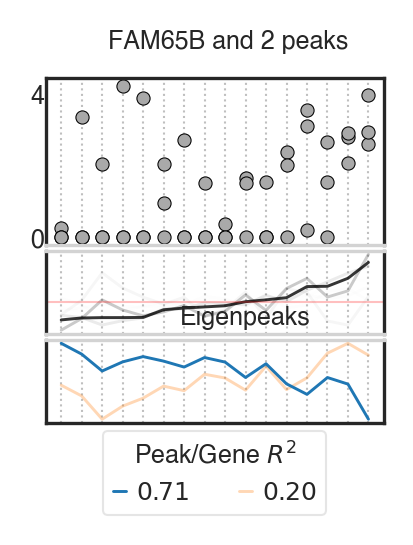

In [153]:
for gene in plot_genes:
    pgplot(gene, eigen=True, file_annot='_repressor')

# DORC experiment

Domains of regulatory chromatin, or DORCs, are regions around genes with lots of strongly correlated peaks.  Here we identify some DORCs.

In [154]:
DORC_df = pd.DataFrame(PCR_summary['num_sigpeaks'].sort_values())
DORC_df['rank'] = range(len(DORC_df))
DORC_df

num_sigpeaks   rank
WASH7P              0.0      0
PATZ1               0.0      1
EIF4ENIF1           0.0      2
SFI1                0.0      3
PISD                0.0      4
...                 ...    ...
SLC4A10             7.0  11843
DOCK5               7.0  11844
GPR141              7.0  11845
APBB2               9.0  11846
PIP5K1B             9.0  11847

[11848 rows x 2 columns]

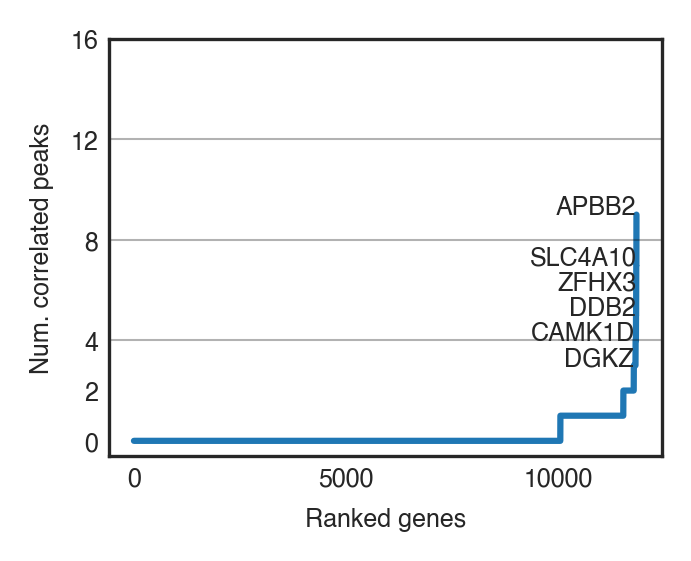

In [155]:
fig,ax = plt.subplots(1,1,figsize=(60*mm, 45*mm), dpi=300)
sns.lineplot(x='rank', y='num_sigpeaks', data=DORC_df, ax=ax)
sns.set_style('white')
setfontsize()

for n in range(3,18):
    if n in DORC_df.num_sigpeaks.unique():
        gene_plot = DORC_df[DORC_df.num_sigpeaks == n].index[0]
        ax.text(DORC_df.loc[gene_plot,'rank'], DORC_df.loc[gene_plot,'num_sigpeaks'], gene_plot, ha='right')

ax.axhline(4,color='k', linewidth=0.5, alpha=0.3)
ax.axhline(8,color='k', linewidth=0.5, alpha=0.3)
ax.axhline(12,color='k', linewidth=0.5, alpha=0.3)
ax.set_ylabel('Num. correlated peaks')
ax.set_xlabel('Ranked genes')

ax.set_xticks([0,5000,10000])
ax.set_yticks([0,2,4,8,12,16])

ax.tick_params(axis='both', pad=-1)

plt.show()

The "elbow" of this graph occurs with 3 or more significantly correlated peaks, so that's where we draw our line for DORCs.  Our analysis is not as detailed as the original DORC paper of course!

In [156]:
DORCs = DORC_df[DORC_df.num_sigpeaks > 2].num_sigpeaks
DORCs

DGKZ       3.0
IGFBP3     3.0
ABCB1      3.0
GNLY       3.0
DPP4       3.0
          ... 
SLC4A10    7.0
DOCK5      7.0
GPR141     7.0
APBB2      9.0
PIP5K1B    9.0
Name: num_sigpeaks, Length: 65, dtype: float64

In [157]:
DORCs.to_csv('DORCs.csv')

In [160]:
PCR_summary.loc[DORCs.index].sort_values('num_sigpeaks')

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
DGKZ         0.283943       1        9.0           3.0     0.523427   
KLRC1        0.686884       1        4.0           3.0     0.635820   
SKI          0.289847       2       12.0           3.0     0.373070   
RCAN1        0.209619       1        5.0           3.0     0.421684   
TEKT4P2      0.278222       1        3.0           3.0     0.400577   
...               ...     ...        ...           ...          ...   
SLC4A10      0.009579       1       16.0           7.0     0.531515   
DOCK5        0.673069       1       12.0           7.0     0.721140   
GPR141       0.328308       1        7.0           7.0     0.320467   
APBB2        0.624884       1       12.0           9.0     0.710313   
PIP5K1B      0.317774       1       11.0           9.0     0.375360   

         eigen1_R_sq  eigen2_R_sq  eigen3_R_sq  eigen4_R_sq  eigen5_R_sq  \
DGKZ        0.016540     0.001361     0.000503          NaN          NaN   
KLRC1       0.130076     0.038098     0.002432          NaN          NaN   
SKI         0.302981     0.017865     0.016106     0.003342     0.003033   
RCAN1       0.167408     0.028148     0.011862     0.008815          NaN   
TEKT4P2     0.125479     0.000185          NaN          NaN          NaN   
...              ...          ...          ...          ...          ...   
SLC4A10     0.072487     0.070881     0.041627     0.035777     0.012838   
DOCK5       0.066418     0.024145     0.018103     0.009269     0.007185   
GPR141      0.070674     0.052109     0.024060     0.003730     0.001304   
APBB2       0.067890     0.033944     0.028975     0.024870     0.010941   
PIP5K1B     0.099473     0.087938     0.040607     0.034258     0.019818   

         eigen6_R_sq  eigen7_R_sq  eigen8_R_sq  eigen9_R_sq  eigen10_R_sq  \
DGKZ             NaN          NaN          NaN          NaN           NaN   
KLRC1            NaN          NaN          NaN          NaN           NaN   
SKI              NaN          NaN          NaN          NaN           NaN   
RCAN1            NaN          NaN          NaN          NaN           NaN   
TEKT4P2          NaN          NaN          NaN          NaN           NaN   
...              ...          ...          ...          ...           ...   
SLC4A10     0.011199     0.010624     0.003017     0.000291      0.000048   
DOCK5       0.004432     0.000968     0.000840     0.000233      0.000171   
GPR141      0.000231          NaN          NaN          NaN           NaN   
APBB2       0.009758     0.004503     0.002547     0.000271      0.000195   
PIP5K1B     0.014365     0.002067     0.000612     0.000171           NaN   

         eigen11_R_sq  eigen12_R_sq  eigen13_R_sq  eigen14_R_sq  
DGKZ              NaN           NaN           NaN           NaN  
KLRC1             NaN           NaN           NaN           NaN  
SKI               NaN           NaN           NaN           NaN  
RCAN1             NaN           NaN           NaN           NaN  
TEKT4P2           NaN           NaN           NaN           NaN  
...               ...           ...           ...           ...  
SLC4A10  1.279346e-06           NaN           NaN           NaN  
DOCK5    1.868106e-08           NaN           NaN           NaN  
GPR141            NaN           NaN           NaN           NaN  
APBB2    1.229391e-05           NaN           NaN           NaN  
PIP5K1B           NaN           NaN           NaN           NaN  

[65 rows x 19 columns]

DDB2       5.0
ACTB       5.0
AFAP1L2    5.0
KIR2DL4    5.0
KLRD1      5.0
ZFHX3      6.0
HDAC9      6.0
CADM1      6.0
SLC4A10    7.0
DOCK5      7.0
GPR141     7.0
APBB2      9.0
PIP5K1B    9.0
Name: num_sigpeaks, dtype: float64

In [159]:
print(', '.join(DORCs.index))

DGKZ, IGFBP3, ABCB1, GNLY, DPP4, RAB3GAP1, IFNGR1, HIVEP2, GALNT2, AC005083.1, PIK3AP1, ENTPD1, KIAA1217, MYO1D, PDGFRB, KLF2, GPR132, TBKBP1, PACS2, AKAP5, RPL13A, IFI44, ITGA1, KLRC1, SKI, RCAN1, TEKT4P2, RHOH, IL13, AC006369.2, TBC1D31, ITK, CPPED1, RASA3, CCL4, HDGFRP3, GMDS, LAYN, FGFR1, MFSD10, RP11-288E14.2, ADAM19, CAMK1D, MACC1, IL4, CD70, IL12RB1, CSF2, AOAH, FAM49A, RASGEF1A, CD86, DDB2, ACTB, AFAP1L2, KIR2DL4, KLRD1, ZFHX3, HDAC9, CADM1, SLC4A10, DOCK5, GPR141, APBB2, PIP5K1B


Now we plot the DORCiest of DORCs... those with 5 or more significantly correlated peaks.

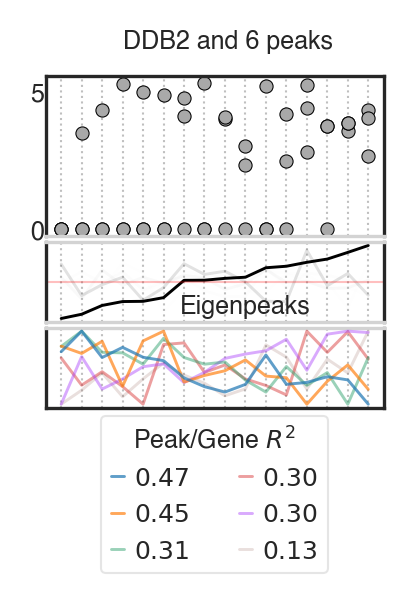

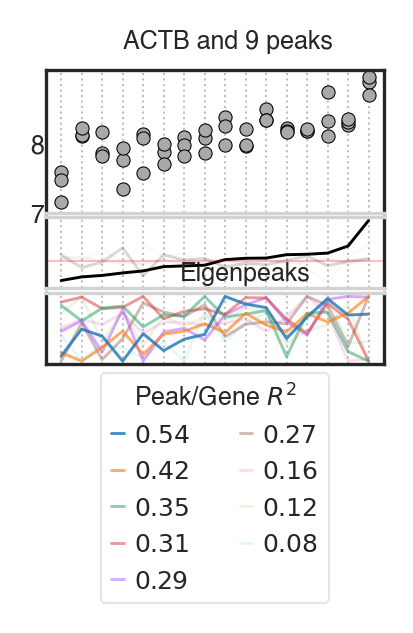

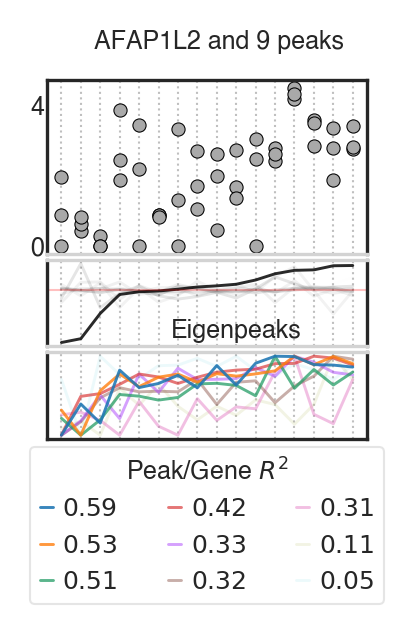

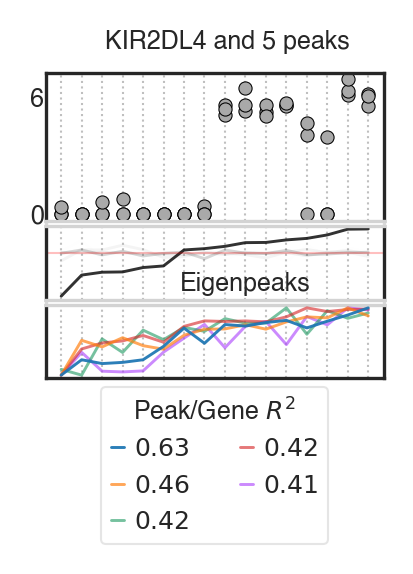

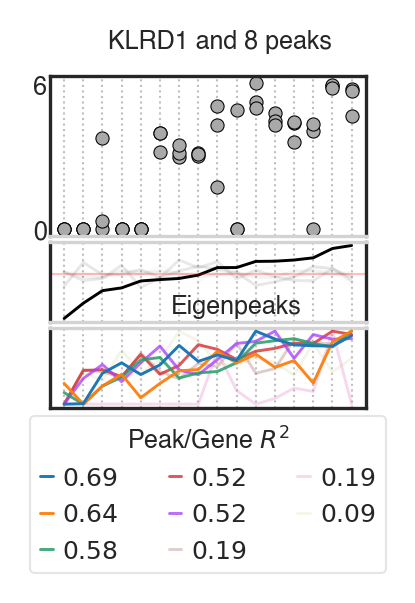

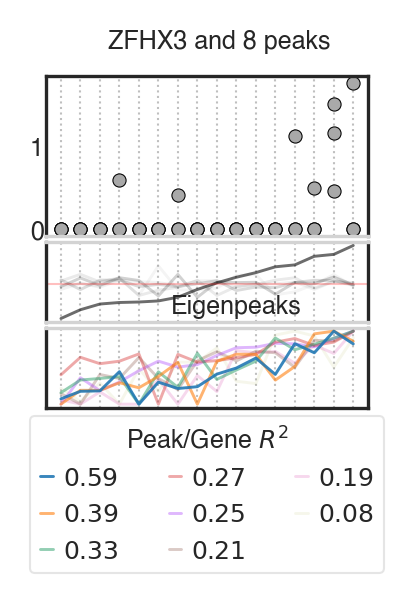

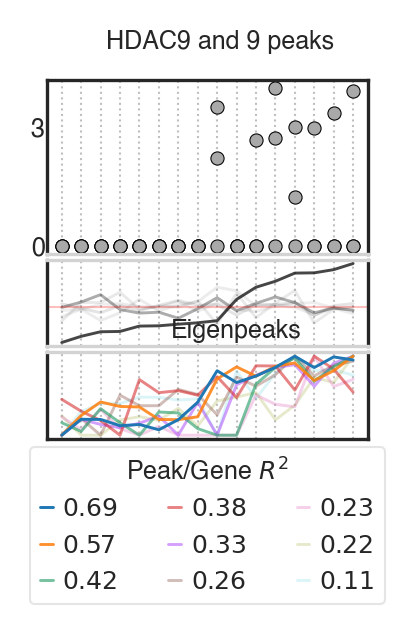

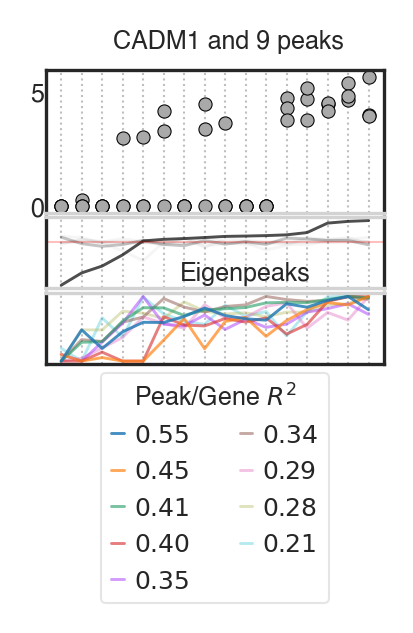

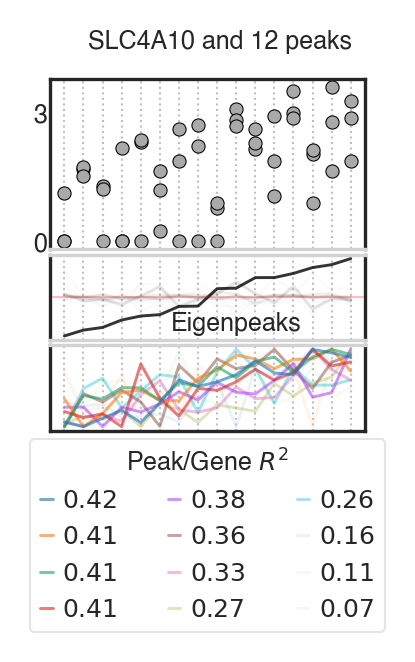

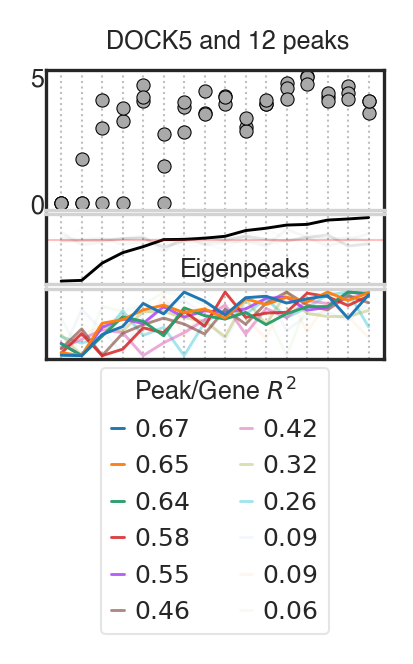

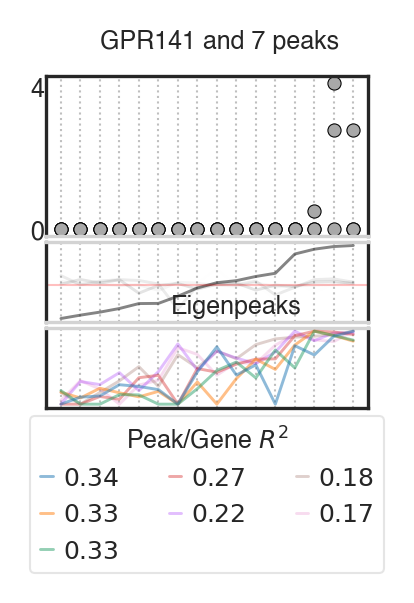

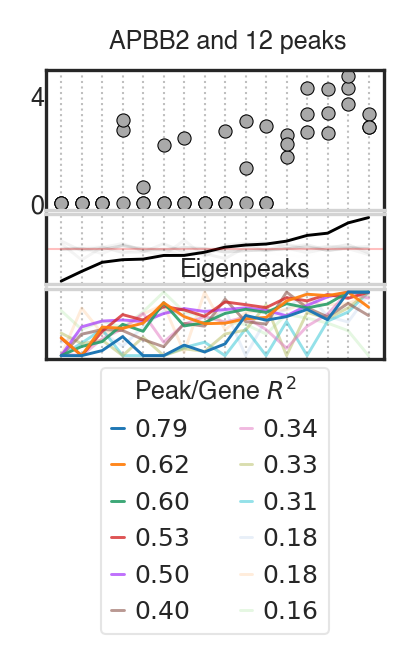

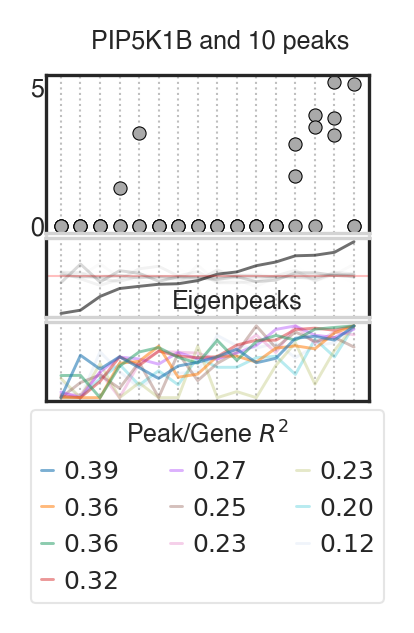

In [163]:
for gene in DORCs[DORCs > 4].index:
    pgplot(gene, eigen=True, cutoff=0.05)

In [165]:
(adata.var.loc[DORCs.index].F_pval < 0.01).sum() / len(adata.var.loc[DORCs.index])

0.4153846153846154

In [166]:
(adata.var.F_pval < 0.01).sum() / len(adata.var)

0.08307381533540947

Note that about 8.3% of genes exhibit clonal expression patterns, according to F-statistic.  But 41.5% of DORC genes do!

# Eigenpeak schematic plots

In [167]:
def eigdata(gene, window=50000, verbose=False, save=False):
    edata = {}
    
    PCR_a = PCR_analysis(gene, window=window)
    peaklist = [row for row in PCR_a.index if row[:3] == 'Int']
    pplot_df = peak_clonal[peaklist].copy()
    
    if verbose:
        print('The clonal peak averages are below')
        display(pplot_df)
    
    edata['peak_clonal'] = pplot_df
    
    eig_cols = [col for col in PCR_a.columns if col[:3] == 'Eig']
    eig_weights = PCR_a.loc[peaklist, eig_cols]
    
    realpeaks = pplot_df
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    
    edata['peak_z'] = normpeaks
    
    edata['eig_weights'] = eig_weights
    
    edata['peak_corr'] = normpeaks.corr()
    
    eig_df = normpeaks.dot(eig_weights)

    edata['eigenpeaks'] = eig_df
    
    eigR2 = PCR_a.loc[gene+'_Rsq',eig_cols].astype(float)
    edata['eigR2'] = eigR2
    
    edata['peak_meta'] = ATACR_data.var.loc[peaklist][['chr','start','mid','end','in_gene','itype']]
    
    if save:
        outdir = './eigendata/{}/'.format(gene)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
            
        for key in edata.keys():
            outname = key+'.csv'
            fullname = os.path.join(outdir, outname)  
            edata[key].to_csv(fullname)
            
    return edata

In [168]:
import os

In [169]:
edata = eigdata('CTLA4', window=100000, save=True)

In [170]:
for gene in ['KLRD1', 'CD28', 'MAST4', 'PMS2P1']:
    eigdata(gene, save=True)

In [172]:
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize

In [177]:
def eig_weightplot(gene, window=50000, num_eig = 5, eigplot=False):
    
    if eigplot:
        figsize=(90*mm, num_eig * 6*mm)
        fig,ax = plt.subplots(num_eig,2,figsize=figsize, dpi=300)
    else:
        figsize=(40*mm, num_eig * 6*mm)
        fig,ax = plt.subplots(num_eig,1,figsize=figsize, dpi=300)
        
    sns.set_style('white')
    setfontsize()
    
    edata = eigdata(gene, window=window)
    peaklist = edata['peak_meta'].index
    chrome = edata['peak_meta'].chr[0]
    
    xmin, xmax = edata['peak_meta'].start.min() - 5000, edata['peak_meta'].end.max() + 5000
    
    pm = edata['peak_meta']
    TSS_locs = pm[pm.itype == 'promoter-TSS'].mid
    
    cmap = plt.cm.seismic
    norm = Normalize(vmin=-1, vmax=1)
    
    eigenpeaks = edata['eigR2'].sort_values(ascending=False)[:num_eig].index
    
    if eigplot:
        eigplot_df = edata['eigenpeaks'][eigenpeaks].copy()
        eigplot_df['Clone'] = eigplot_df.index
        eigplot_df.sort_values(by=eigenpeaks[0], inplace=True)
        eigmax = eigplot_df[eigenpeaks[0]].max()
        eigmin = eigplot_df[eigenpeaks[0]].min()
    
    for j,epeak in enumerate(eigenpeaks):
        if eigplot:
            axx = ax[j,0]
        else:
            axx = ax[j]
            
        for peak in peaklist:
            x_start = edata['peak_meta'].start[peak]
            x_end = edata['peak_meta'].end[peak]
            x_width = x_end - x_start
            wt = edata['eig_weights'].loc[peak, epeak]
            wt_color = cmap(norm(wt))
            rect = Rectangle((x_start, 0), x_width, 1, linewidth=0.5, edgecolor=wt_color, 
                             facecolor=wt_color)
            axx.add_patch(rect)
        axx.set_xlim(xmin, xmax)
        if j > 0:
            axx.spines['top'].set_color('lightgray')
        if j < len(eigenpeaks) - 1:
            axx.spines['bottom'].set_color('lightgray')
        axx.spines['left'].set_color('lightgray')
        axx.spines['right'].set_color('lightgray')
        axx.set_xticks(TSS_locs)
        axx.set_xticklabels(['']*len(TSS_locs))
        axx.tick_params(axis='x',pad=-1,direction='out', length=1, bottom=True, top=True, colors='green')
        axx.set_yticks([])
    
        if eigplot:
            
            sns.lineplot(x='Clone', y=epeak, data=eigplot_df, ax=ax[j,1], linewidth=0.7)
            ax[j,1].set_ylim(eigmin,eigmax)
            ax[j,1].set_xticks([])
            ax[j,1].set_yticks([])
            ax[j,1].set_xlabel('')
            ax[j,1].set_ylabel('')
            if j > 0:
                ax[j,1].spines['top'].set_color('lightgray')
            if j < len(eigenpeaks) - 1:
                ax[j,1].spines['bottom'].set_color('lightgray')
            ax[j,1].spines['left'].set_color('lightgray')
            ax[j,1].spines['right'].set_color('lightgray')
            
    set_size(fig, figsize)
    plt.savefig("Panels/{}_eigweights.pdf".format(gene), bbox_inches='tight')
    print('Chromosome {}, from {} to {}'.format(chrome, xmin, xmax))
    plt.show()

Chromosome 12, from 10396907 to 10478811


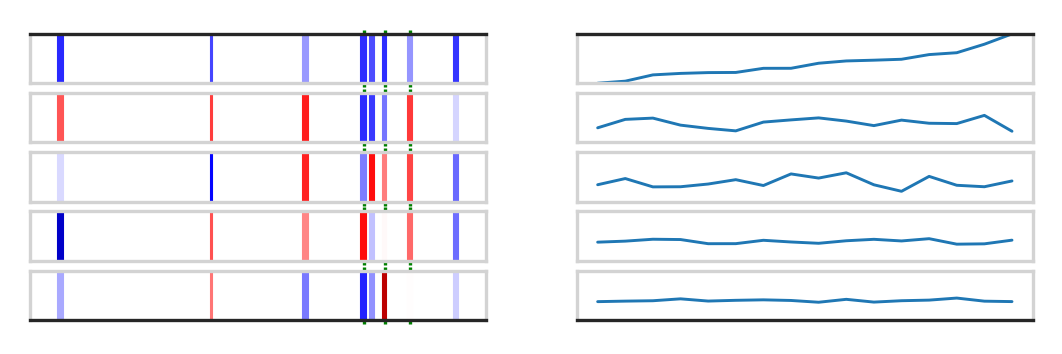

In [178]:
eig_weightplot('KLRD1', eigplot=True)

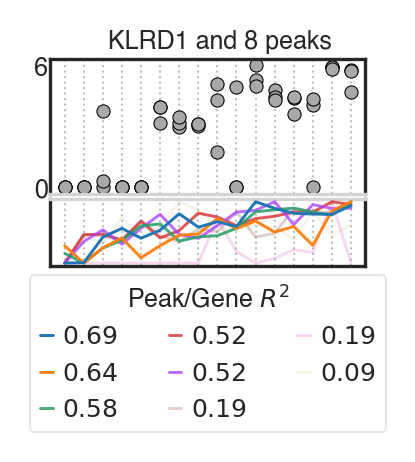

In [179]:
pgplot('KLRD1', cutoff=0.05)

# Interactive plots with plotly

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
clone_order = list(gene_clonal['GNLY'].sort_values().index)
GNLY_df = pd.DataFrame(adata[adata.obs.Clone_ID.isin(clone_order)].to_df()['GNLY'])
GNLY_df['Clone'] = adata.obs.Clone_ID
GNLY_df['CloneNo'] = GNLY_df['Clone'].apply(lambda cl : clone_order.index(cl))
GNLY_df = GNLY_df.sort_values(by = 'CloneNo')
GNLY_df['Obs'] = GNLY_df.index
GNLY_df.to_csv('GNLY.csv')

In [ ]:
GNLY_df.head()

In [ ]:
PCR_df = PCR_analysis('GNLY', window=50000)
peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
peaklist = [peak for peak in peaklist if PCR_df.loc['GNLY_Rsq',peak] > 0.2]
pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()    
pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
pplot_df

In [ ]:
pplot_df = pplot_df.melt(ignore_index = False)

In [ ]:
pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
pplot_df.head()
pplot_df

In [ ]:
pplot_df['R'] = pplot_df['PeakID'].map(PCR_ans['GNLY'].loc['GNLY_R'])
pplot_df['R_sq'] = pplot_df['R']**2
pplot_df['Peak location'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'mid'])
#pplot_df['end'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'end'])
pplot_df = pplot_df.sort_values(by=['CloneNo','R_sq'])
pplot_df

In [ ]:
import altair as alt
gene_chart = alt.Chart(GNLY_df).mark_circle(size=100).encode(
    x={"field": "Clone",
      "type": "ordinal",
       "sort" : clone_order,
       "axis" : alt.Axis(labels=False, title=" ")},
    y='GNLY',
    color='Clone',
    tooltip=['Clone', 'Obs', 'GNLY']
).interactive().properties(
    width=400,
    height=200
)

highlight = alt.selection(type='single', on='mouseover',
                          fields=['PeakID'], nearest=True)

TSS = adata.var.loc['GNLY','TSS']

peak_base = alt.Chart(pplot_df).encode(
    x={"field": "Clone",
               "type": "ordinal",
               "sort" : clone_order},
    y={"field" : "value",
       "type": "quantitative",
       "axis" : alt.Axis(labels=False, title="Peak height")},
    color=alt.Color("PeakID")
)

# interval selection in the bar chart
pts = alt.selection_multi(encodings=["x"])

points = peak_base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=400
)

peak_chart = peak_base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)), #,
    opacity=alt.Opacity("R_sq", legend=None),
    tooltip=['Clone', 'PeakID', 'value']#,
    ).transform_filter(pts).interactive().properties(
    width=400,
    height=100
)

peak_chart = points + peak_chart


peakR_chart = alt.Chart(pplot_df).mark_bar().encode(
    x={"field":"Peak location", 
       "type":"quantitative",
       "axis":alt.Axis(values=[TSS-50000, TSS, TSS+50000])},
    y="R",
    text="PeakID",
    color="PeakID",
    opacity=alt.condition(~highlight, alt.value(0.1), alt.value(1.0)),
    tooltip=['PeakID','R','R_sq']
    #color=alt.condition(
    #    alt.datum.R > 0,
    #    alt.value("steelblue"),  # The positive color
    #    alt.value("orange")  # The negative color
    #)
).interactive().properties(
    width=300,
    height=50).add_selection(pts)



TSS_line = alt.Chart(pd.DataFrame({'TSS': [TSS]})).mark_rule().encode(
    x=alt.X('TSS'))

peakR_chart = peakR_chart + TSS_line

#peakR_chart = peakR_chart + peakR_text

#peaks_chart = alt.hconcat(peak_chart, peakR_chart)

chart = alt.vconcat(gene_chart, peak_chart, peakR_chart).resolve_scale(
    color='independent')

chart

In [ ]:
chart.save('GNLY.json')

In [ ]:
def pgplotly(gene, protein = None, cutoff=0.2, window=50000):
    if protein:
        num_rows = 3
        specs=[[{"type": "scatter"}],
               [{"type": "line"}],
               [{"type": "line"}]]
    else:
        num_rows = 2
        specs=[[{"type": "scatter"}],
               [{"type": "scatter"}]]
        
    #fig, ax = plt.subplots(num_rows,1,figsize=(2.5,0.75*num_rows), dpi=300, sharex=True,
    #                       gridspec_kw = {'hspace':0.05, 'height_ratios':hr})            
    #
    #plt.rcParams['text.usetex'] = False
    #setfontsize()

    fig = make_subplots(
        rows=num_rows, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        specs=specs
    )




    PCR_df = PCR_analysis(gene, window=window)
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    
    
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
    clone_order = [clone for clone in clone_order if clone in pg_clones]
    gplot_df['CloneNo'] = gplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    gplot_df = gplot_df.sort_values(by='CloneNo')
    gplot_df['Text'] = ''
    for row in gplot_df.index:
        expr = gplot_df.loc[row,gene]
        cl = gplot_df.loc[row,'Clone']
        gplot_df.loc[row,'Text'] = '{} expression {:1.3f} in Clone {}.'.format(gene,expr,cl)
    col_range = list(range(len(gplot_df)))
    #for clone in clone_order:
    #    for row in range(num_rows):
    #        ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    fig.add_trace(
        go.Scatter(
            x=gplot_df['Clone'],
            y=gplot_df[gene],
            mode="markers",
            marker=dict(size=16, 
                        color=gplot_df['CloneNo'], 
                        colorscale=px.colors.qualitative.Dark24),
            text=gplot_df['Text'],
            name="{} expression".format(gene)
        ),
        row=1, col=1)
    
    #sns.scatterplot(x='Clone', y=gene, hue='Clone', data=gplot_df, ax=ax[0], legend=False)
    #gene_ticks = [gplot_df[gene].min(), gplot_df[gene].mean(), gplot_df[gene].max()]
    #ax[0].set_yticks(gene_ticks)
    #ax[0].set_yticklabels(gene_ticks, x=0.03)
    #ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #ax[0].set_ylabel(gene)
    #ax[0].yaxis.set_label_position("right")
    
    # ATAC PLOT
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
    pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
    
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
    pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    pplot_df = pplot_df.sort_values(by='CloneNo')
    #
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        fig.add_trace(
            go.Scatter(
                x=pplot_df['Clone'],
                y=pplot_df[peak],
                mode="lines",
                #text=gplot_df['Text'],
                name=peak
            ),
            row=2, col=1)
        
    
    
    # PROTEIN PLOT
    #if protein:
    #    proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
    #    proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
    #    proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
    #    proplot_df['Clone'] = proplot_df.index
    #    sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
    #    ax[1].text(1,0.5,protein, ha='left')
    #    ax[1].set_ylabel('Prot')
    #    ax[1].yaxis.set_label_position("right")
    #    ax[1].set_yticks([])
    #    ax[1].set_xlabel('')
    #    ax[1].spines['top'].set_color('lightgray')
    #    ax[1].spines['bottom'].set_color('lightgray')
    

    if protein:
        title = '{}, {}, and {} peaks.'.format(gene, protein, len(peaklist))
    else:
        title = '{} and {} peaks.'.format(gene, len(peaklist))
    #plt.suptitle(title, y=1.02)
    
    # Plot legend
    #if no_peaks <= 6:
    #    ncol = no_peaks
    #else:
    #    ncol = (no_peaks + 1)//2
    #lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
    #                  loc=9, ncol=ncol, framealpha=0.5)
    #lgnd.get_frame().set_linewidth(0.5)
    
    # Save and show figure.
    #set_size(fig, (2.5, 1.5))
    #plt.savefig("Panels/MultiPlots/{}_multi.pdf".format(gene), bbox_inches='tight')
    #plt.show()
    fig.show()
    fig.write_html("Plotly/{}_plotly.html".format(gene), include_plotlyjs=False)
    

In [ ]:
pgplotly('GNLY')